In [1]:
import numpy as np
import cv2
from numpy.fft import rfft, rfftfreq, irfft
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

C:\Users\Admin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Admin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Admin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Admin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
signals_1 = []
signals_2 = []
signals_3 = []

file = open("train_set.txt")
readed = file.read().split('\n\n')

for sig in readed:
    sig = sig.split('\n')
    dick = {'1' : signals_1, '2' : signals_2, '3' : signals_3}
    chanels = [np.array(sig[1].split(), dtype='int16'), np.array(sig[2].split(), dtype='int16')]
    dick[sig[0]].append(chanels)

In [3]:
def getX(sig):
    N = sig.size
    return rfftfreq(N, 1 / 256)

def getY(sig):
    yf = rfft(sig)
    return np.abs(yf)

def getFilterFurie(sig):
    x = getX(sig)
    sig = getY(sig)
    sig[int(40/x[1]):int(70/x[1])] = 0
    return sig

def getFilterSignal(sig):
    sig = getFilterFurie(sig)
    return irfft(sig)[10:-10]

def getSpector(sig, n):
    spectr = []
    butch = len(sig) // n
    
    for i in range(0, len(sig)-1, butch):
        spectr.append(getFilterFurie(sig[i:i+butch]))
        
    spectr = np.array(spectr[:-1]).transpose()
    freqs = np.linspace(0, 127, spectr.shape[0])
    time = np.linspace(0, sig.size / 250, spectr.shape[1])
    
    return time, freqs, spectr

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


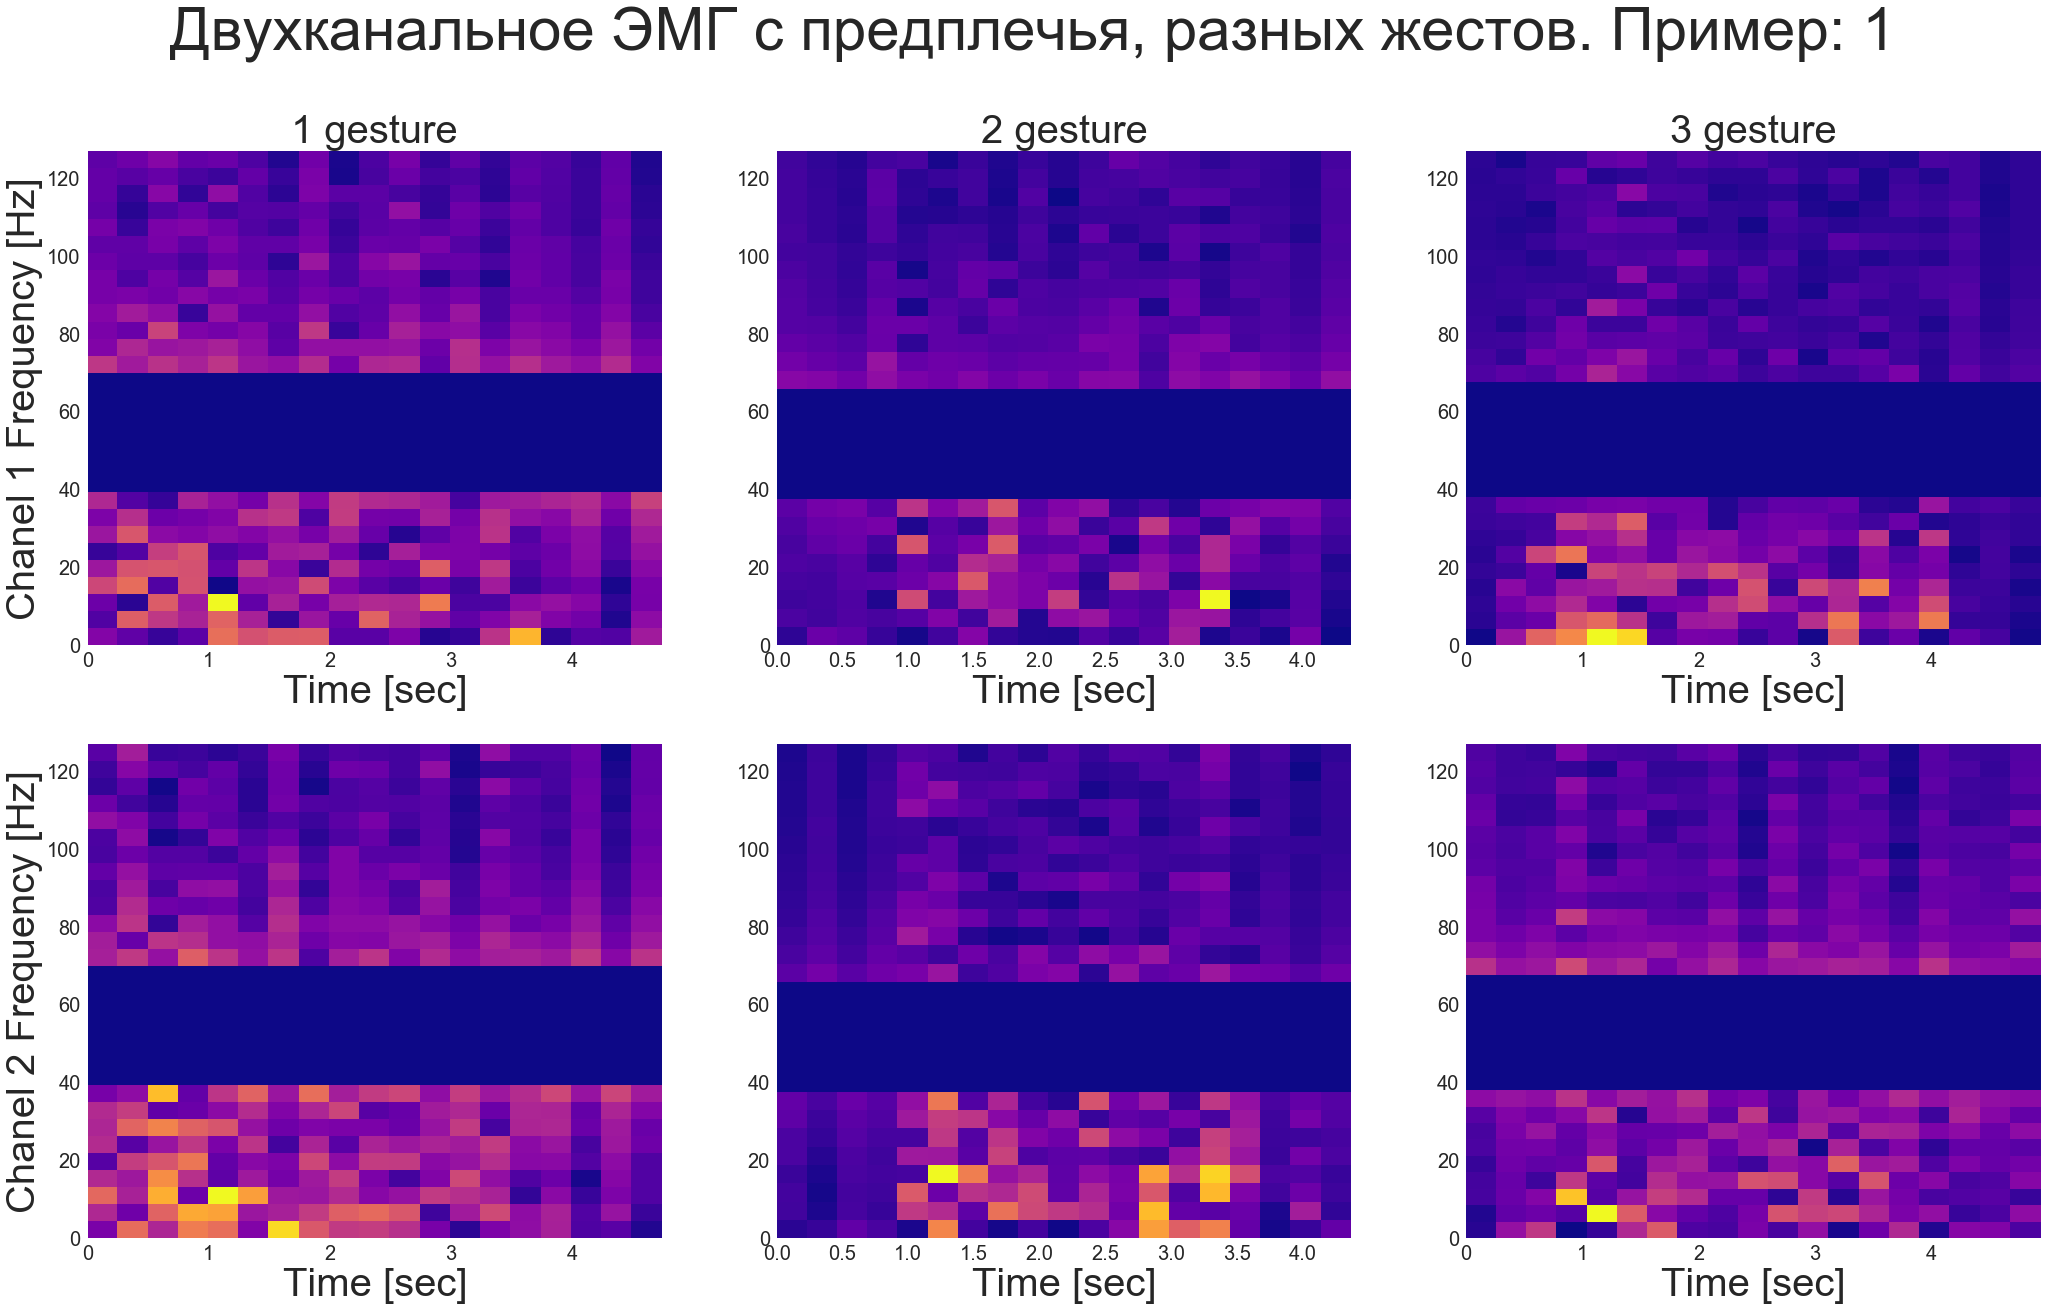

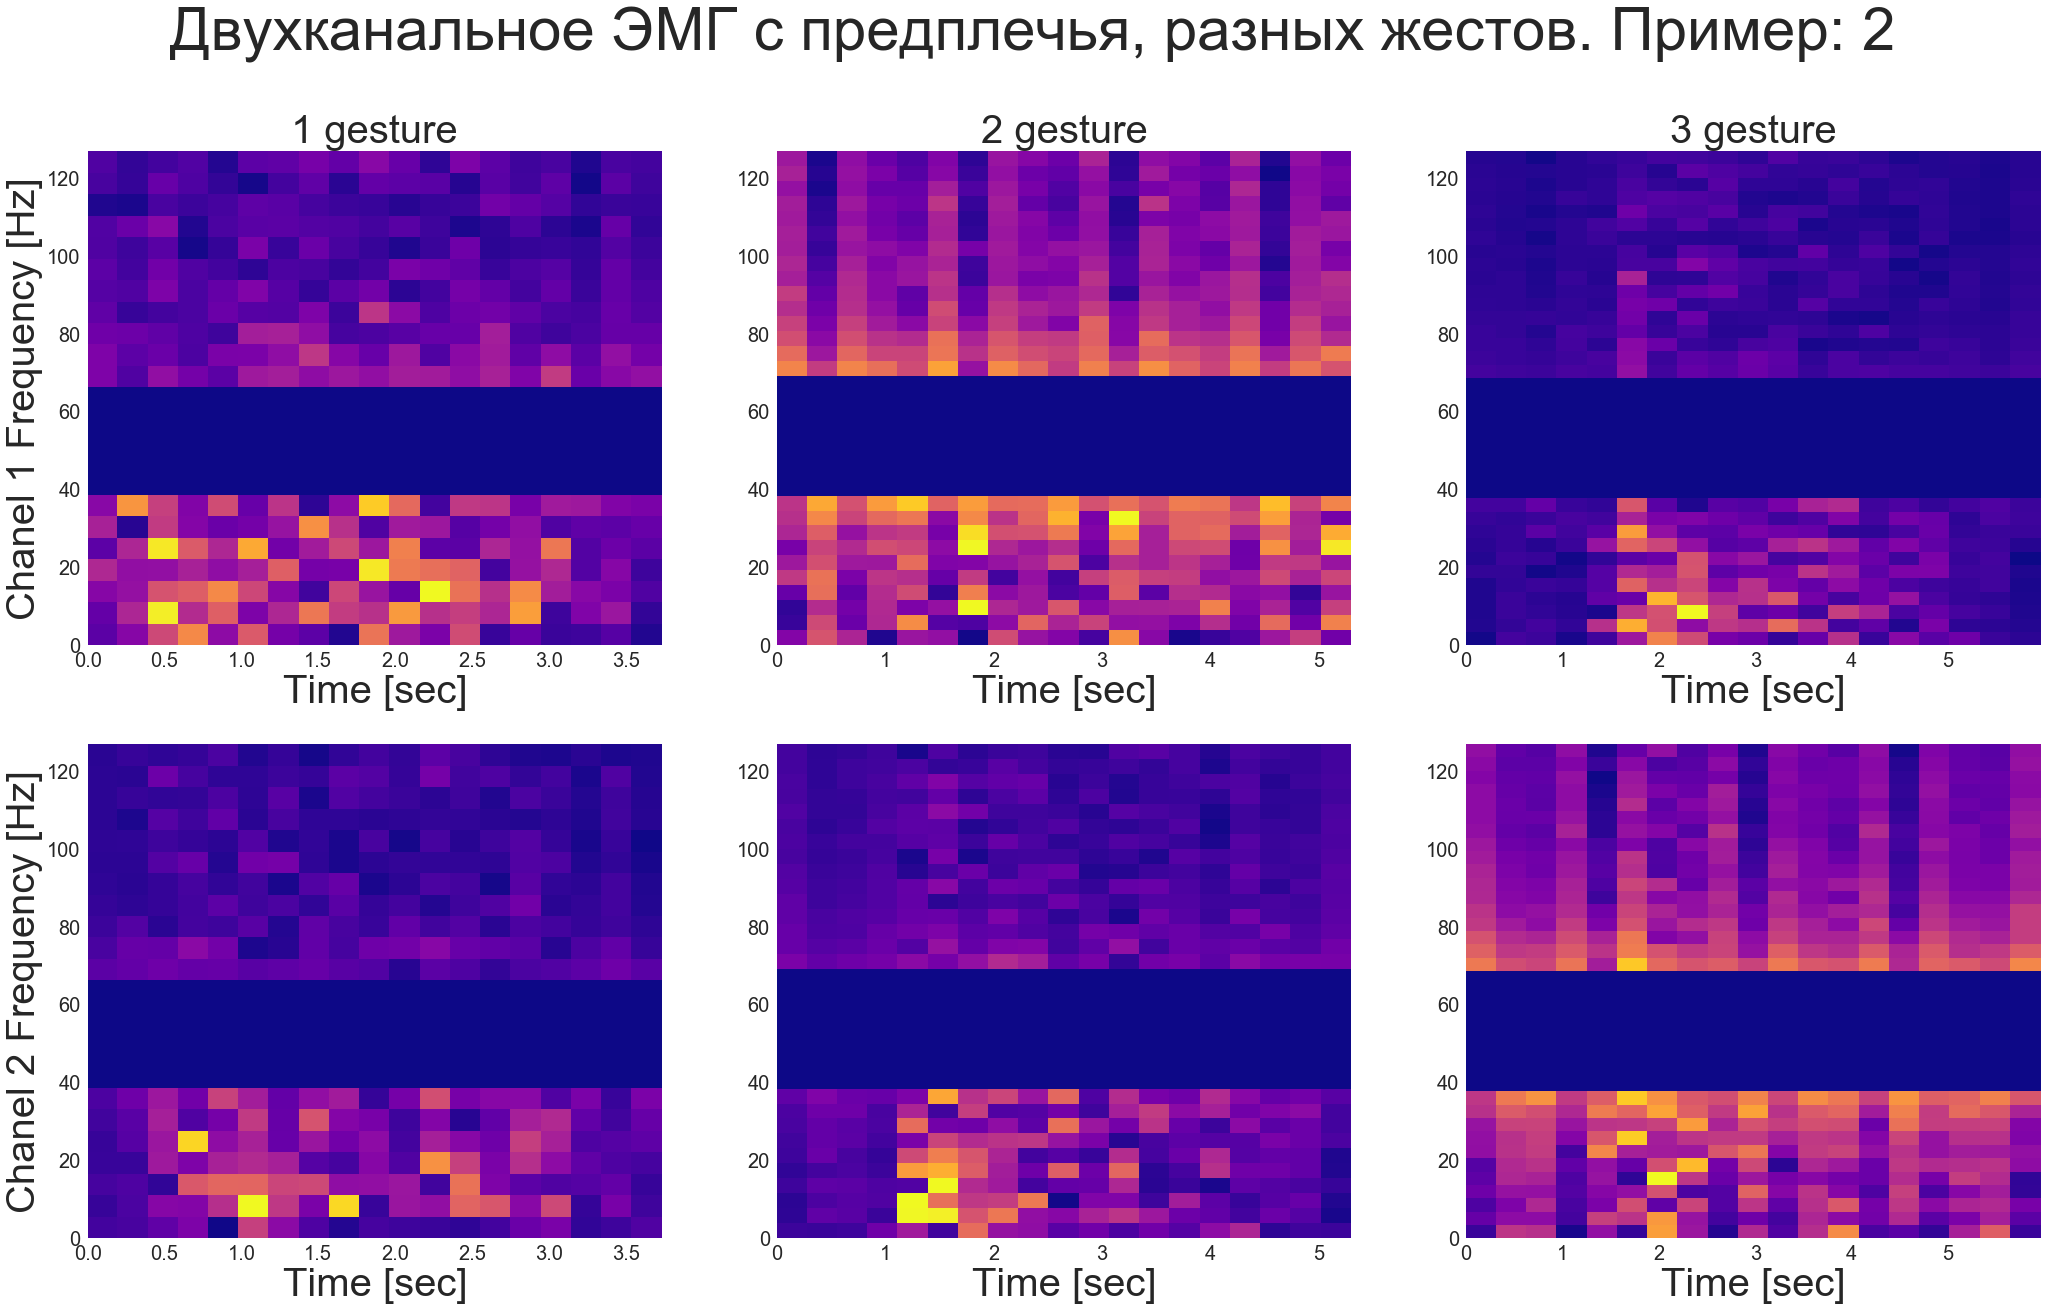

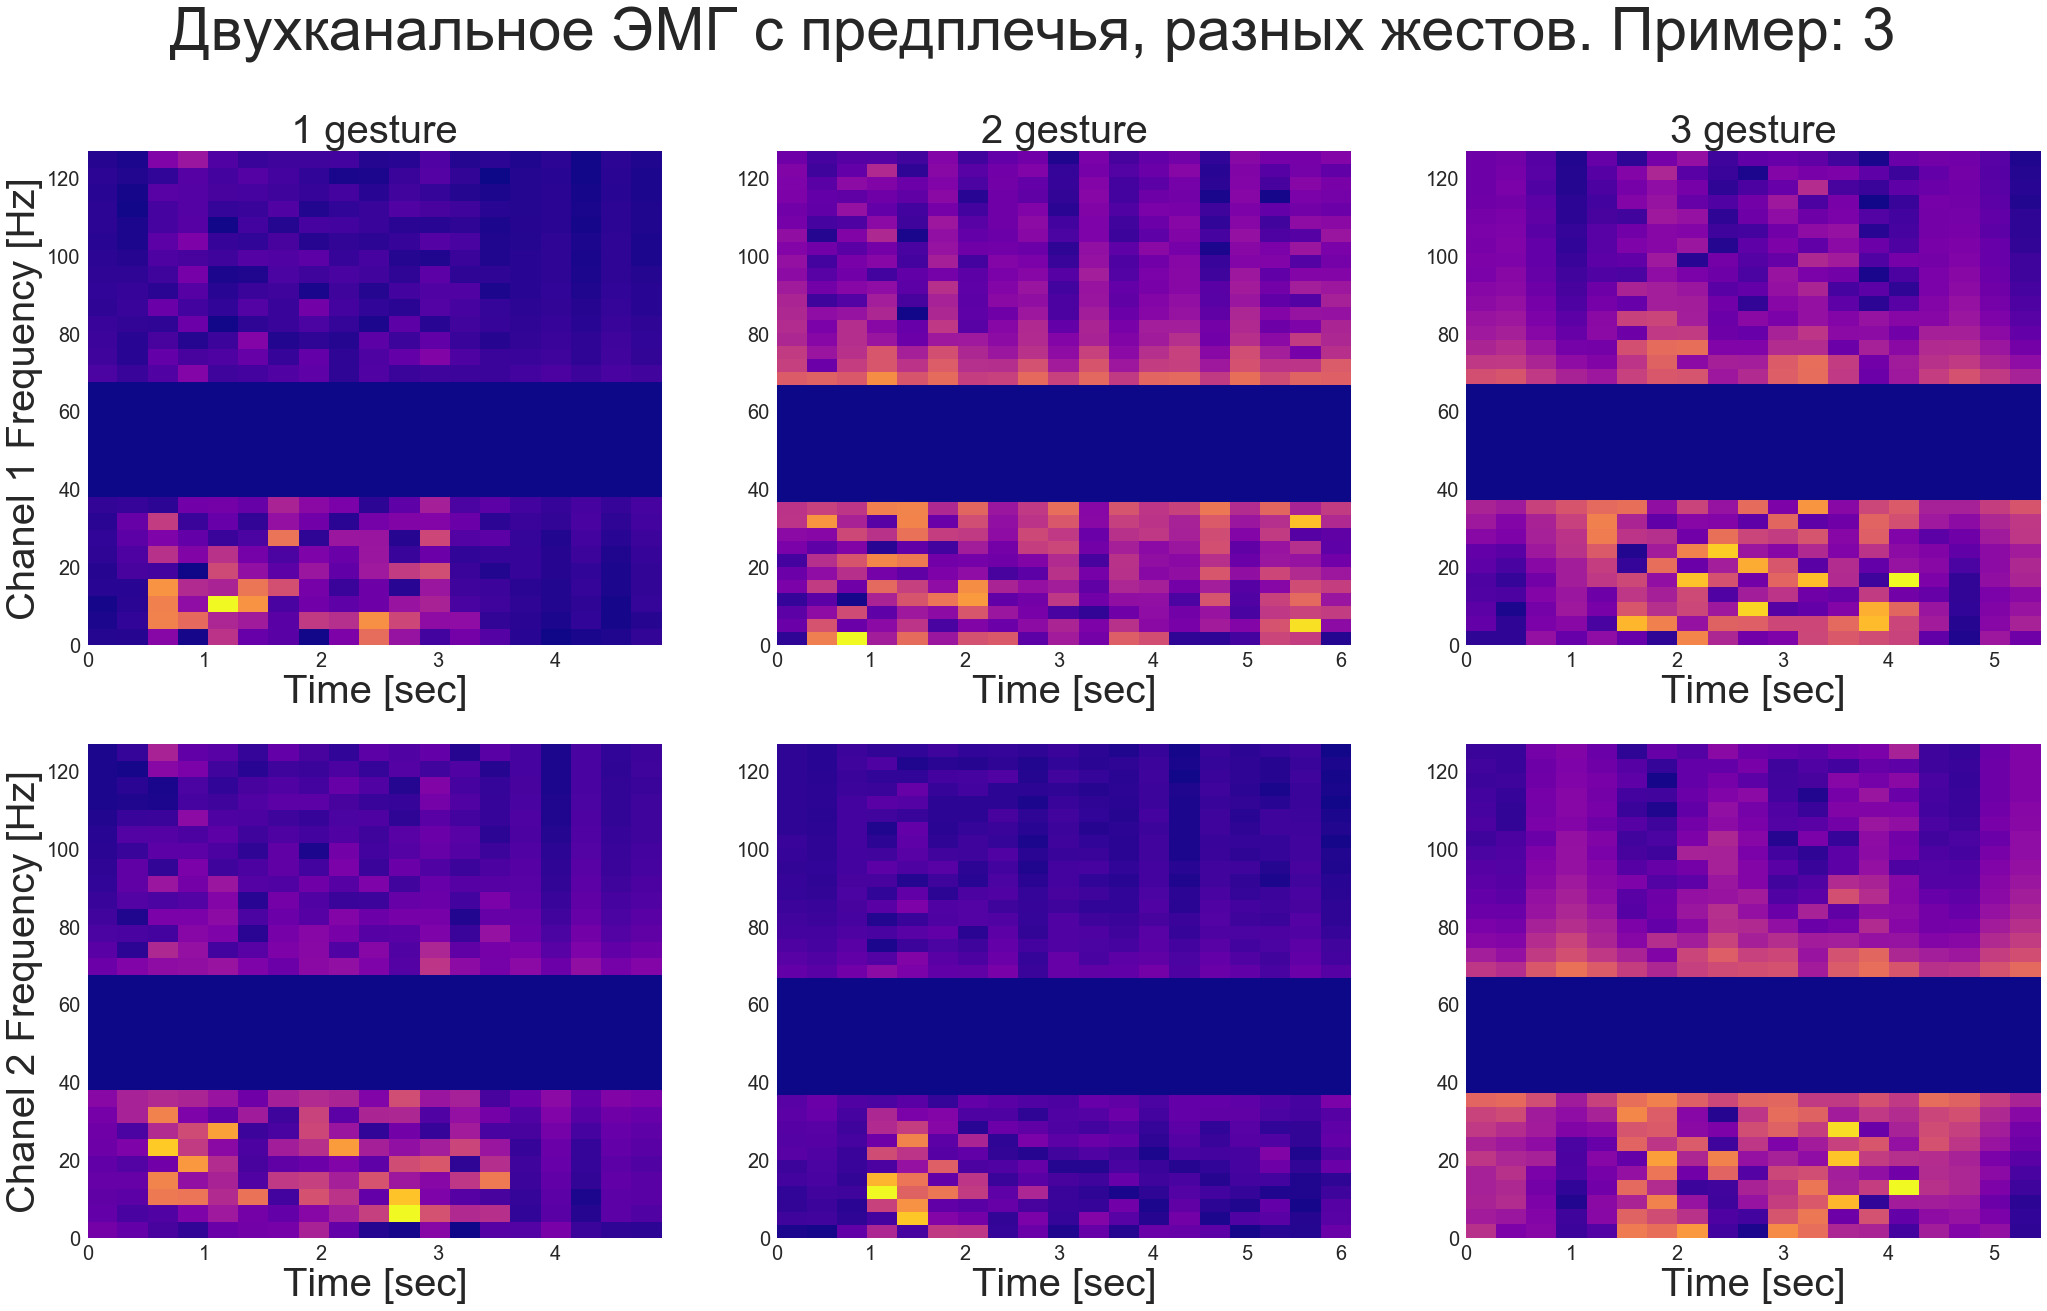

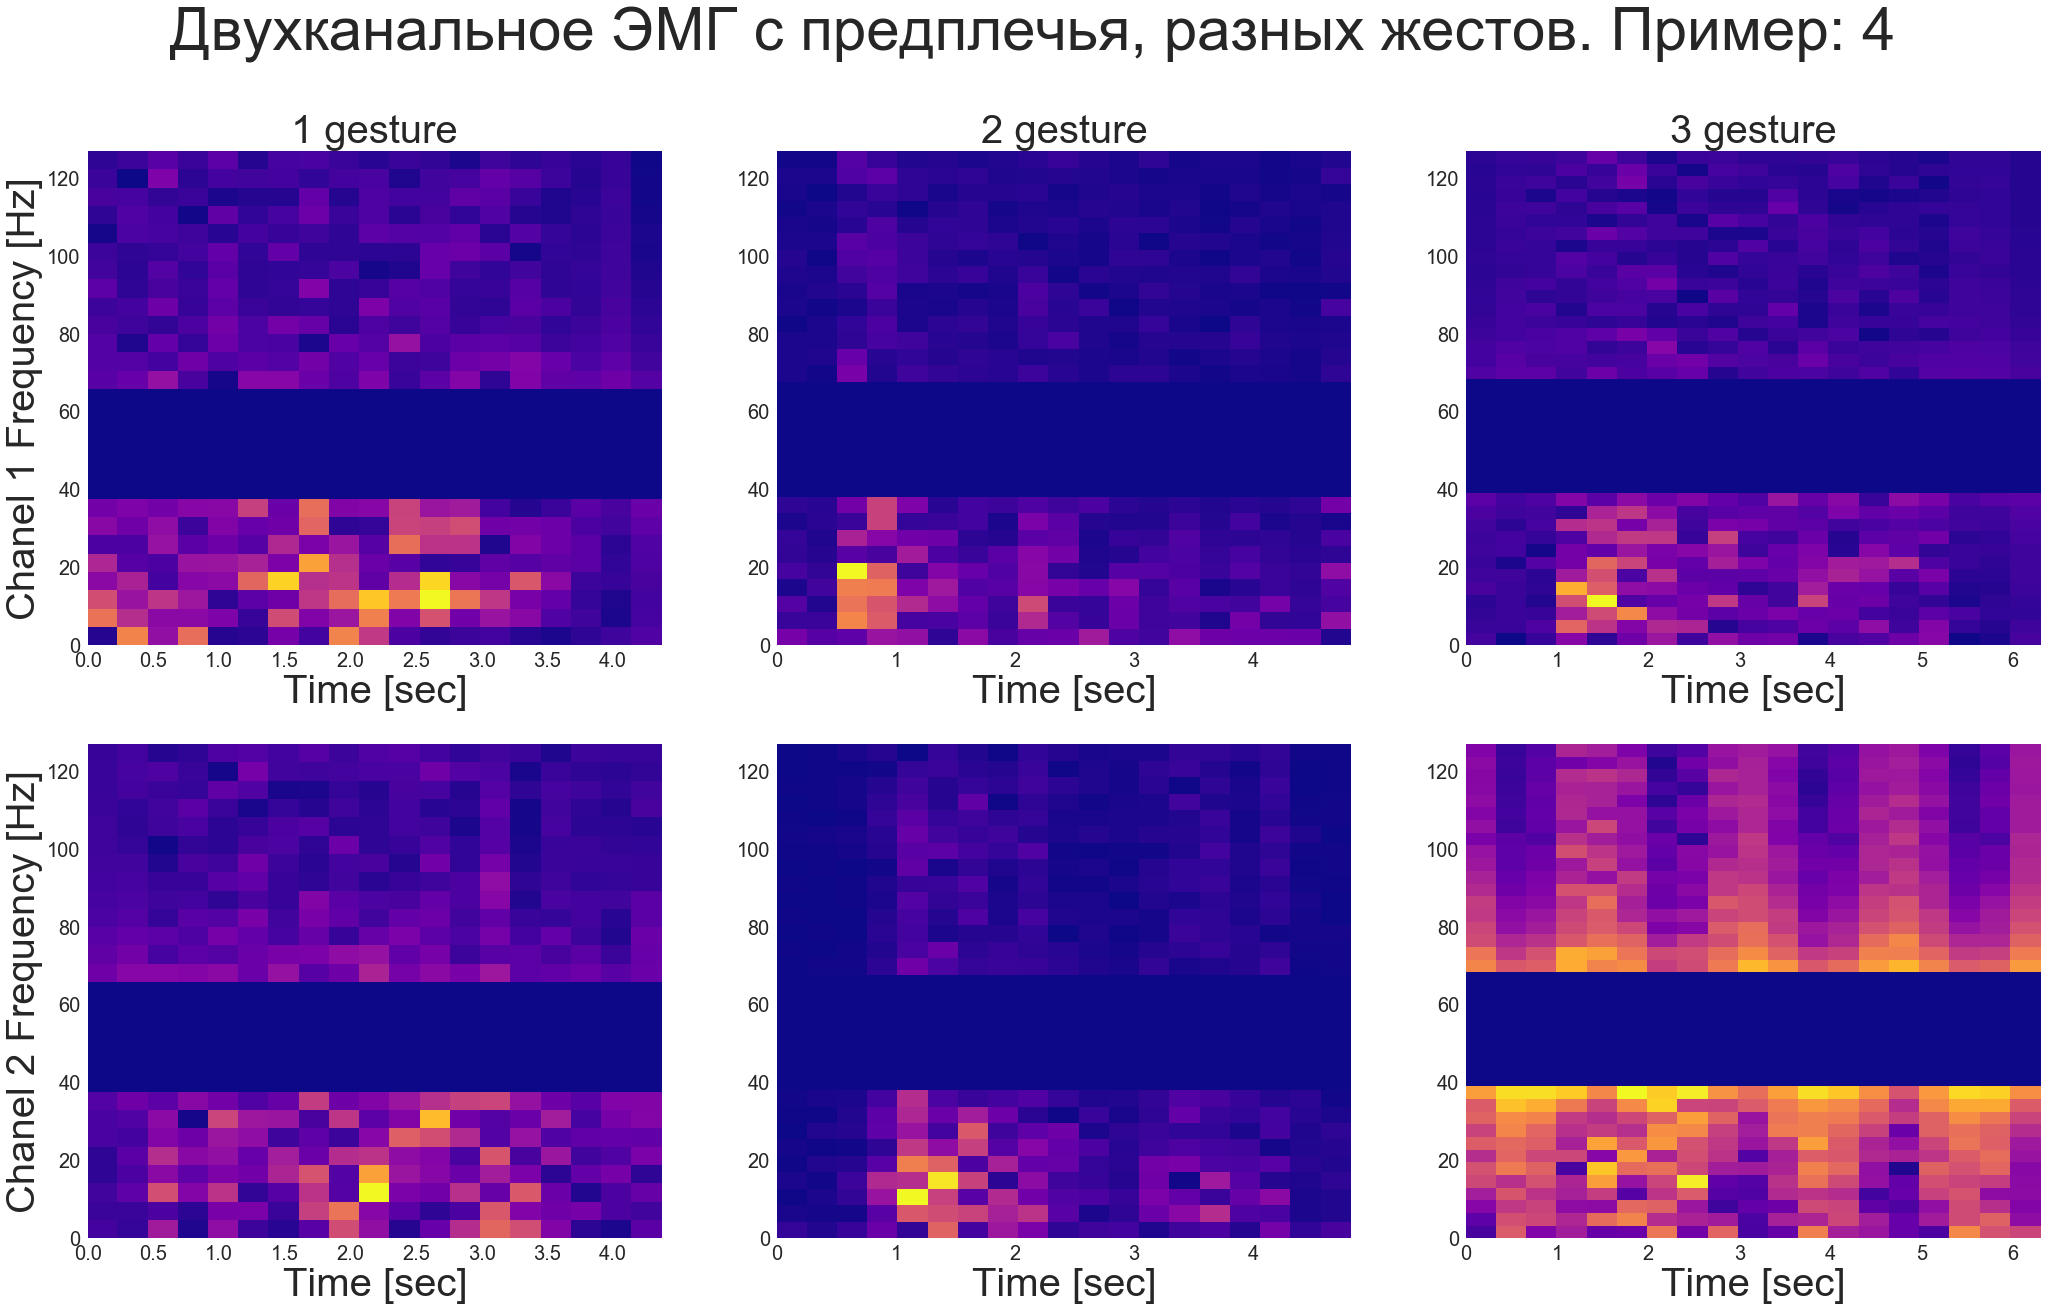

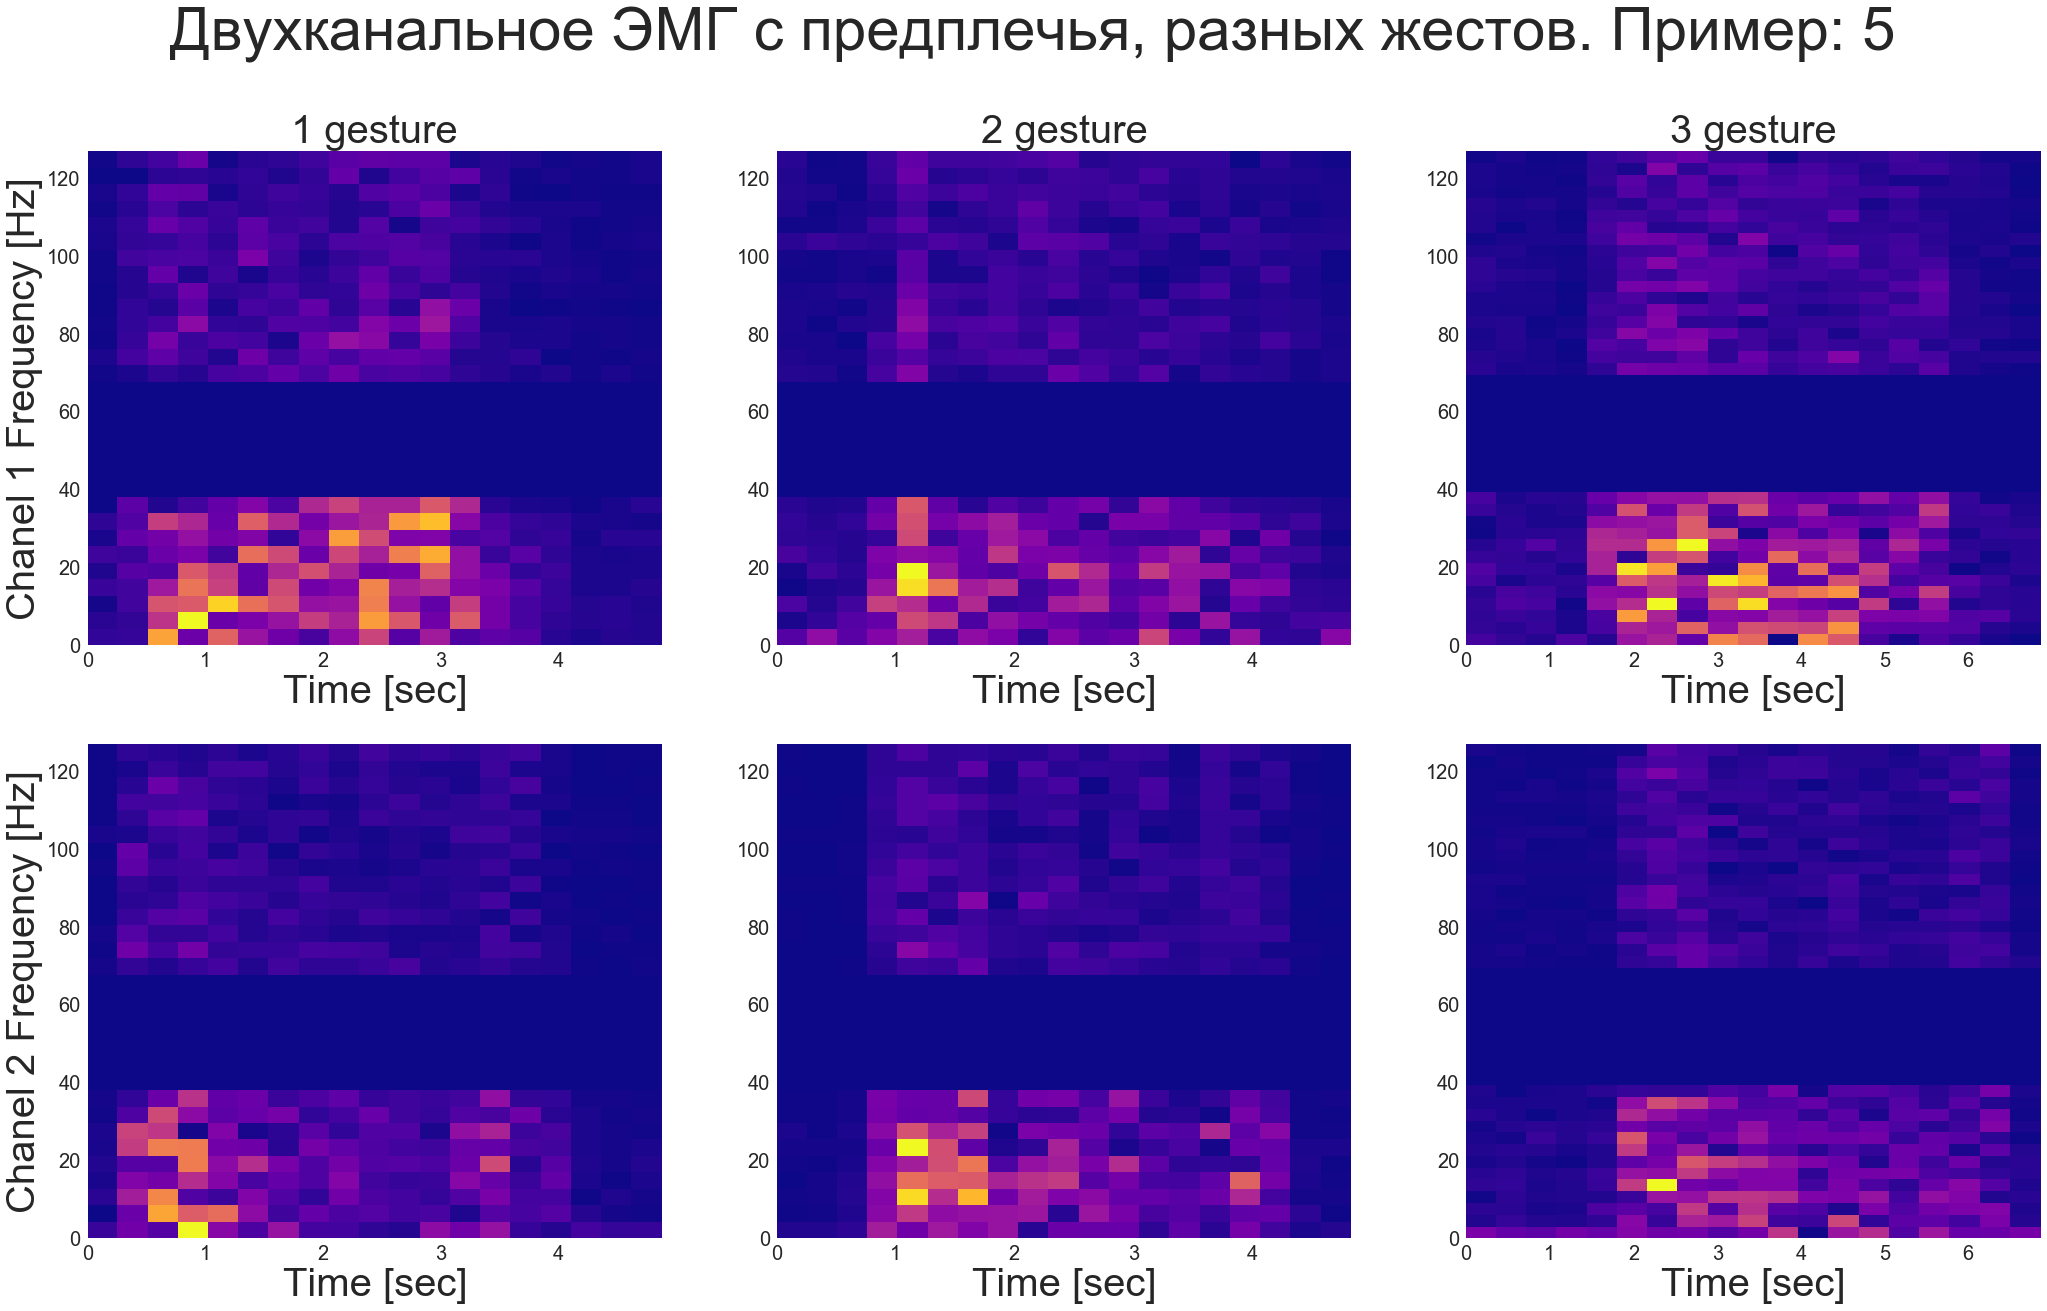

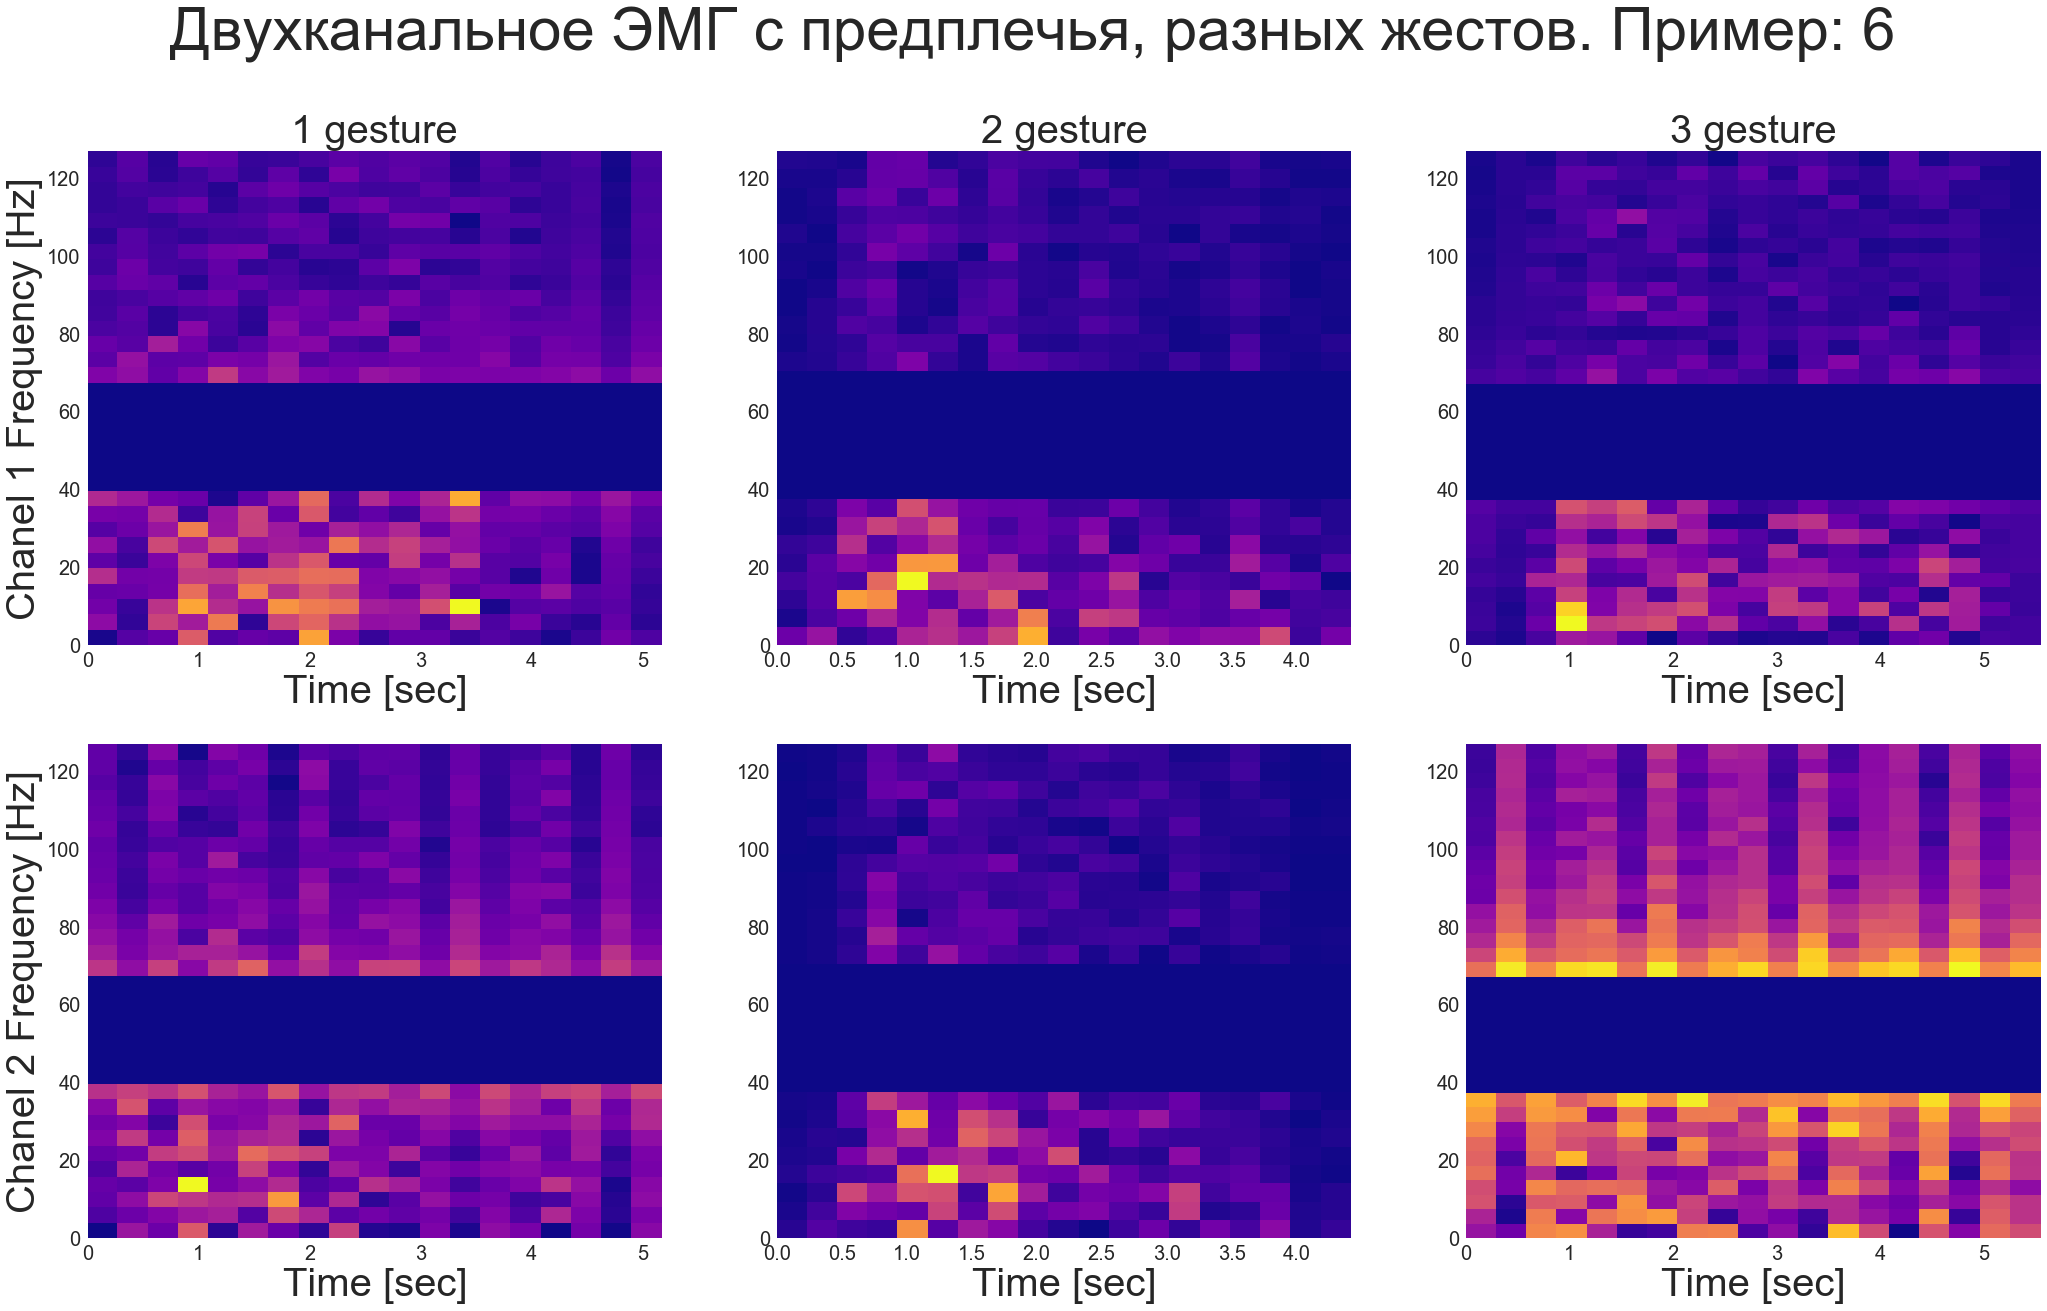

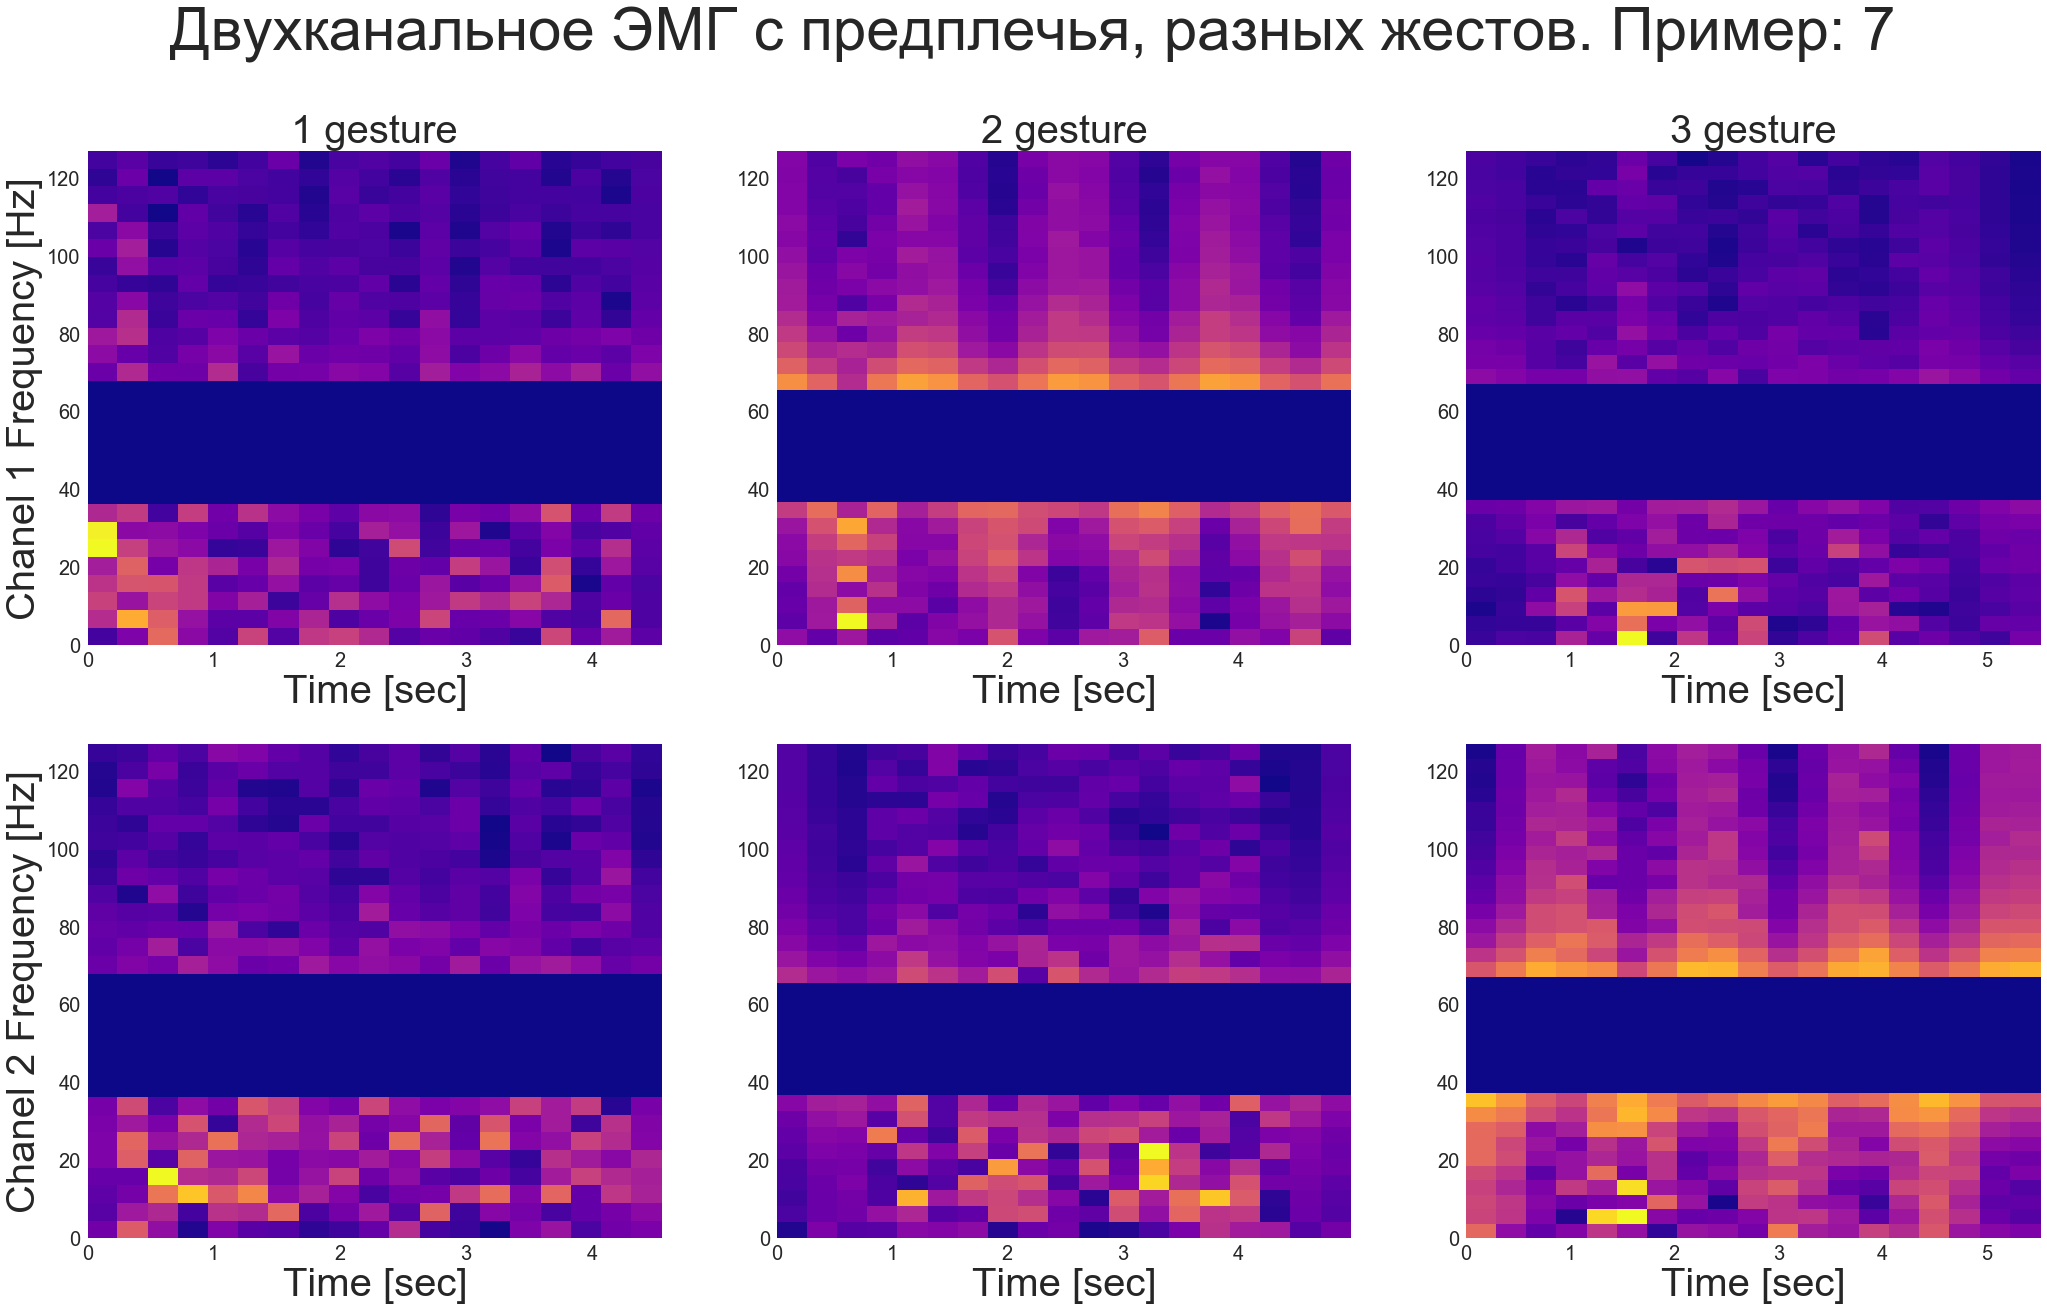

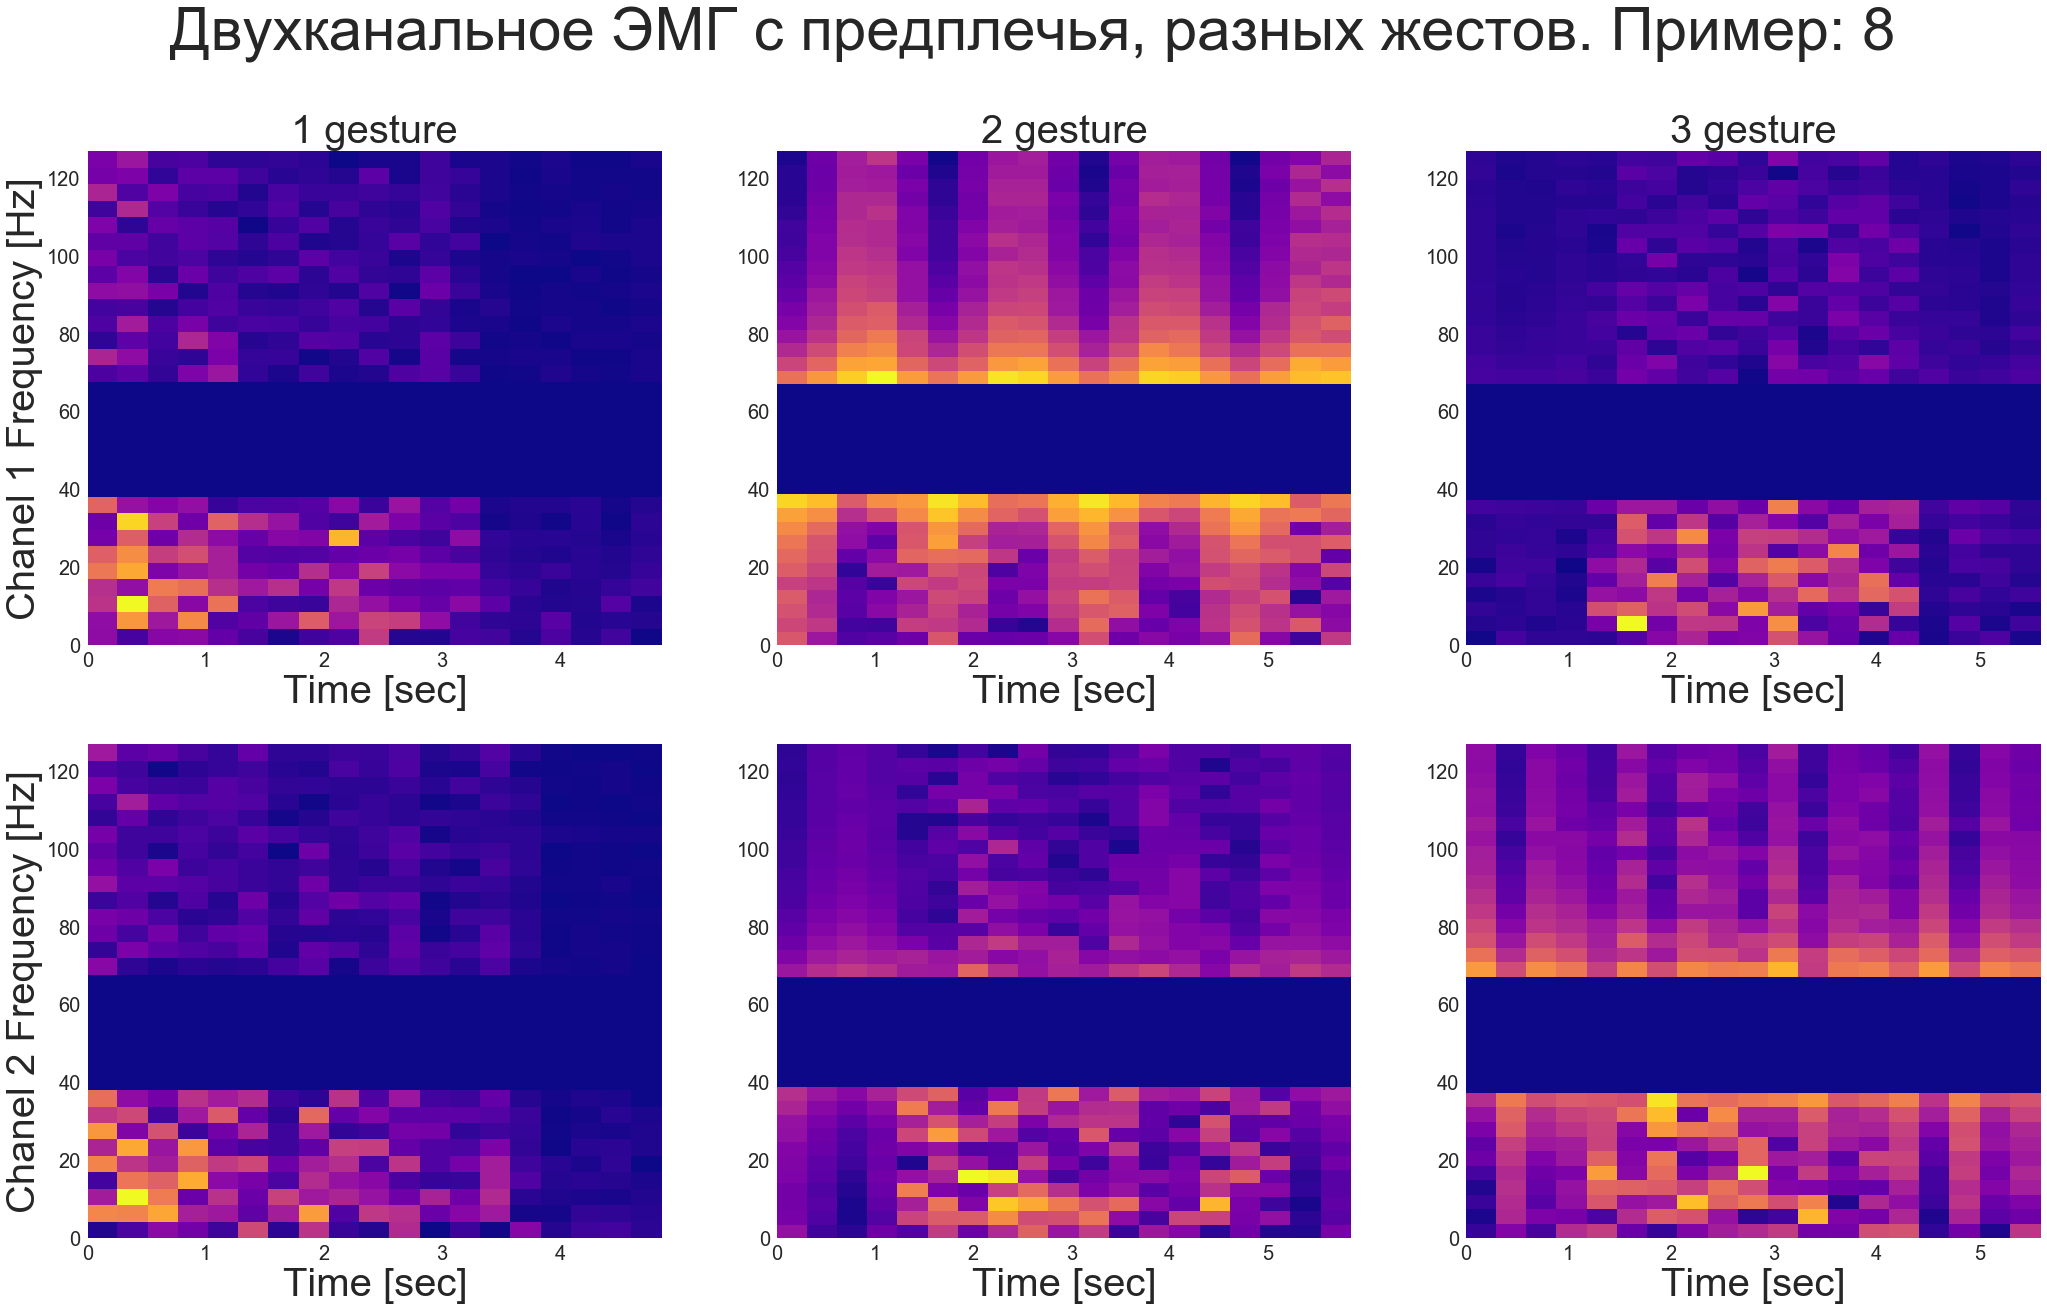

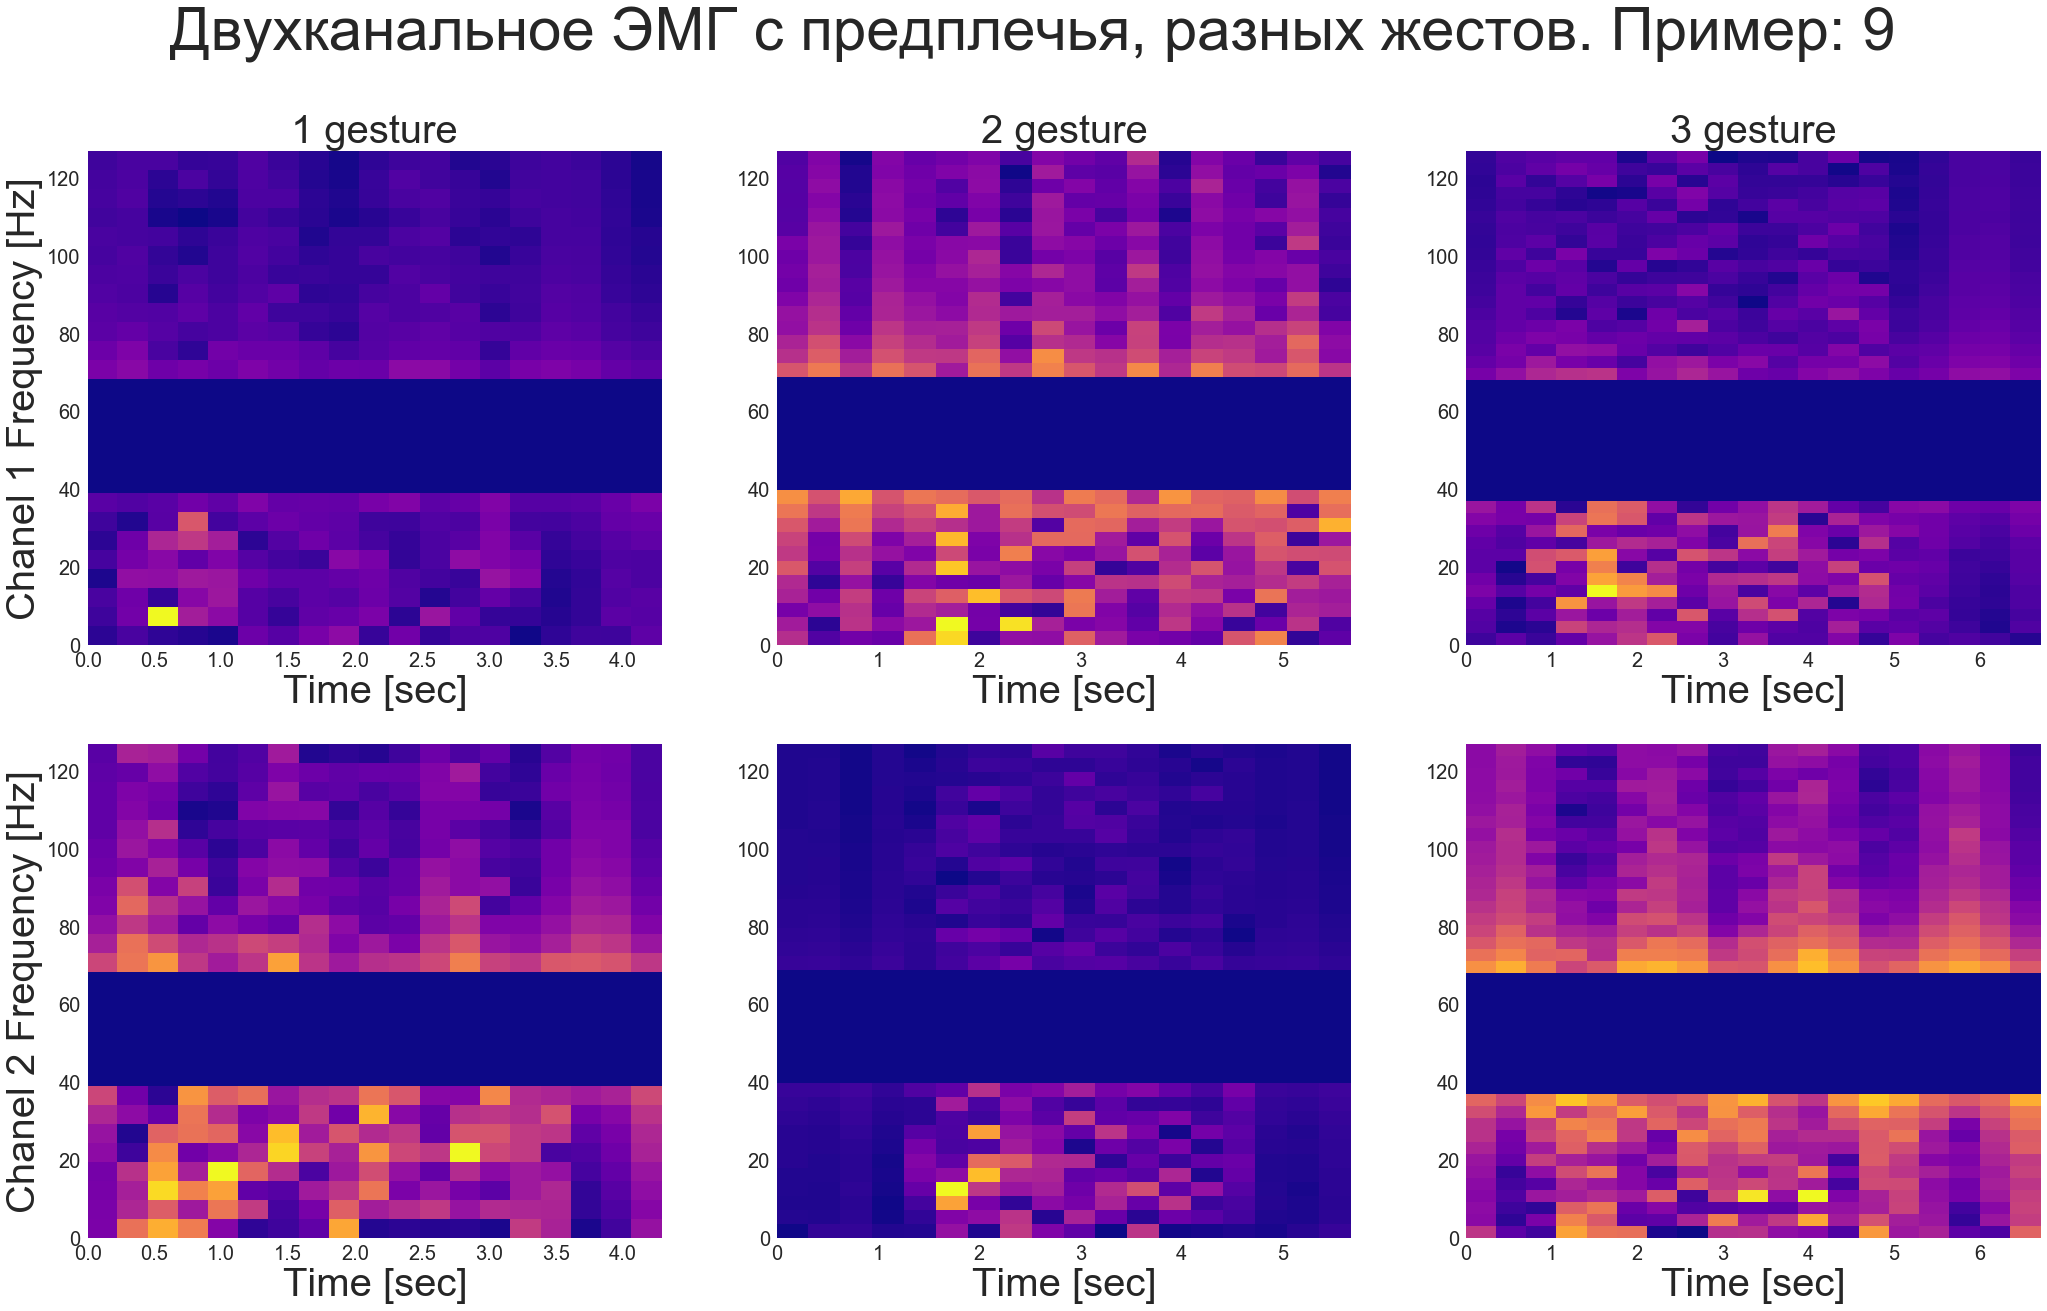

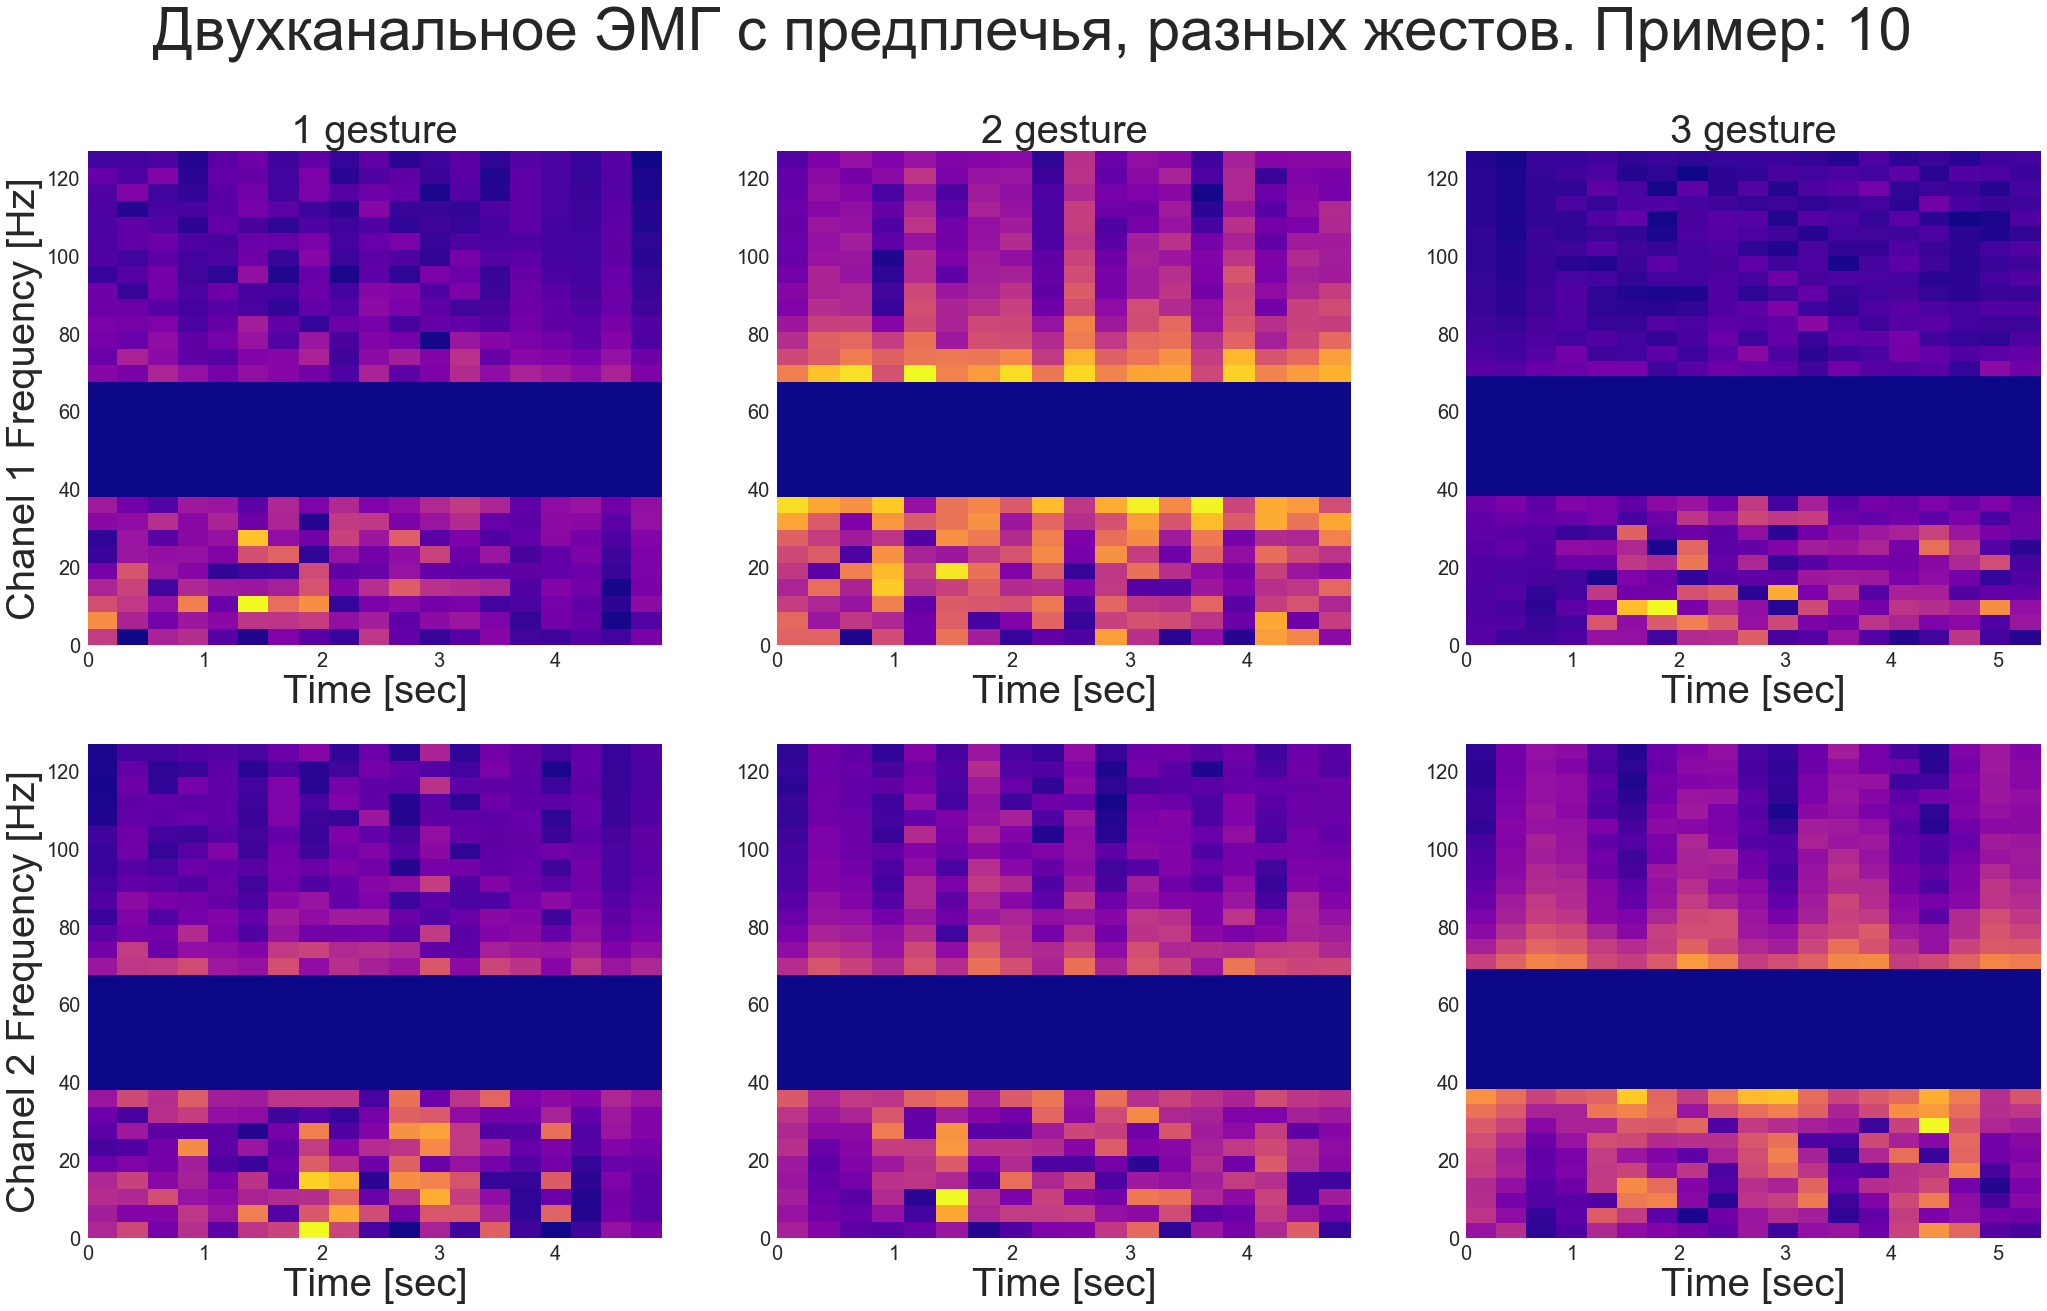

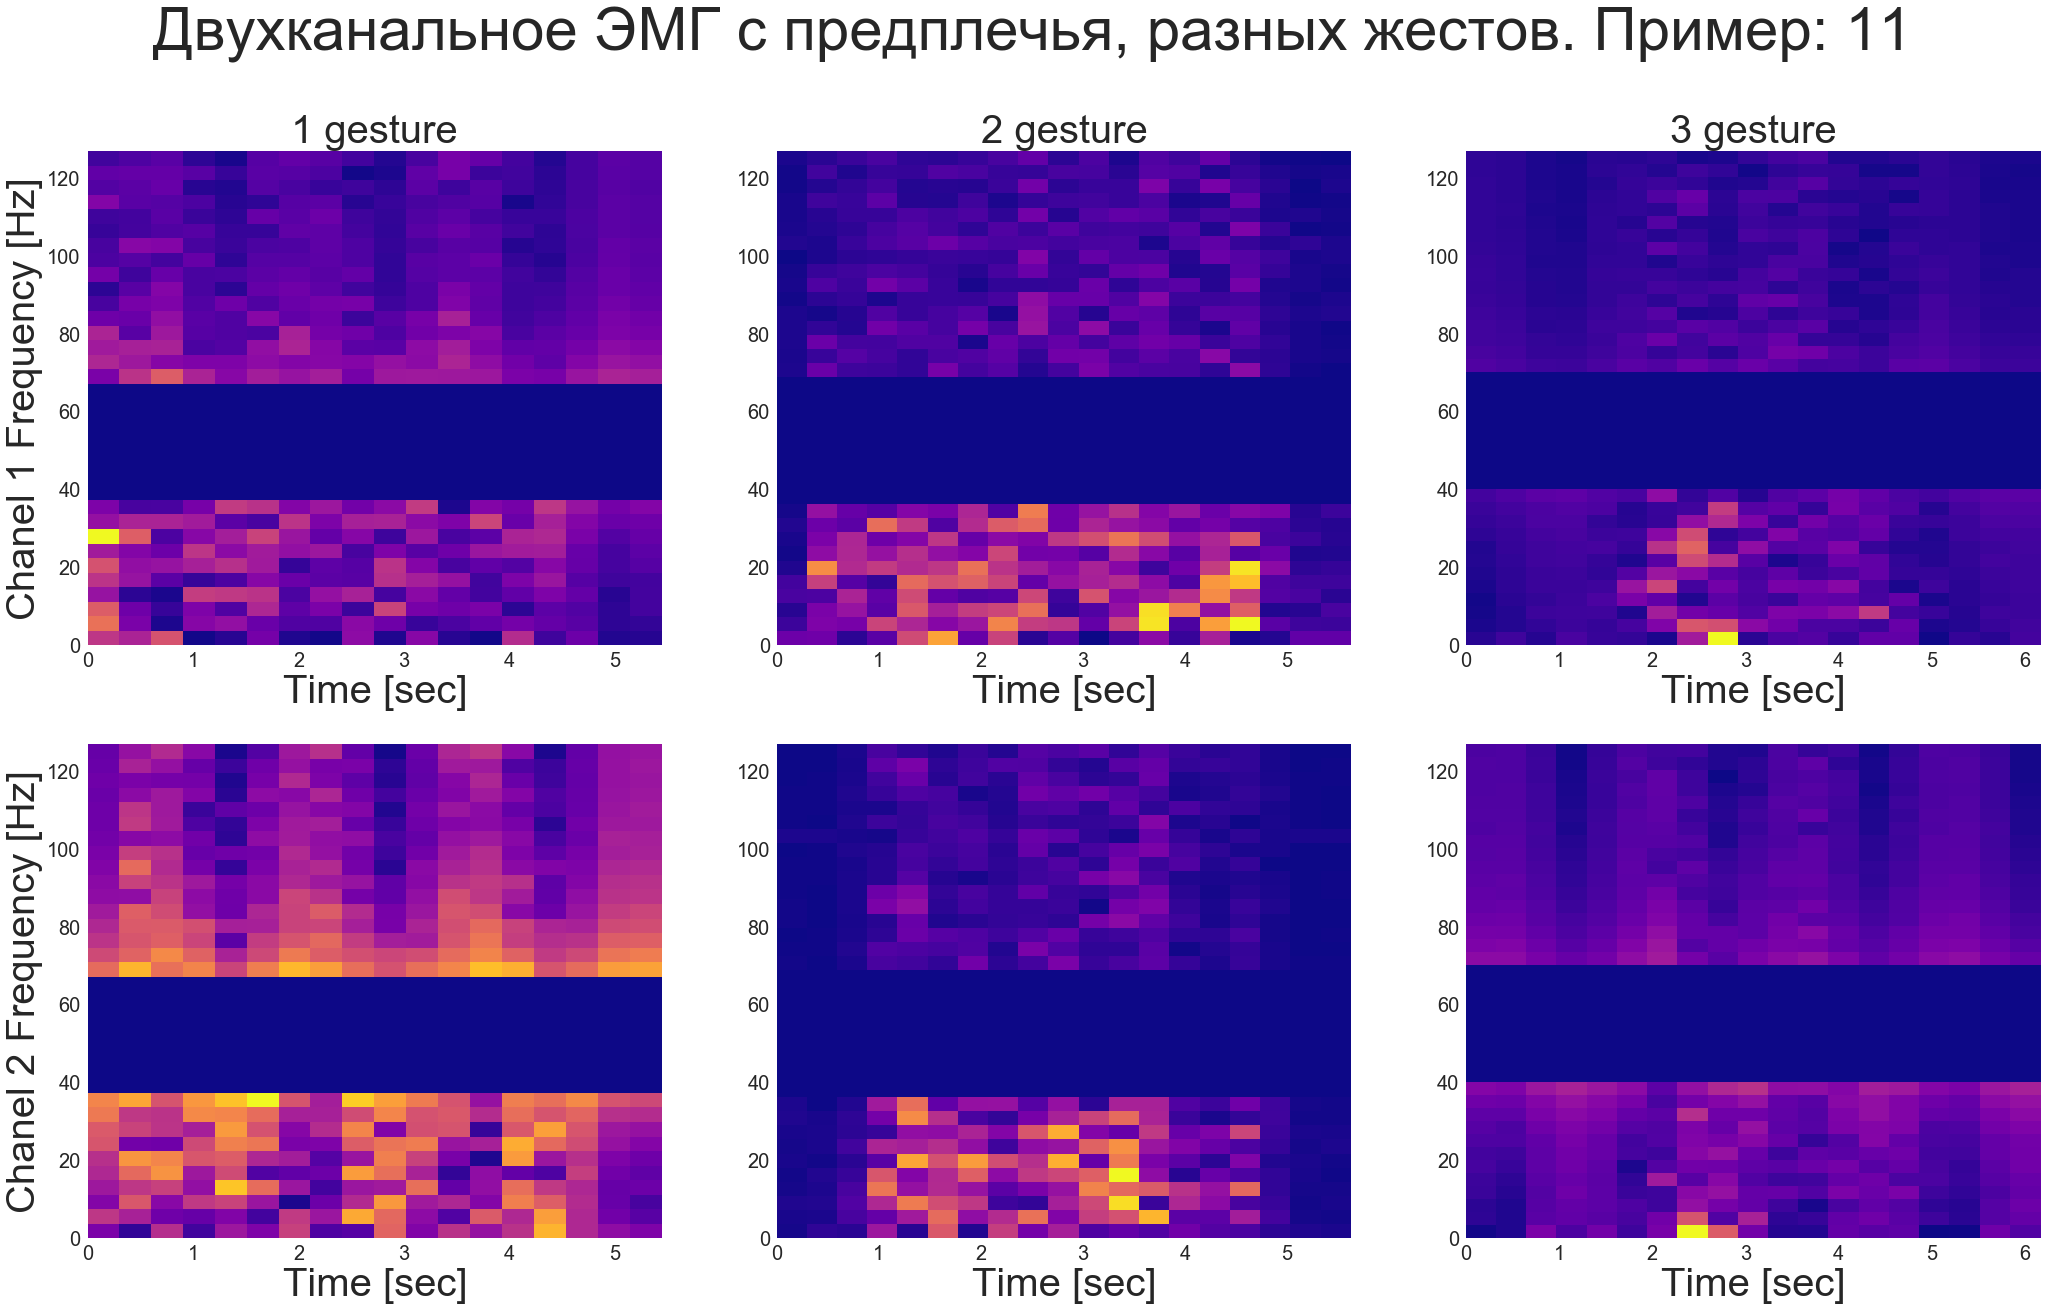

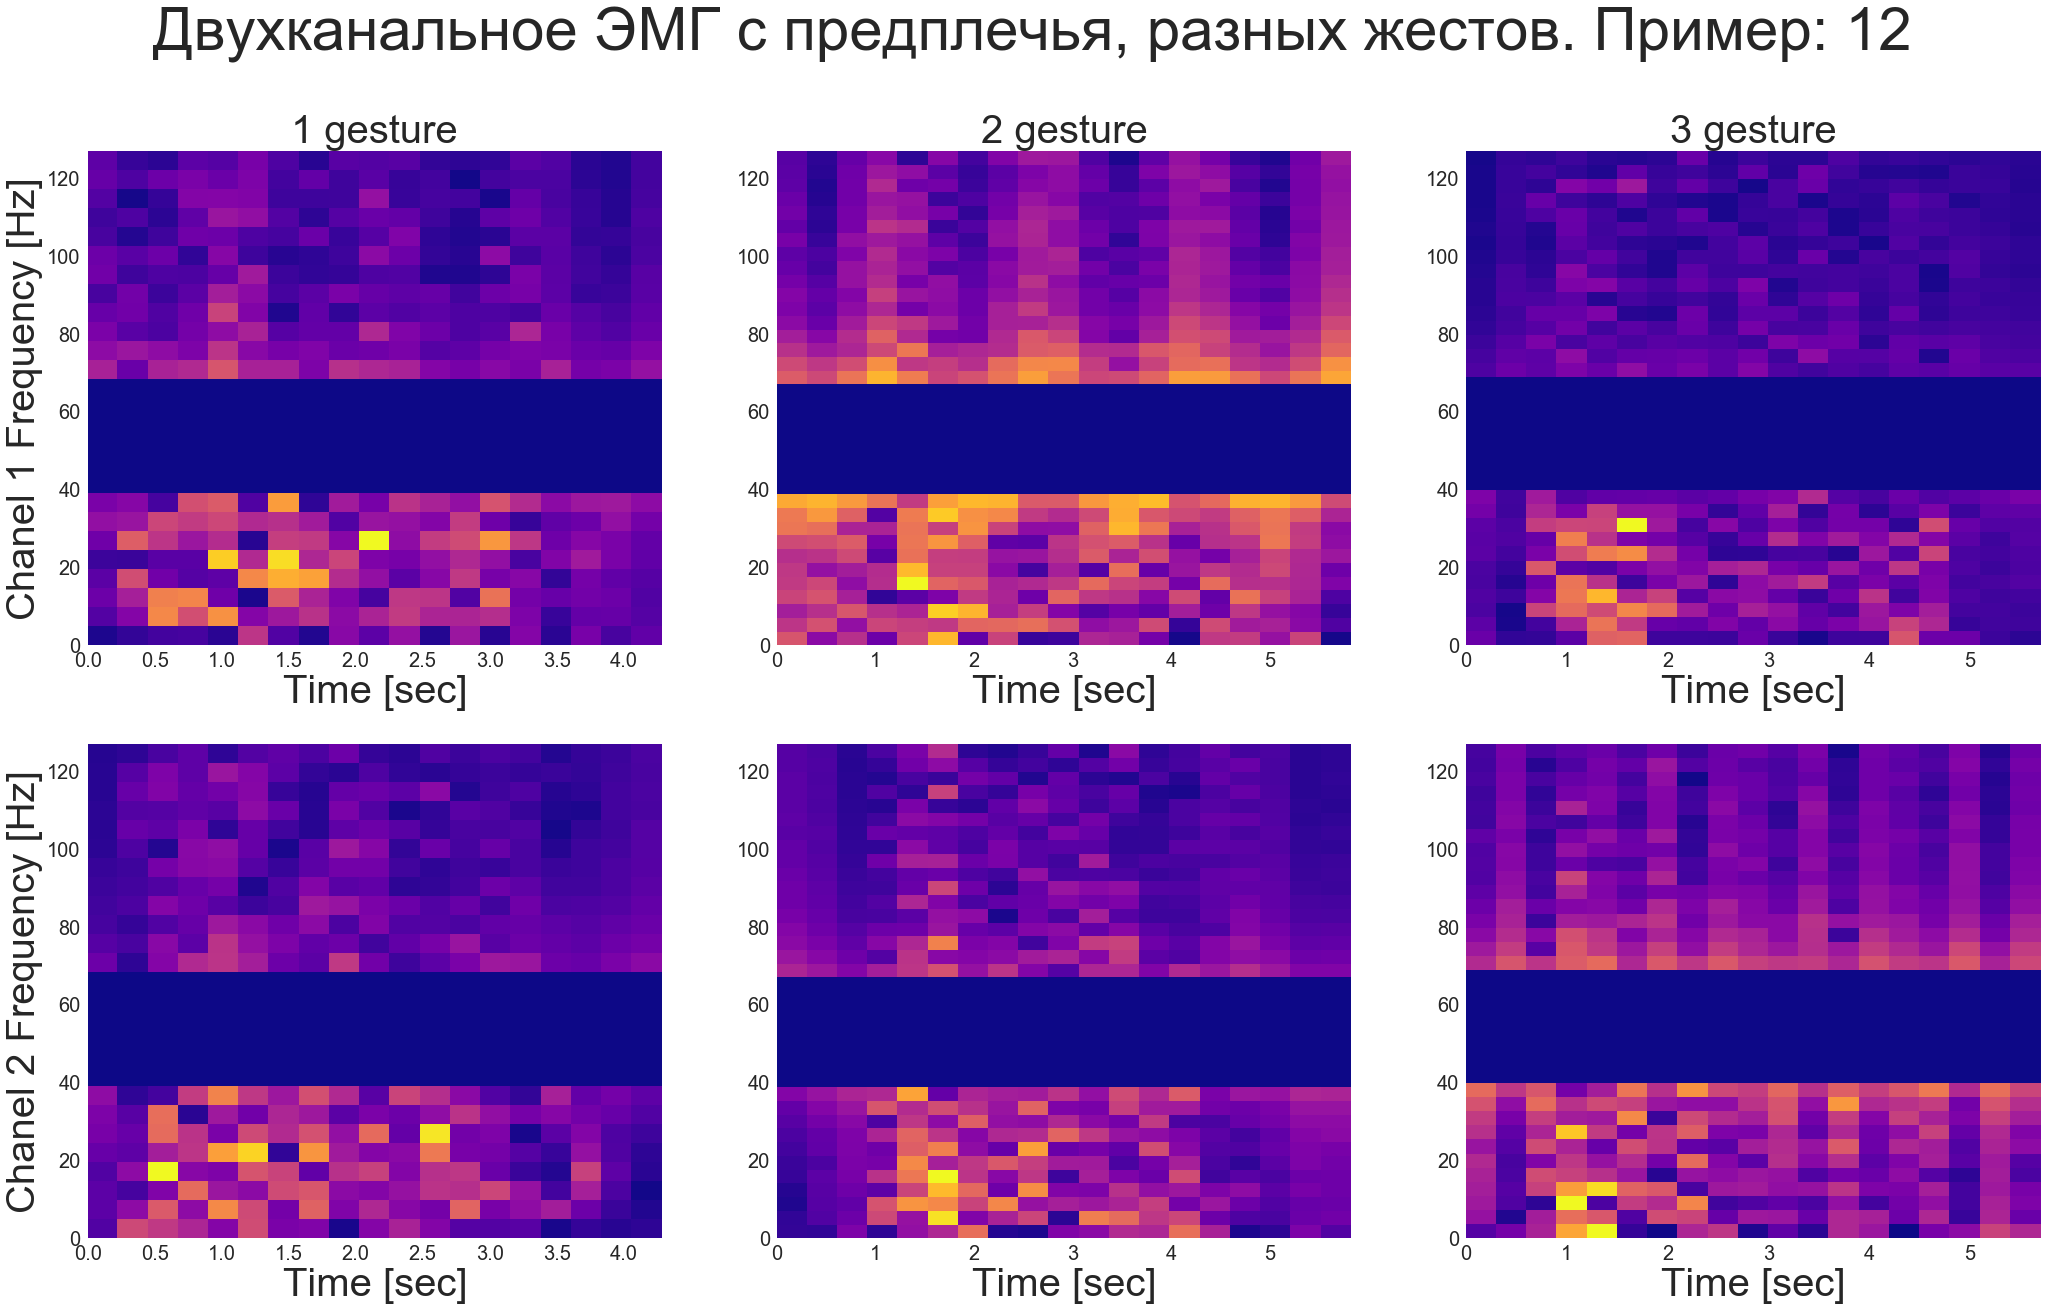

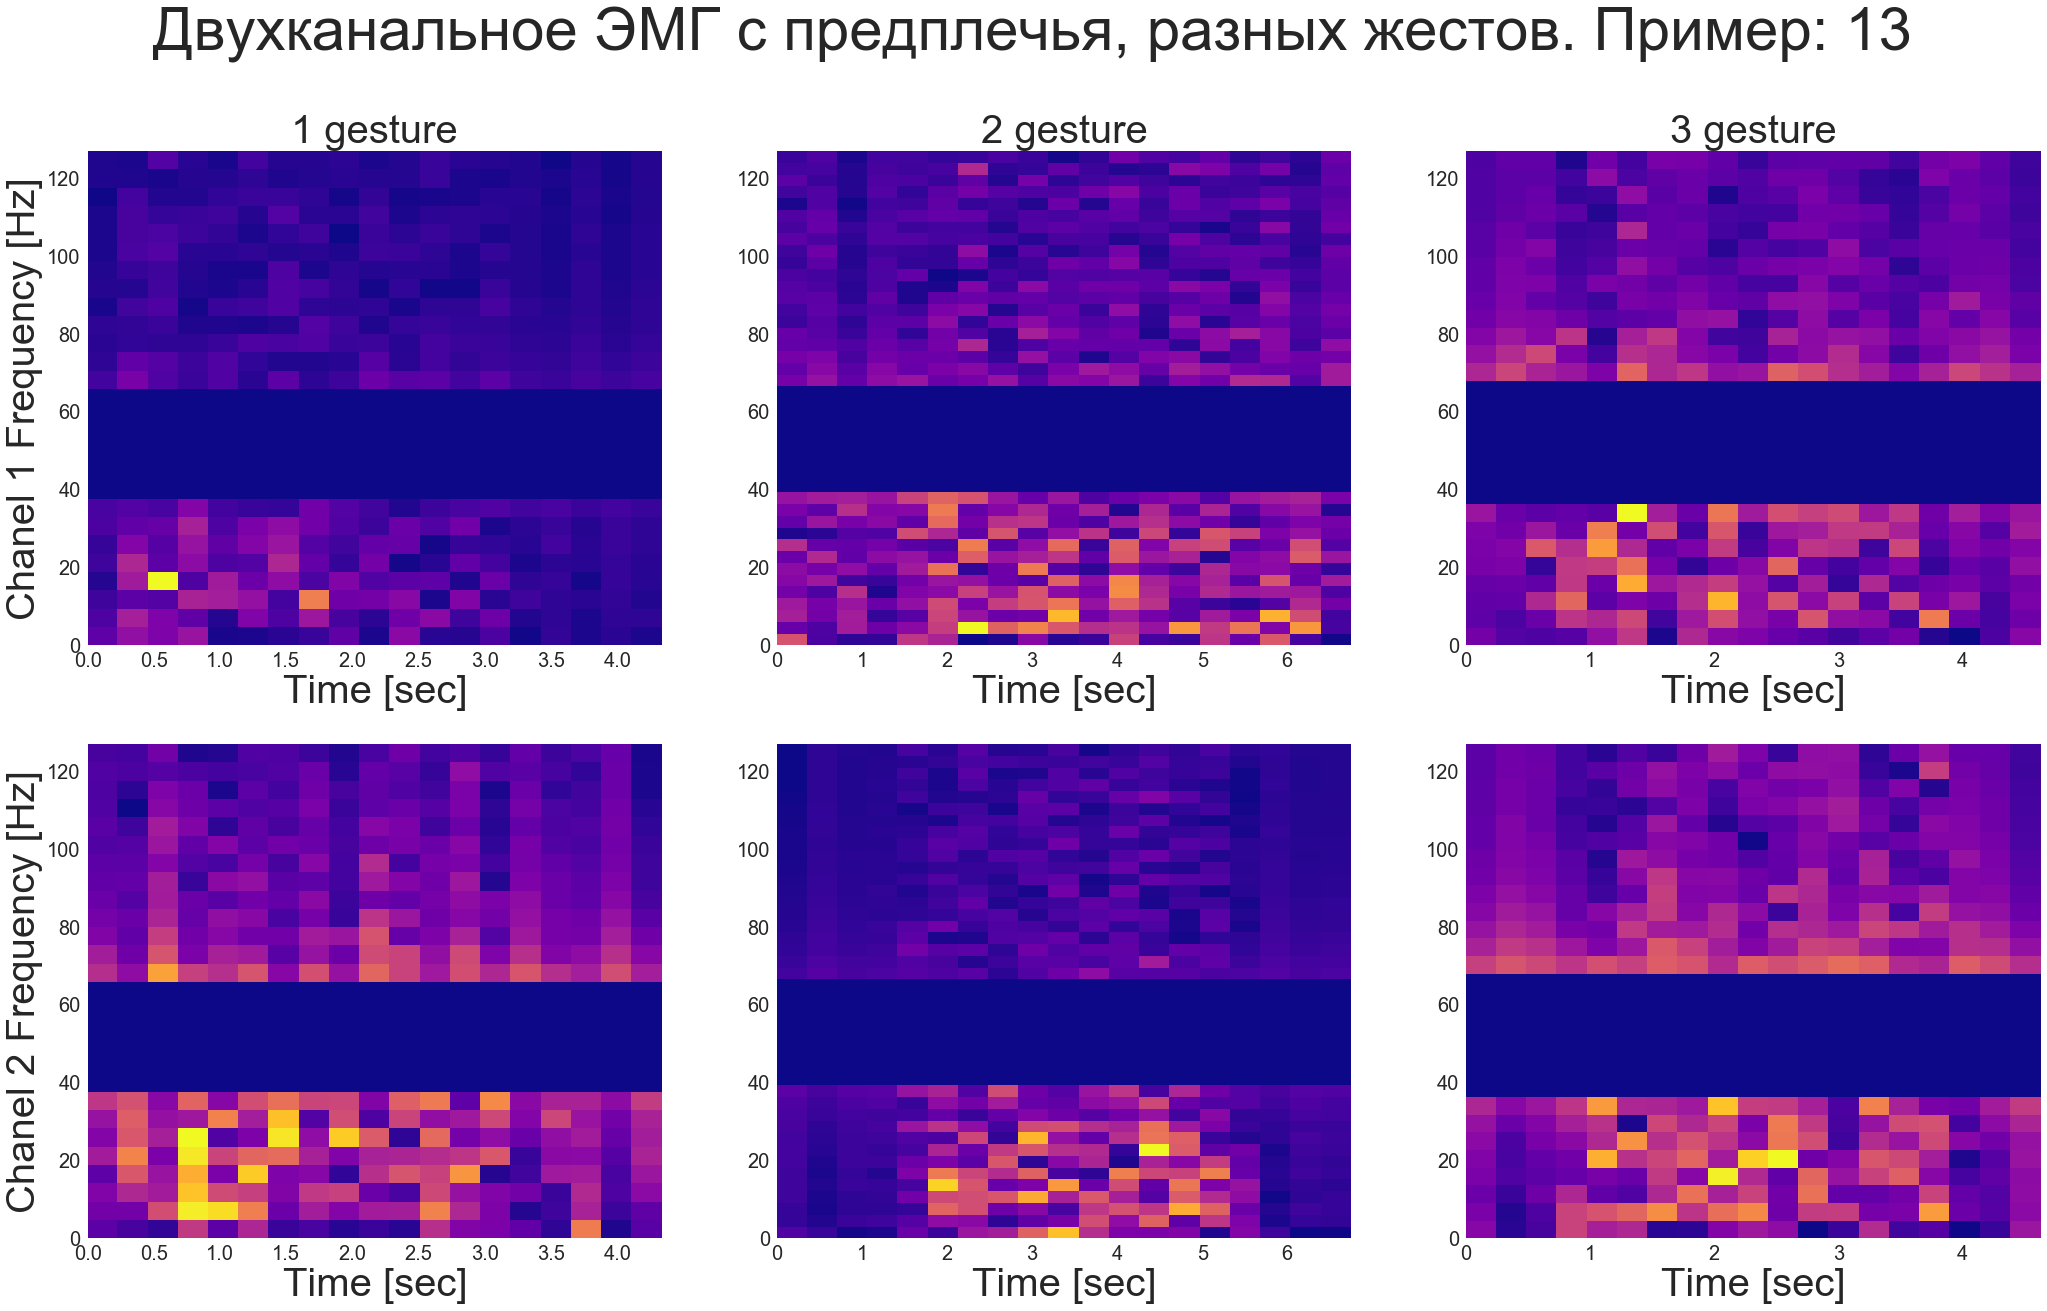

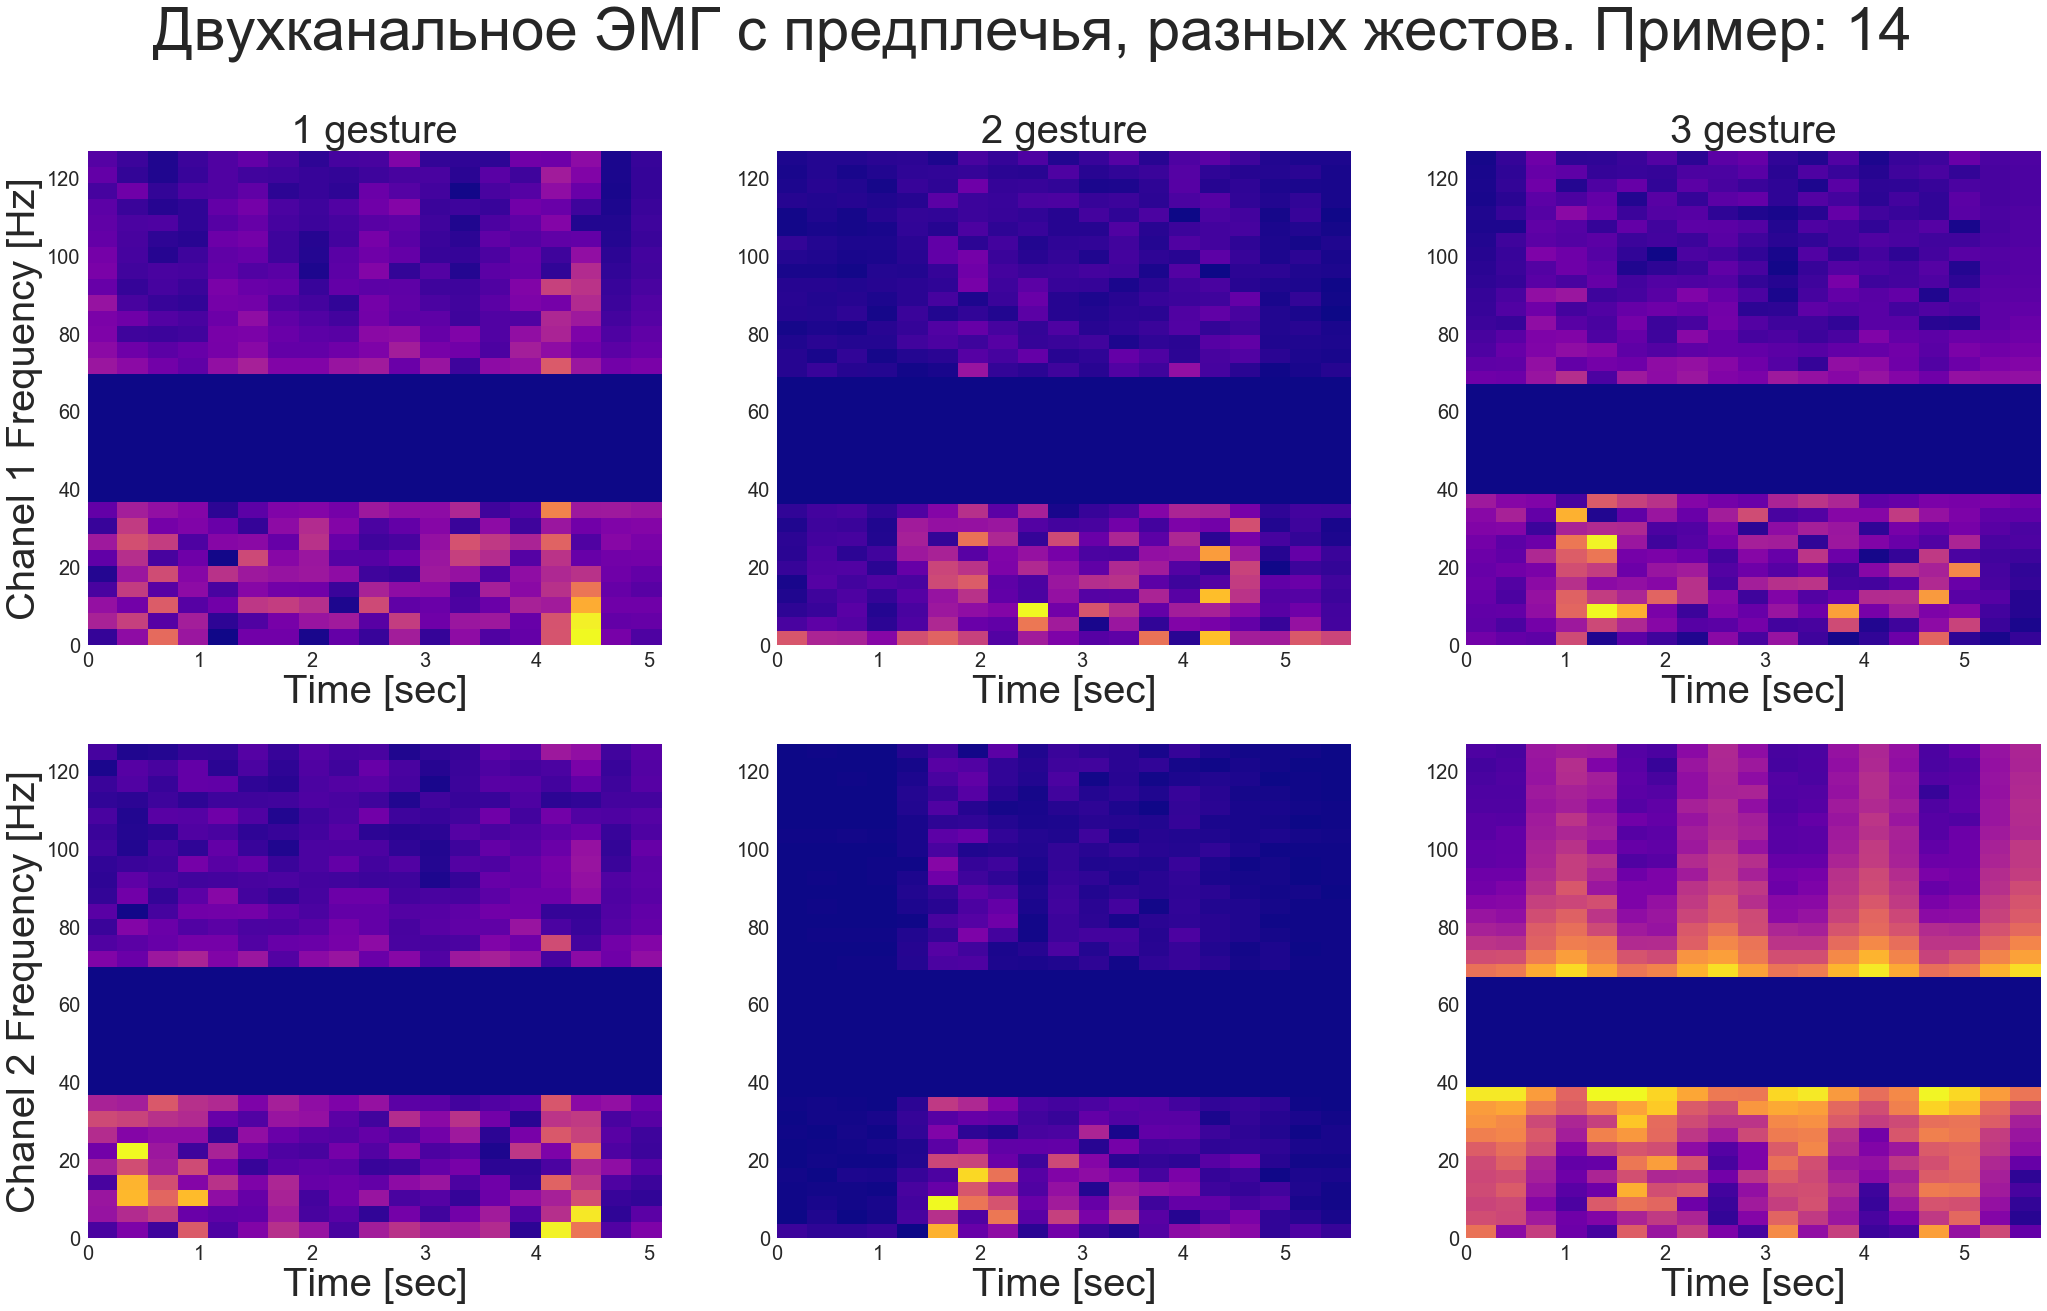

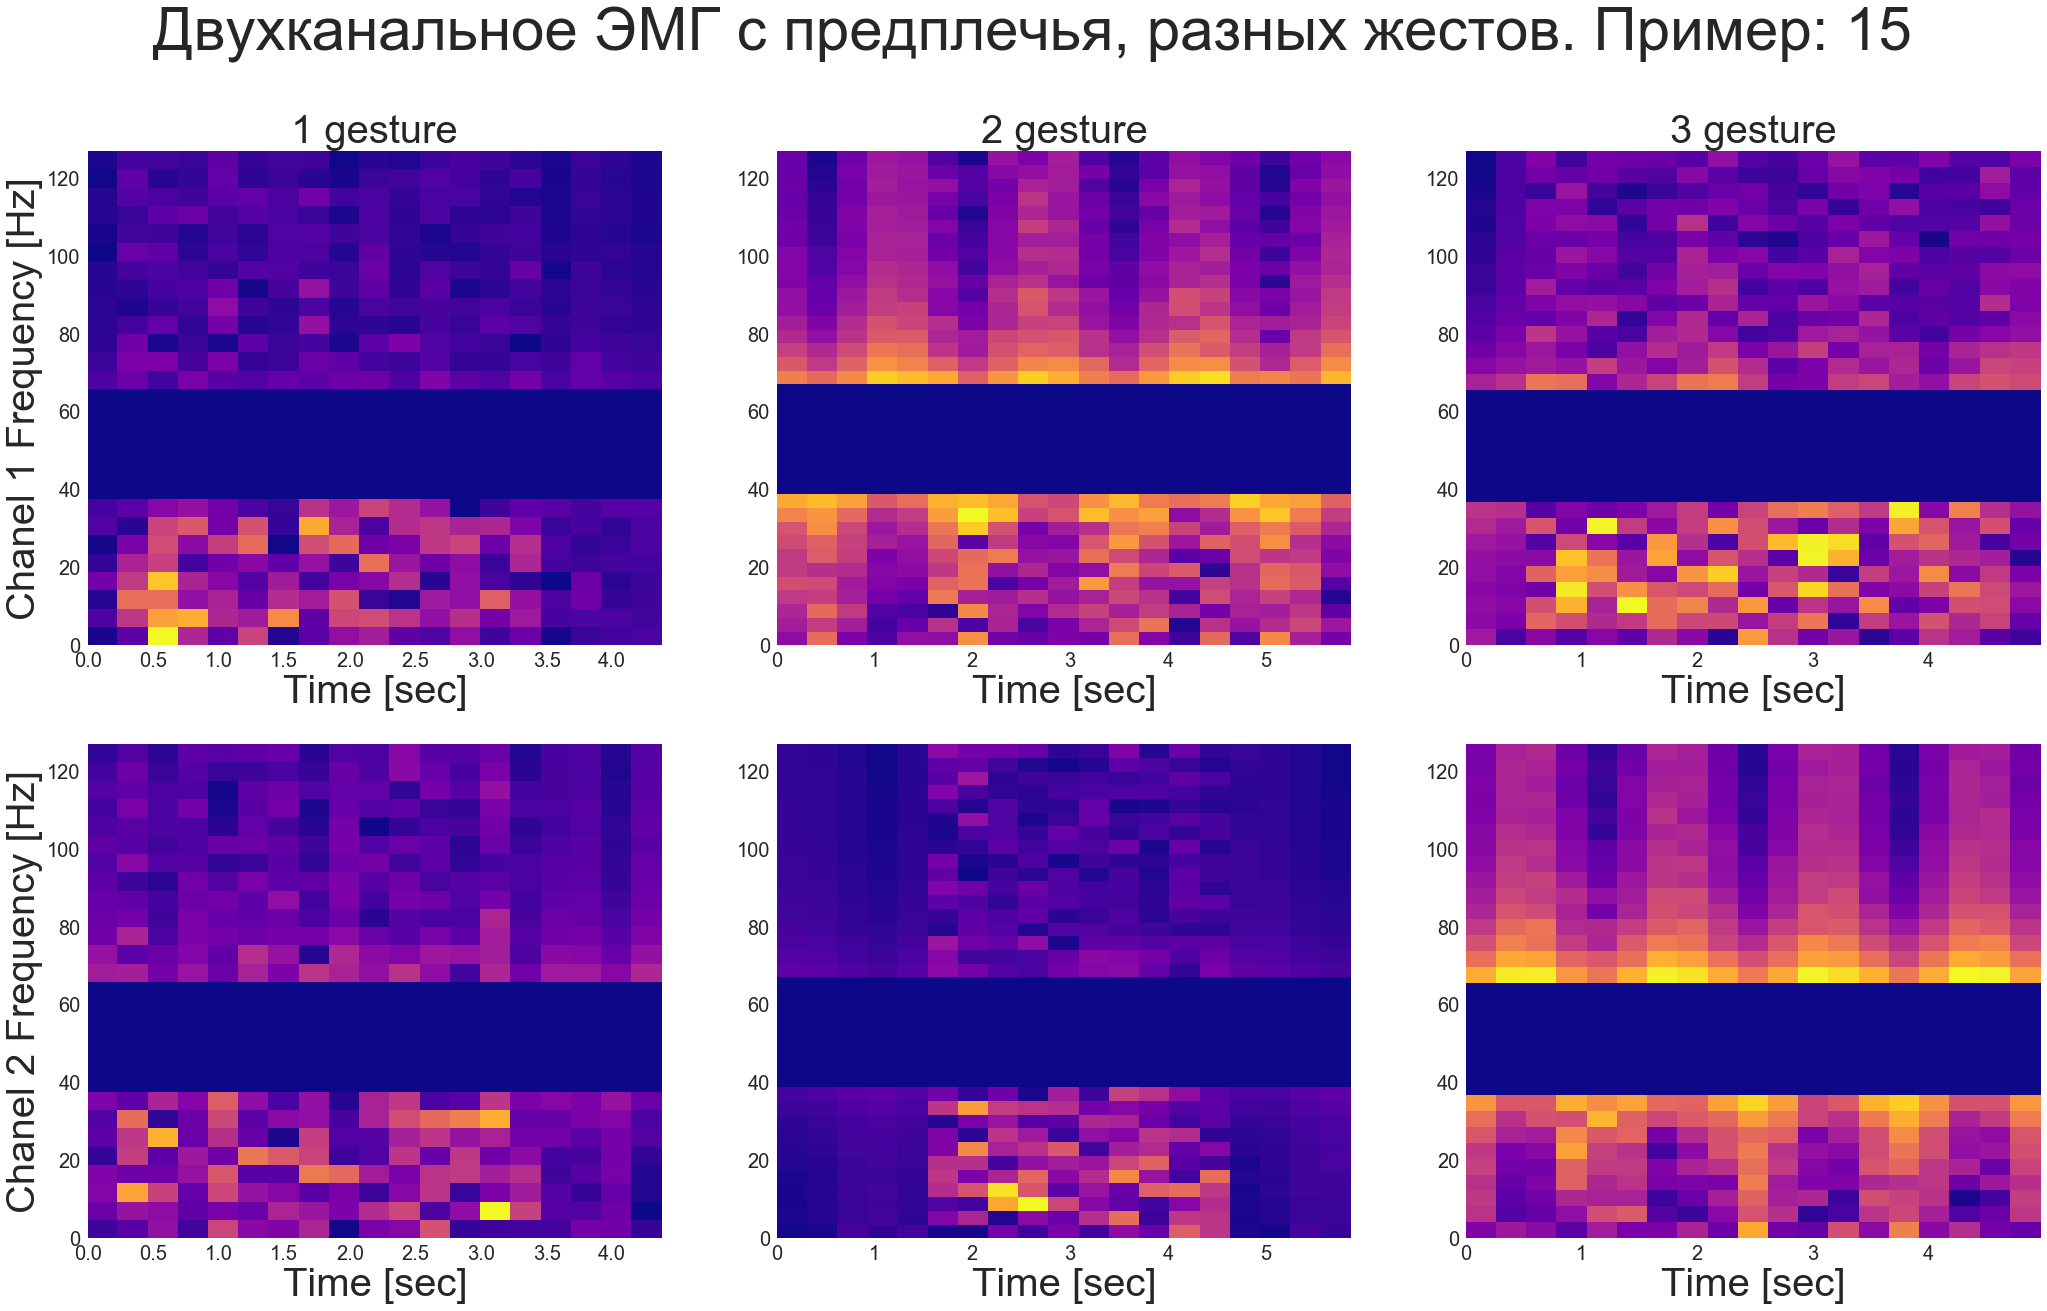

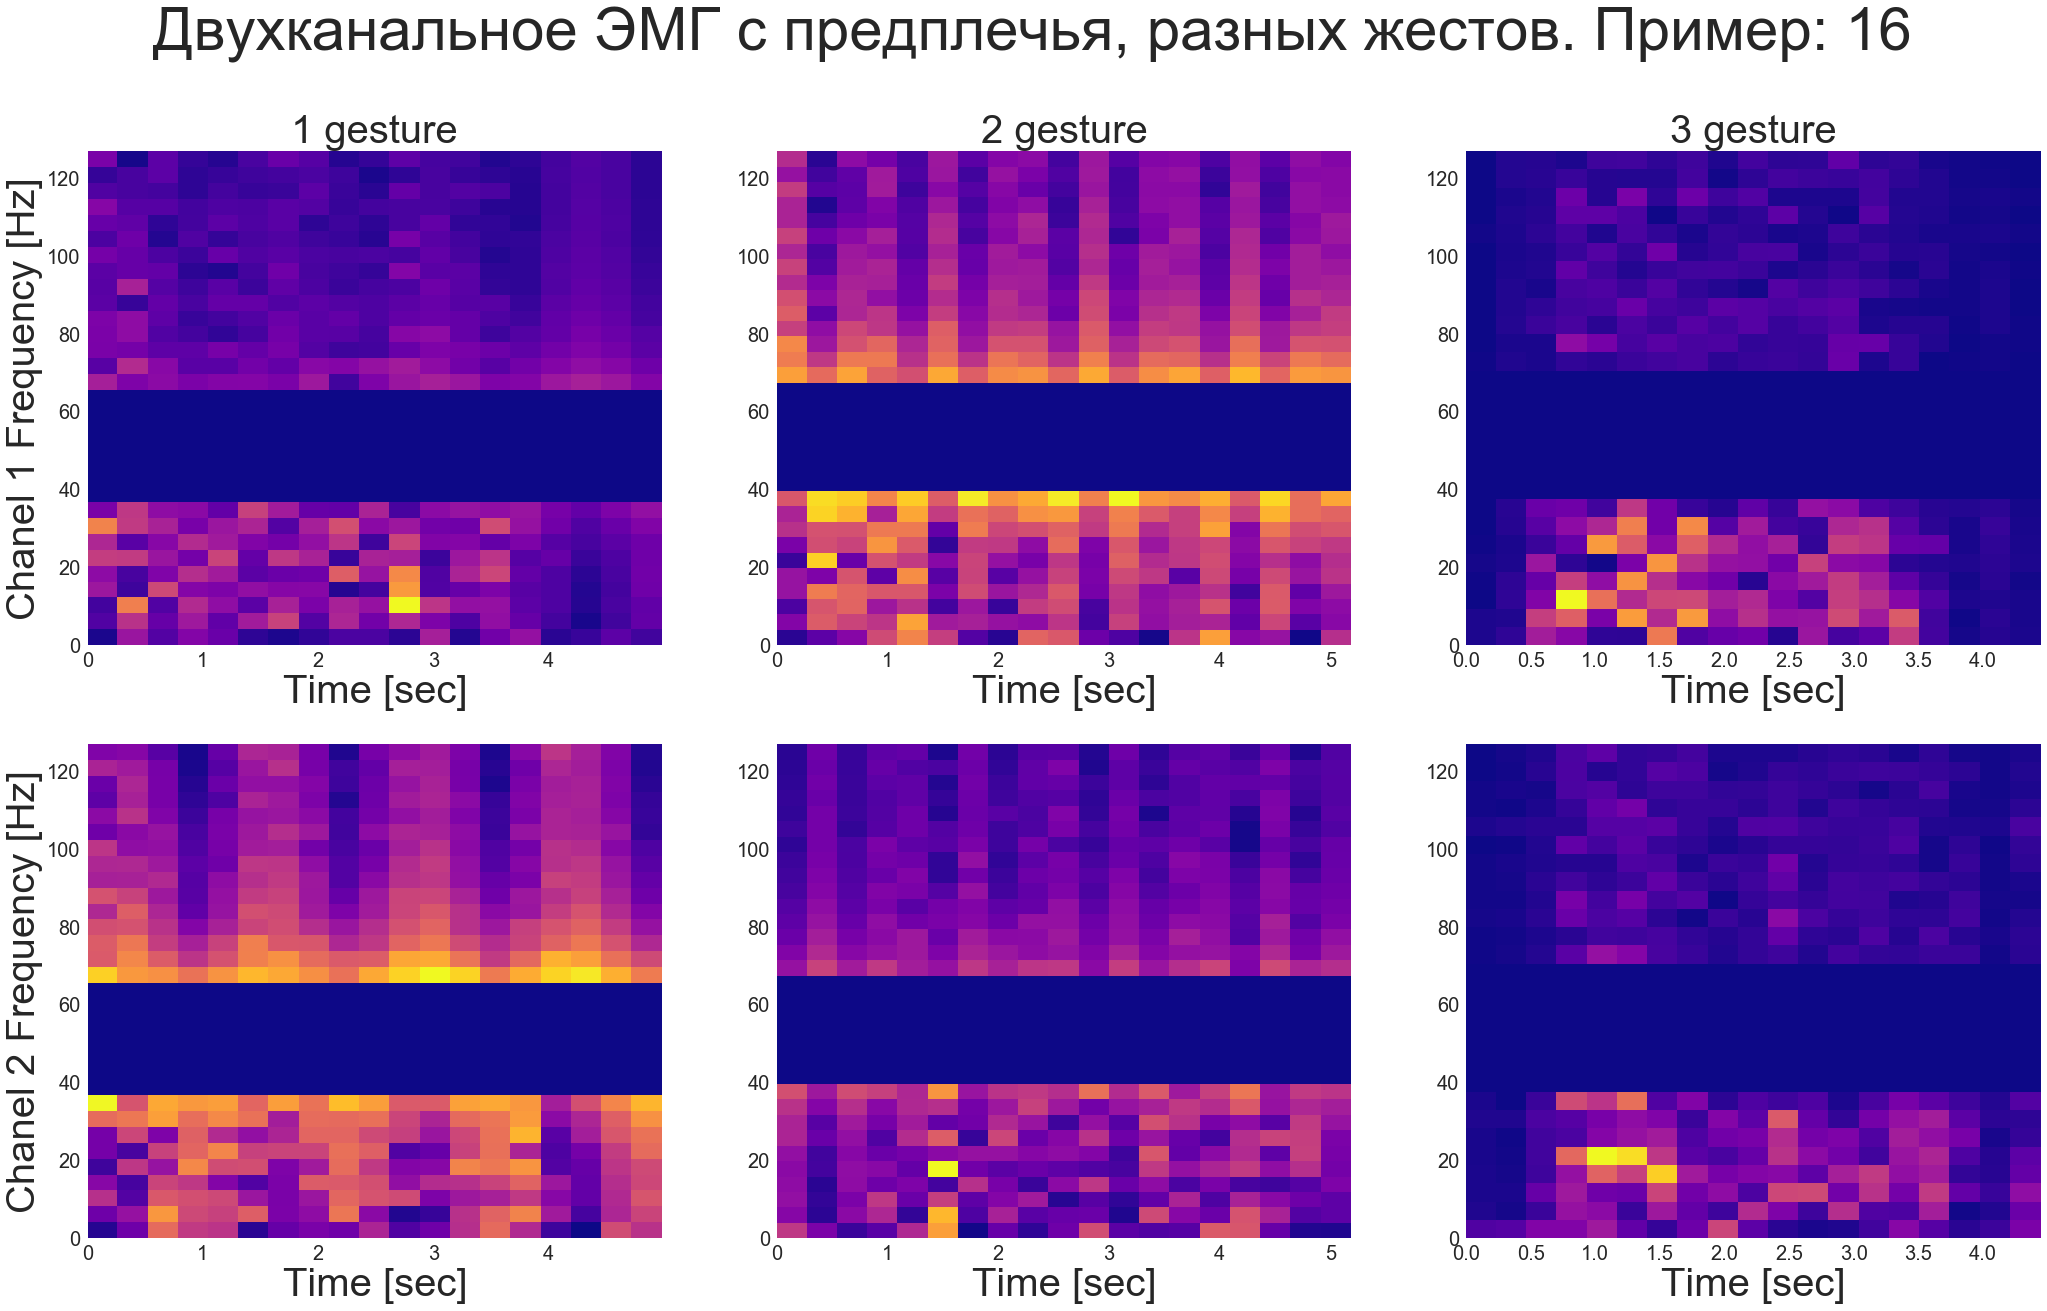

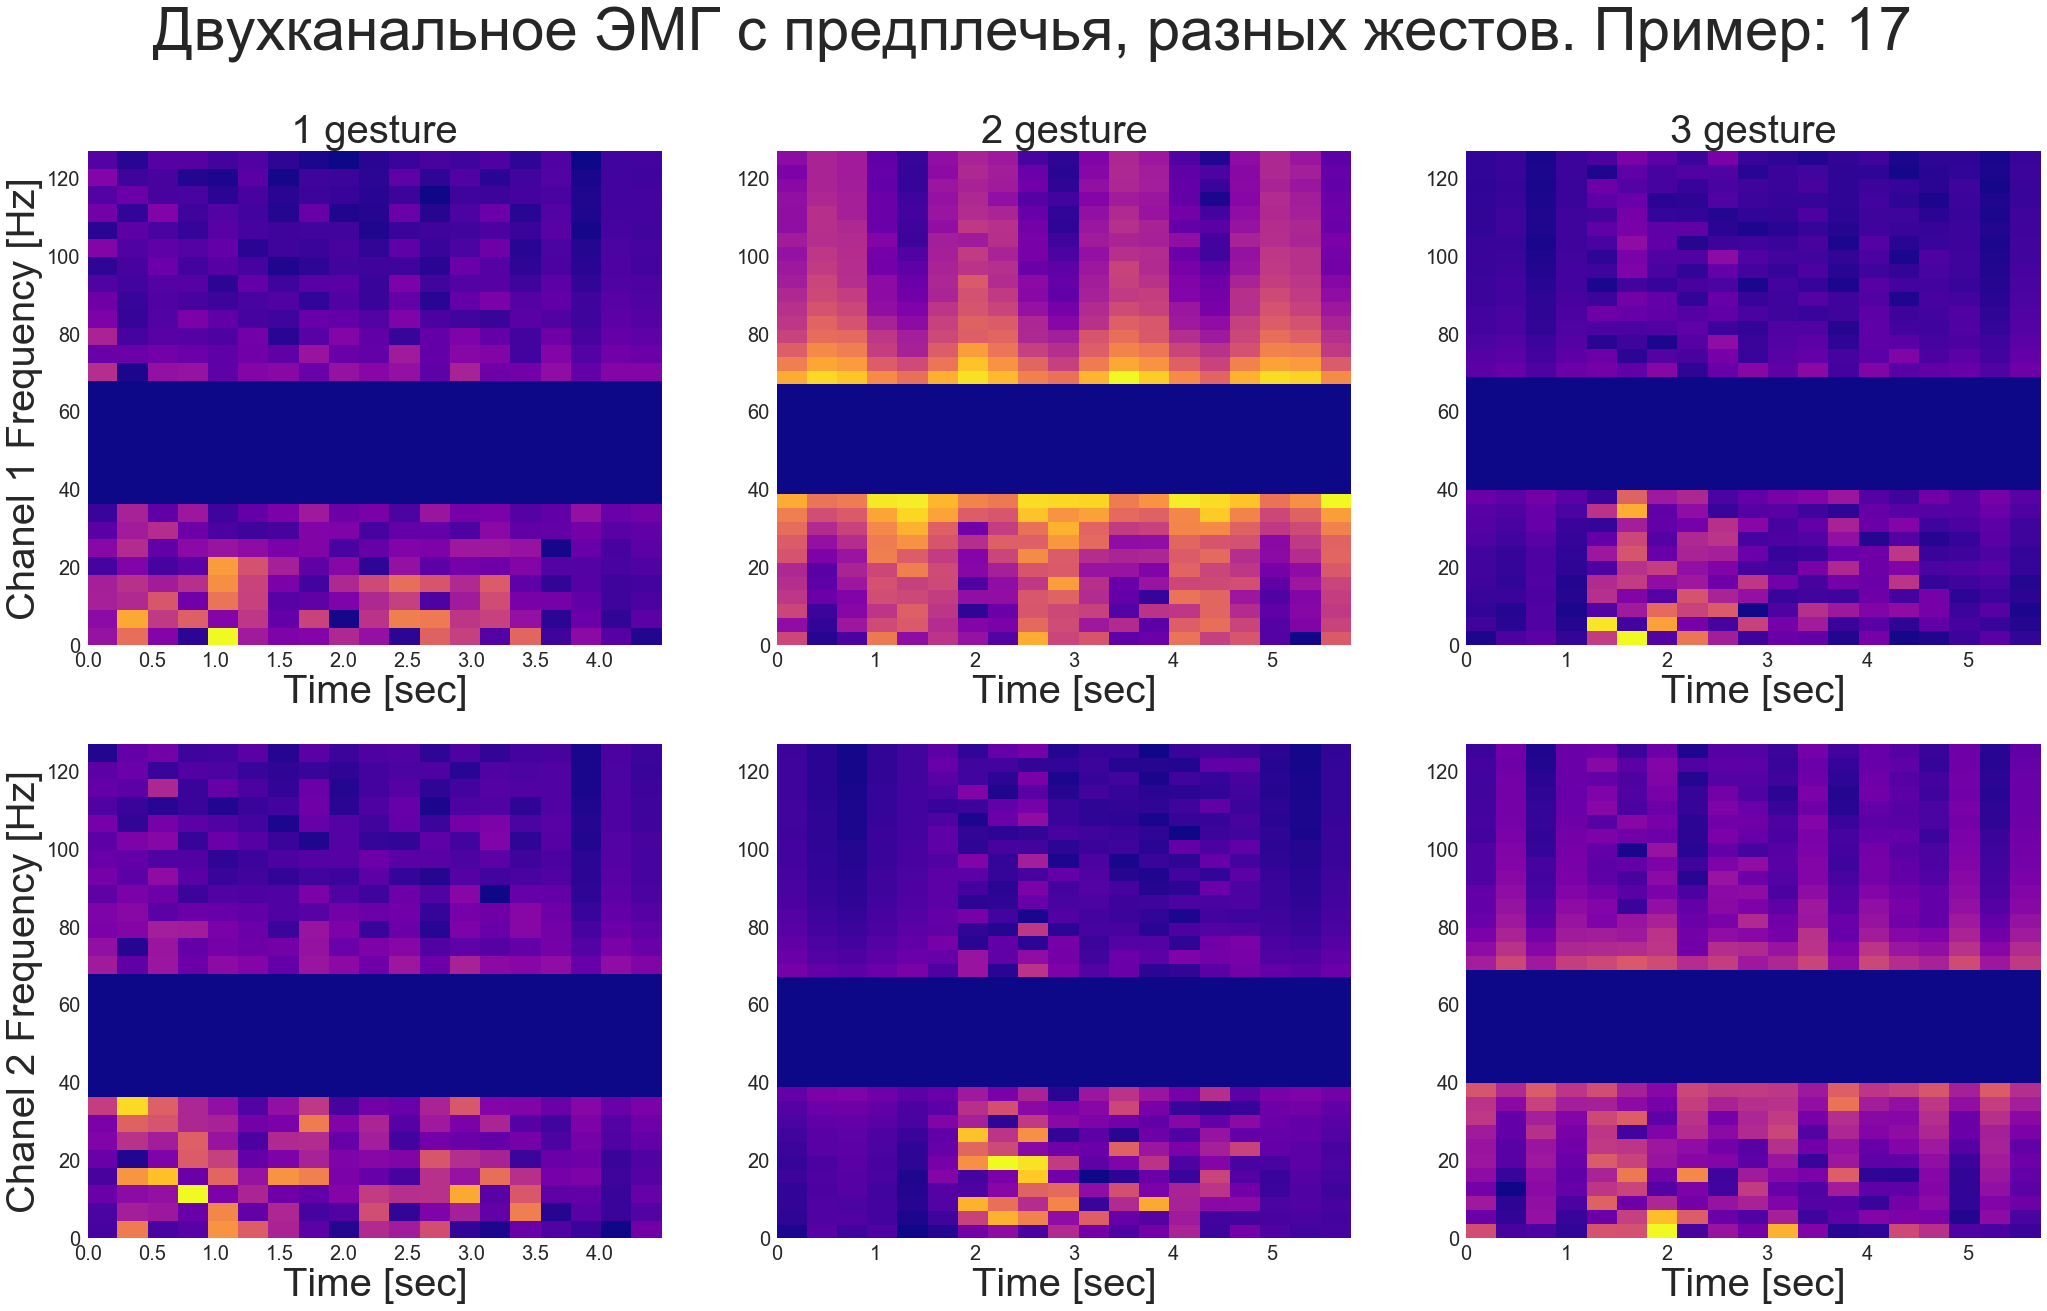

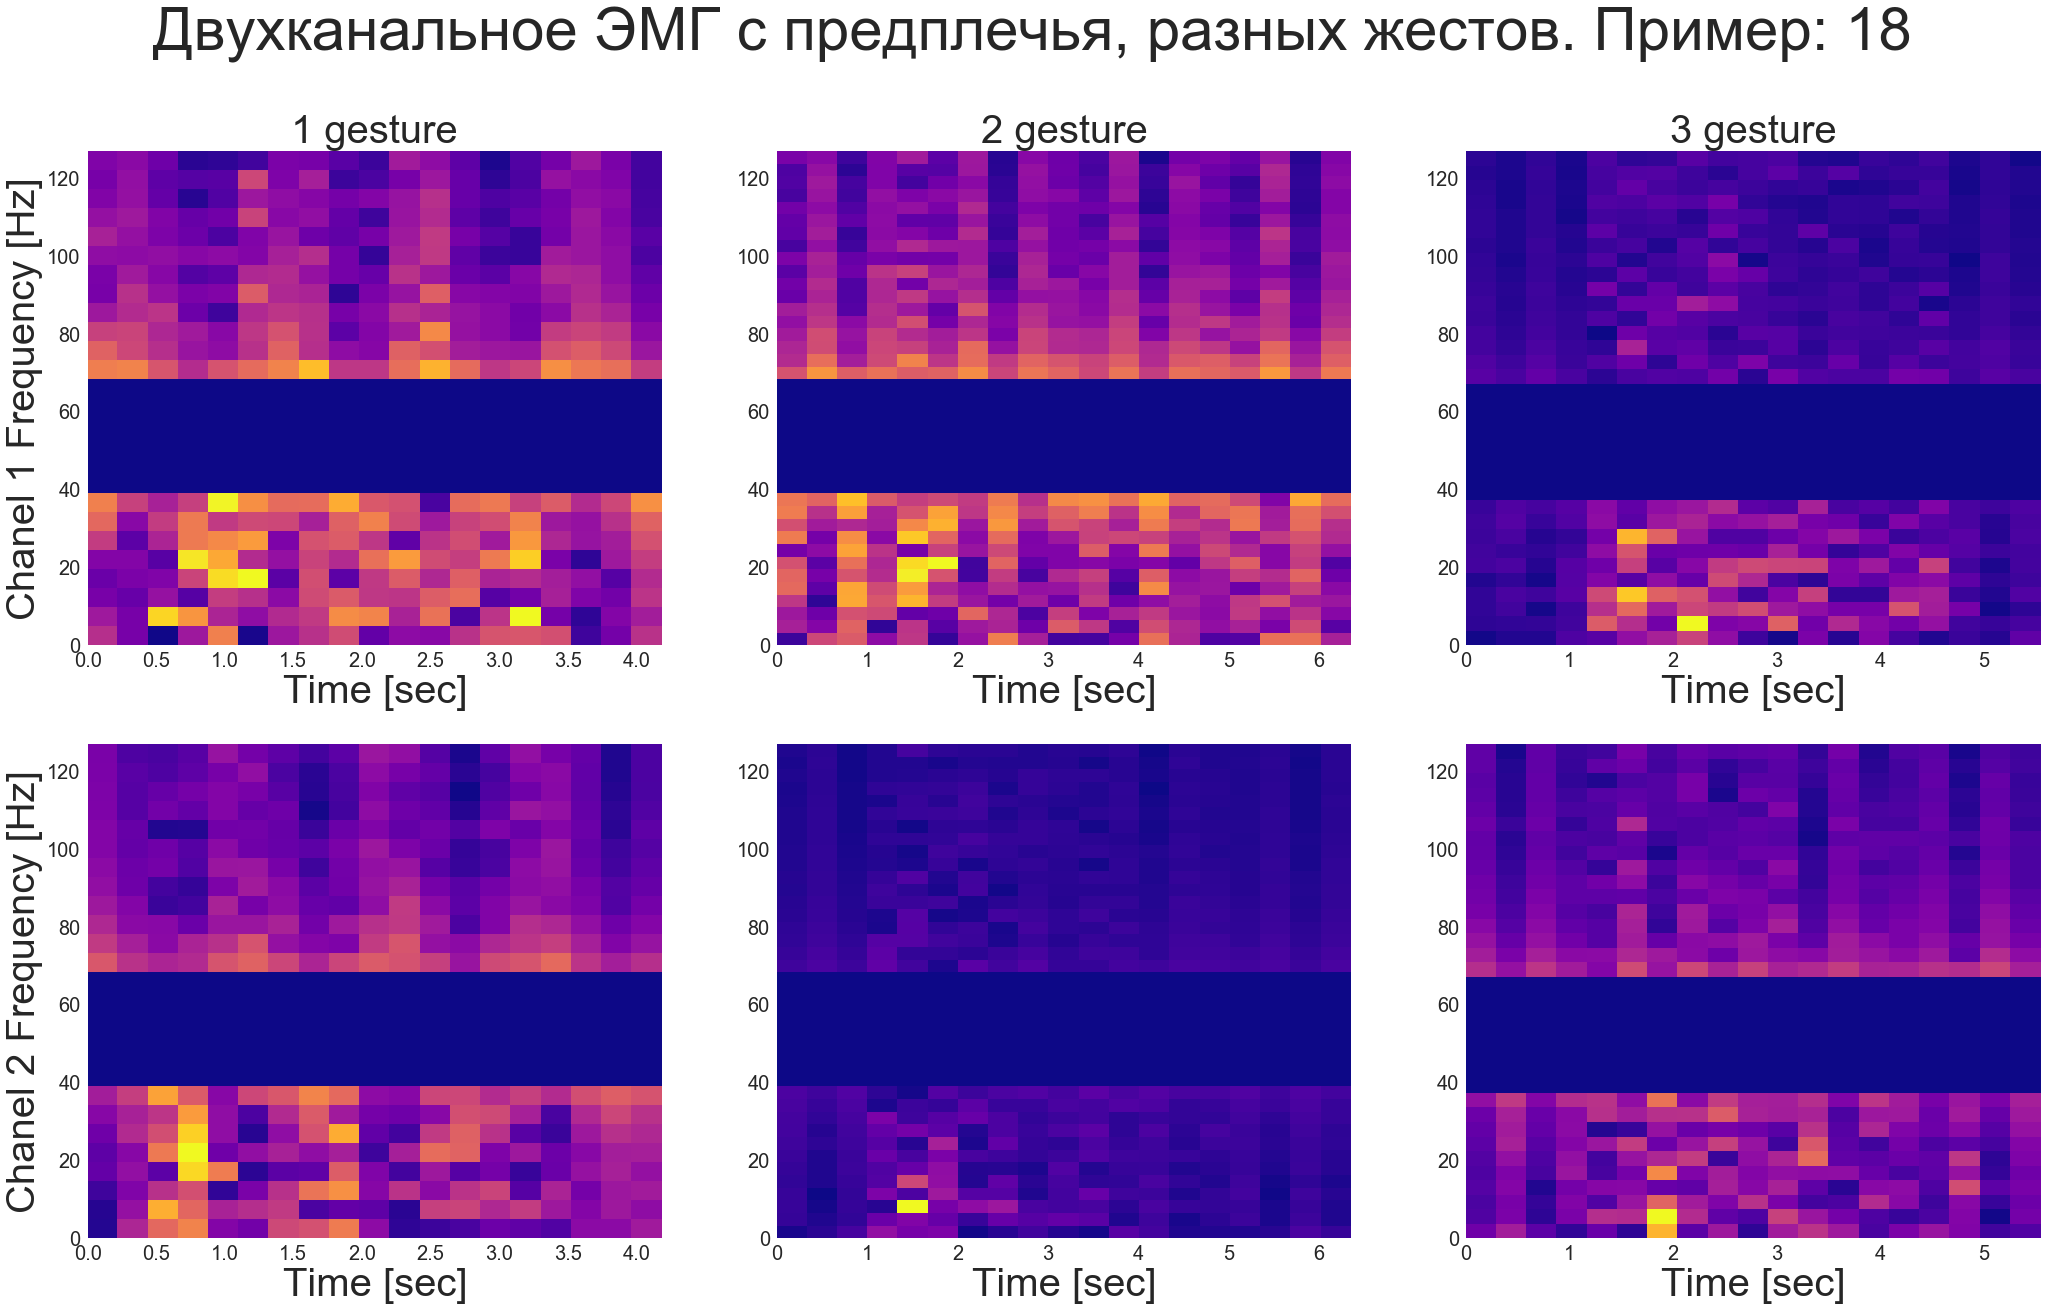

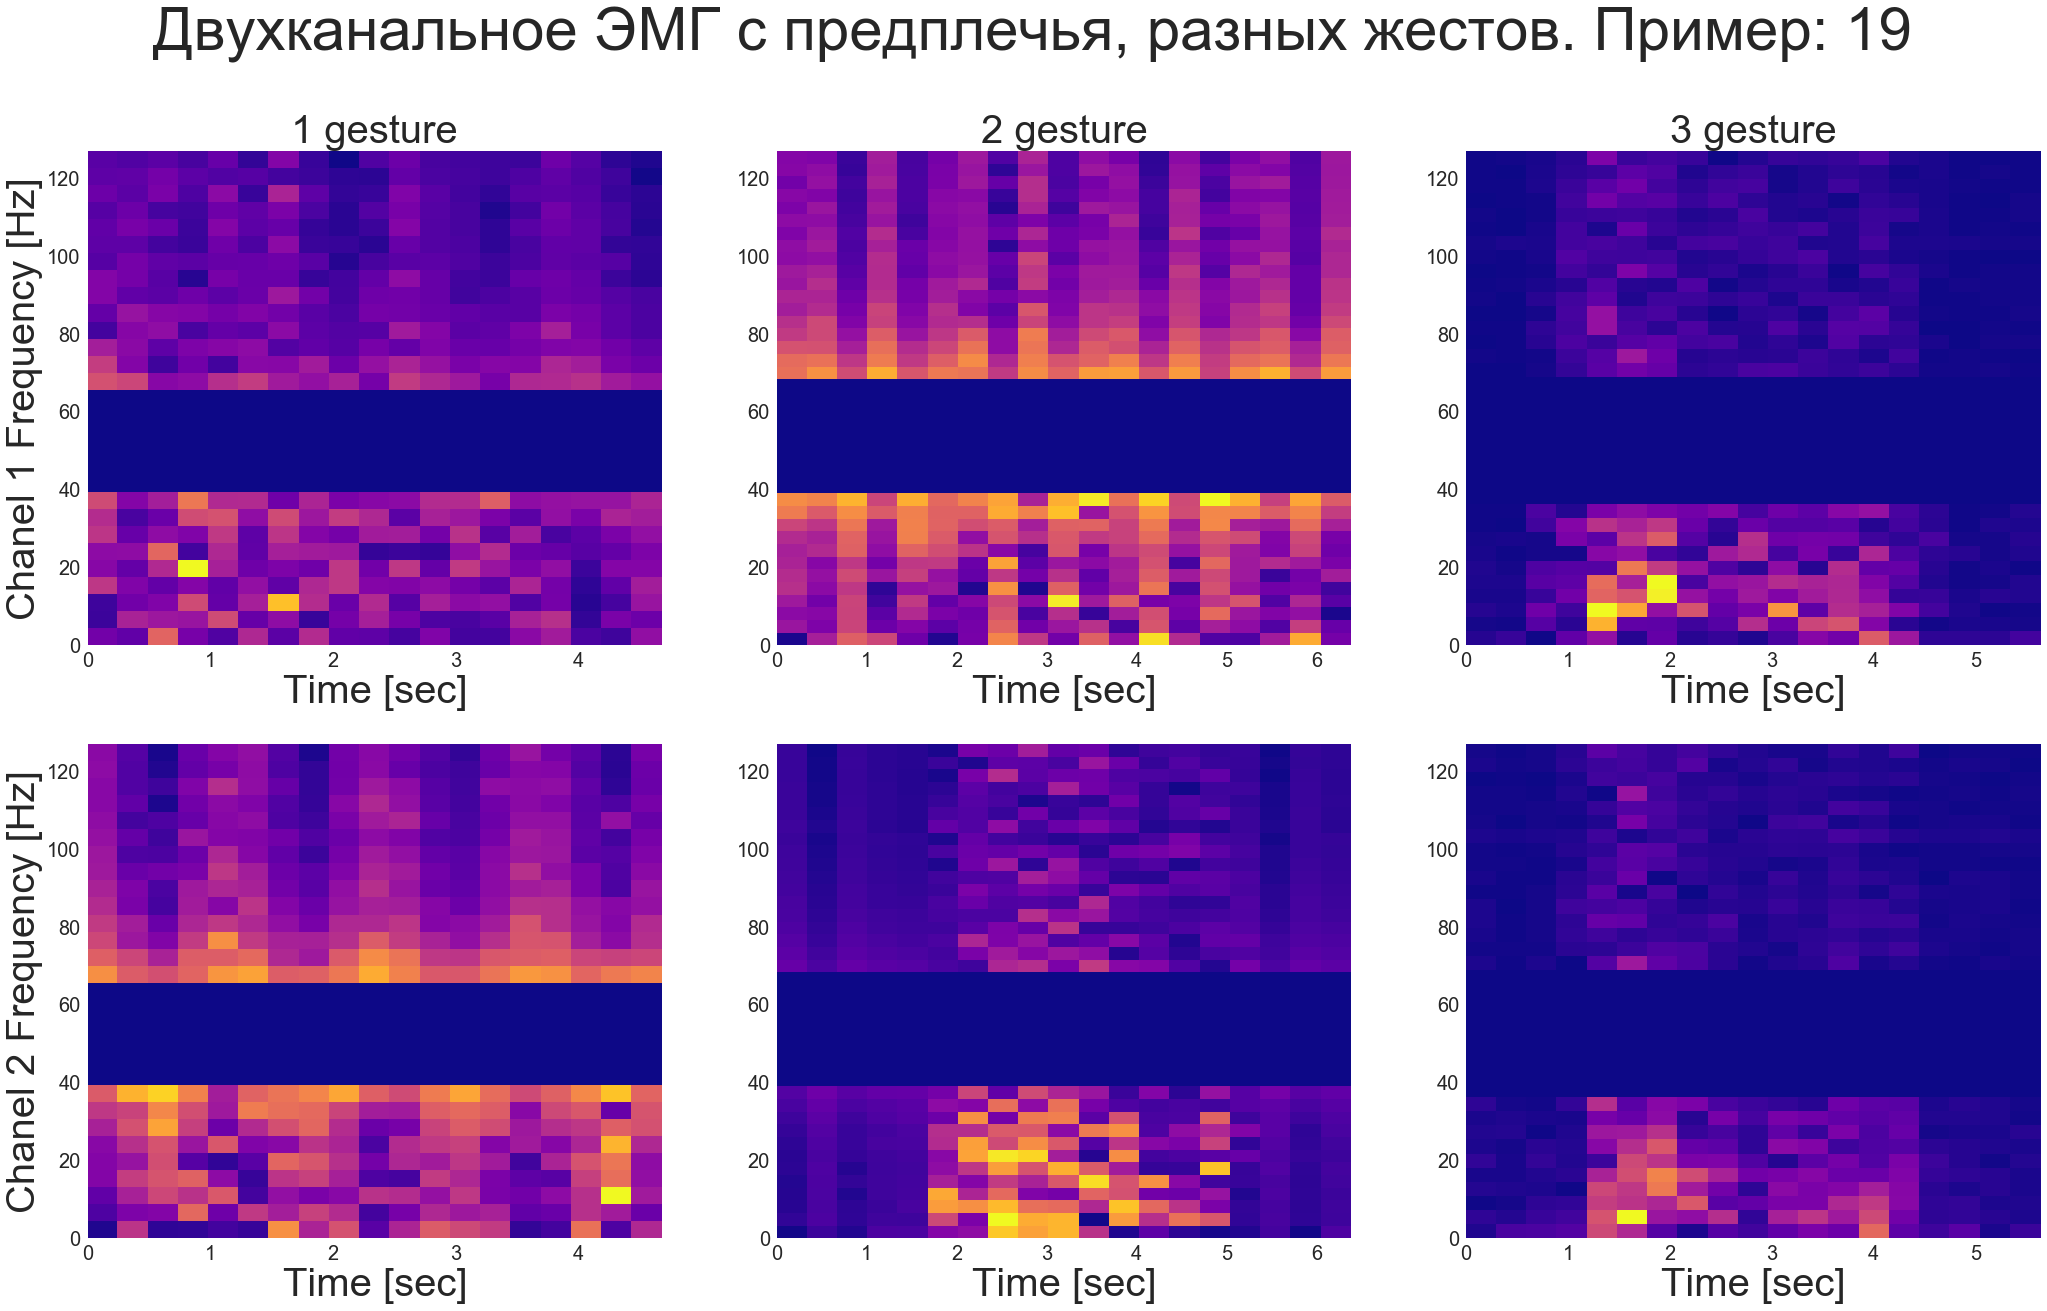

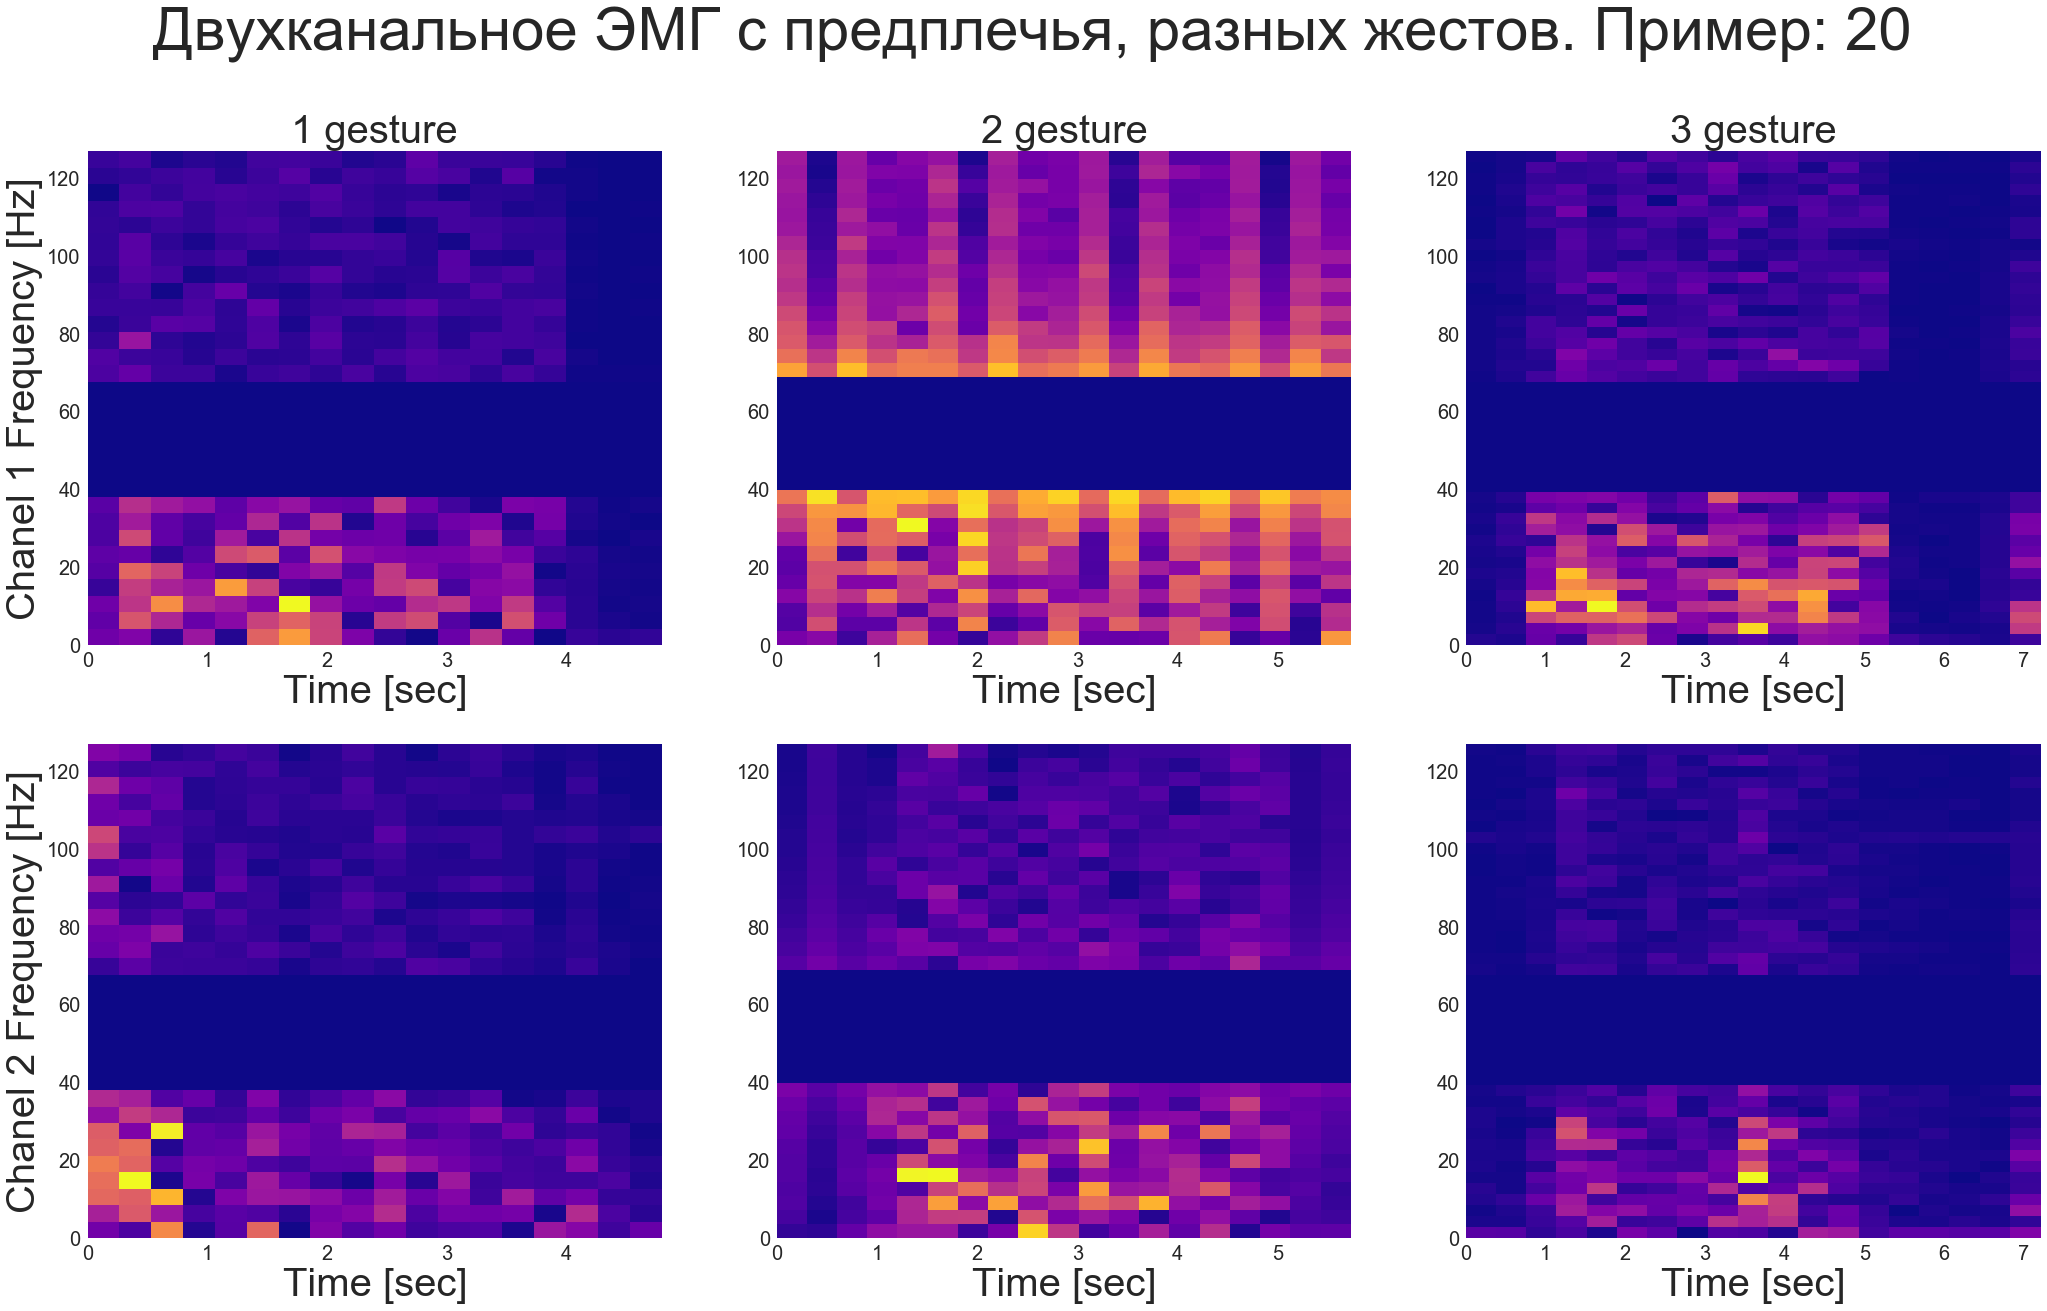

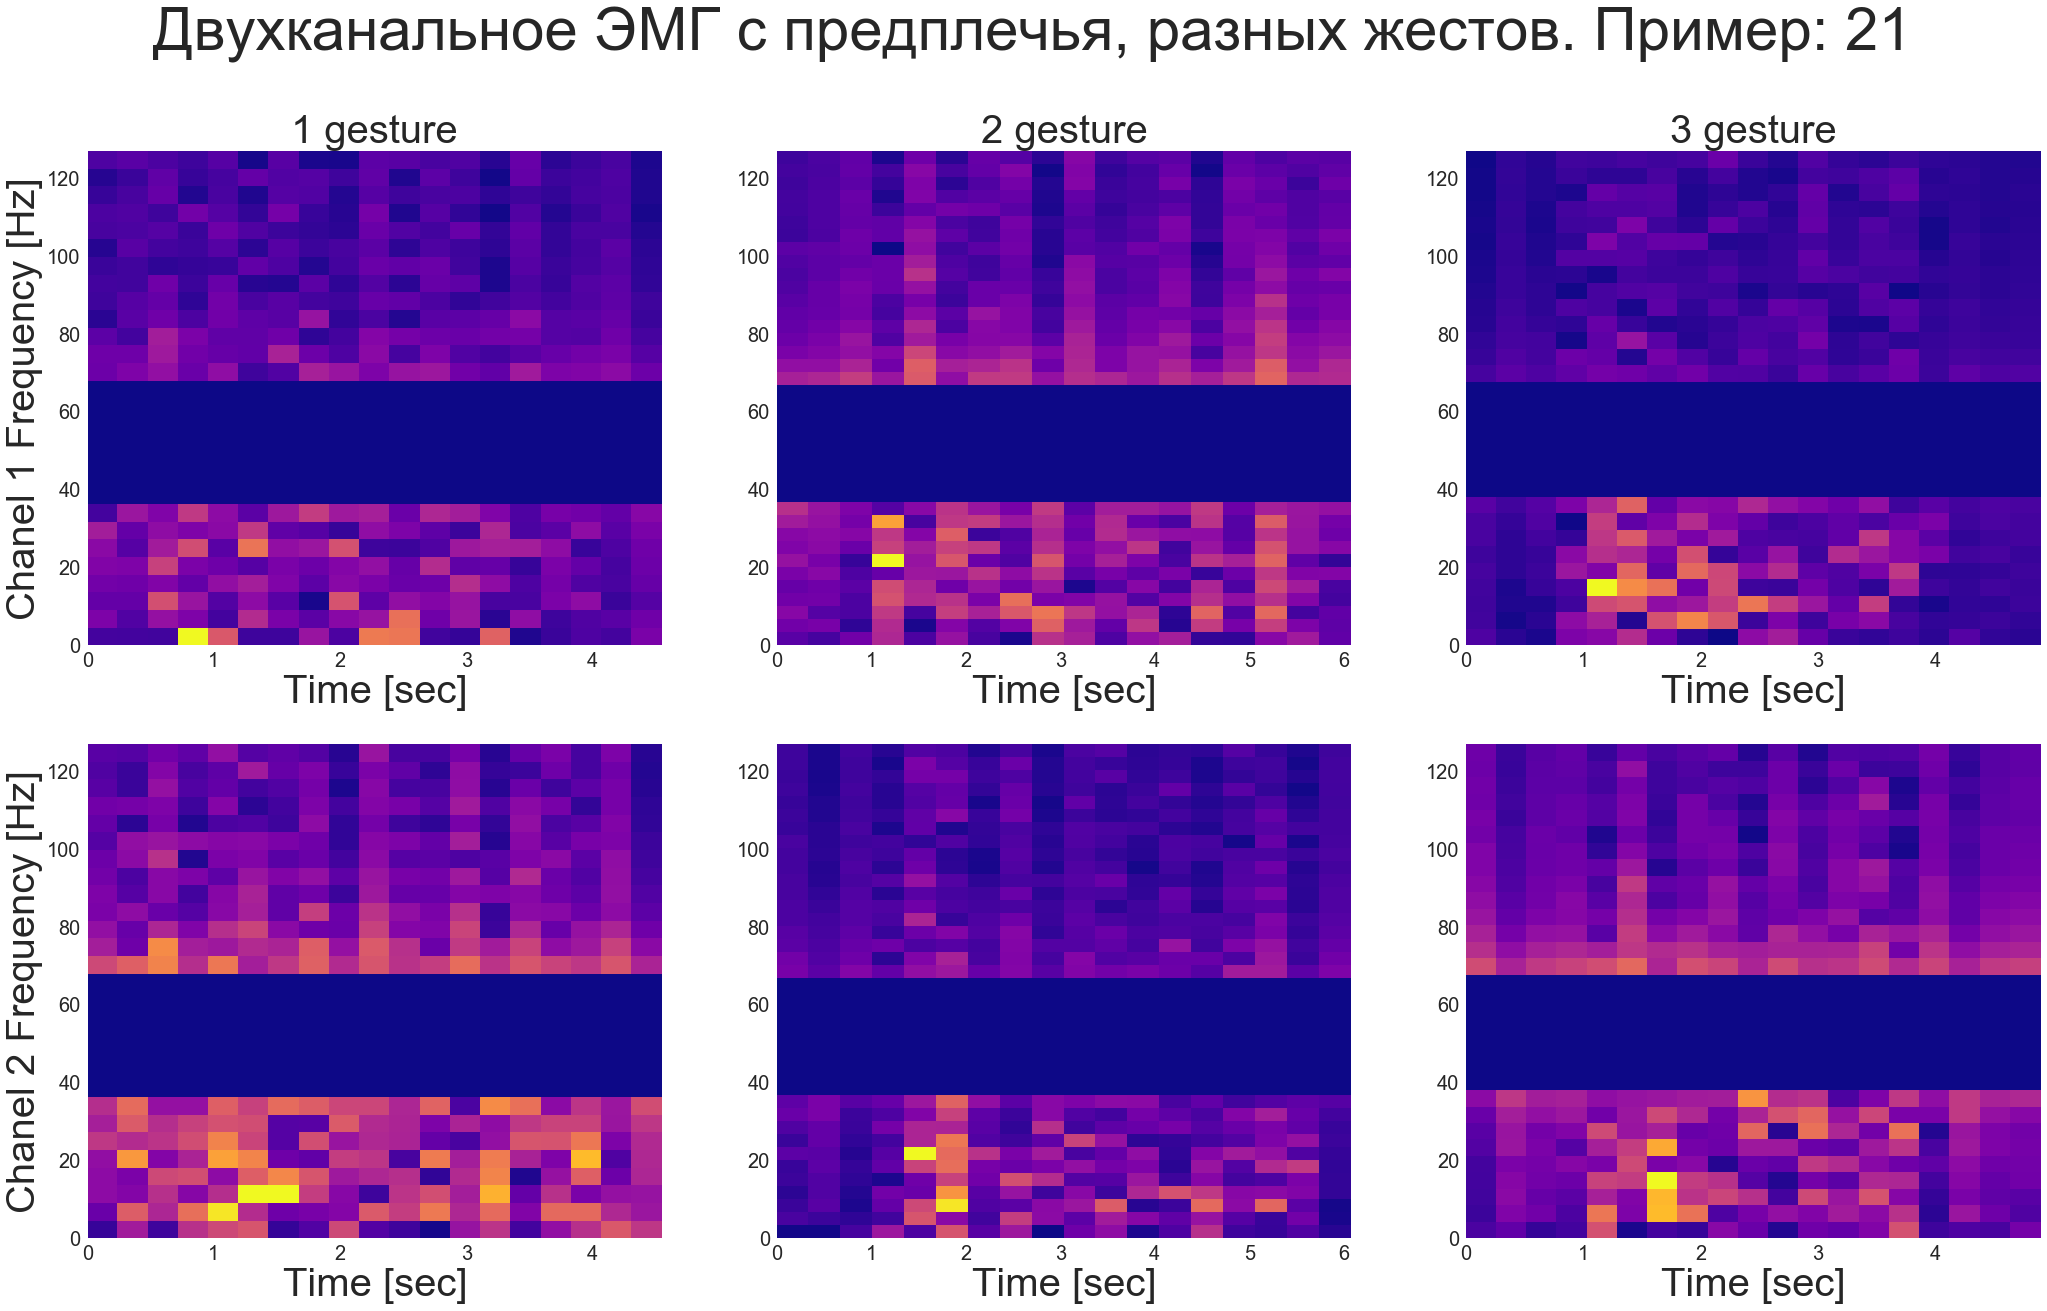

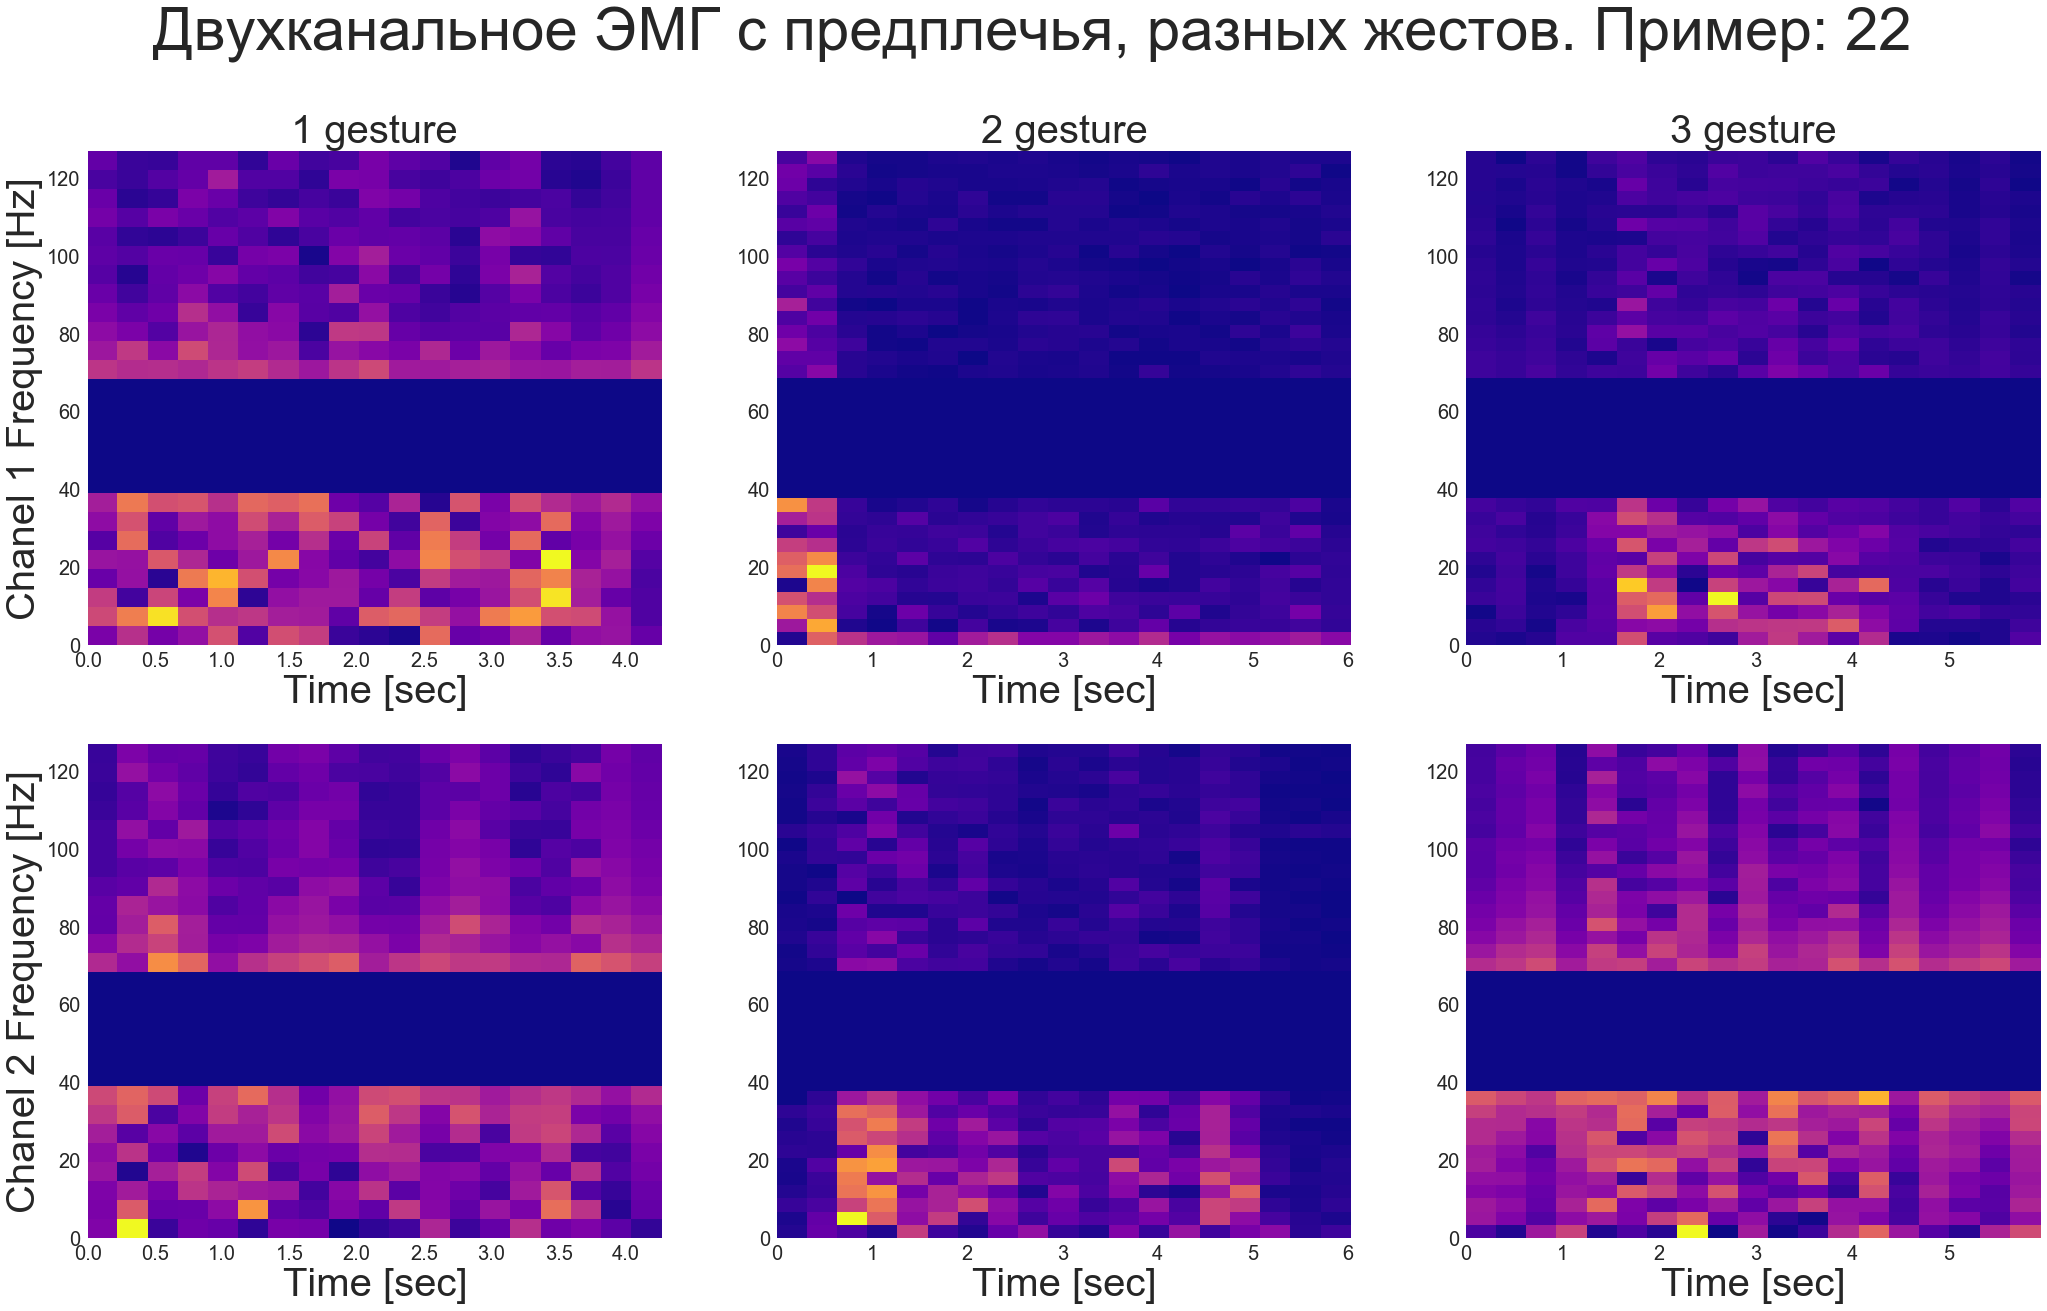

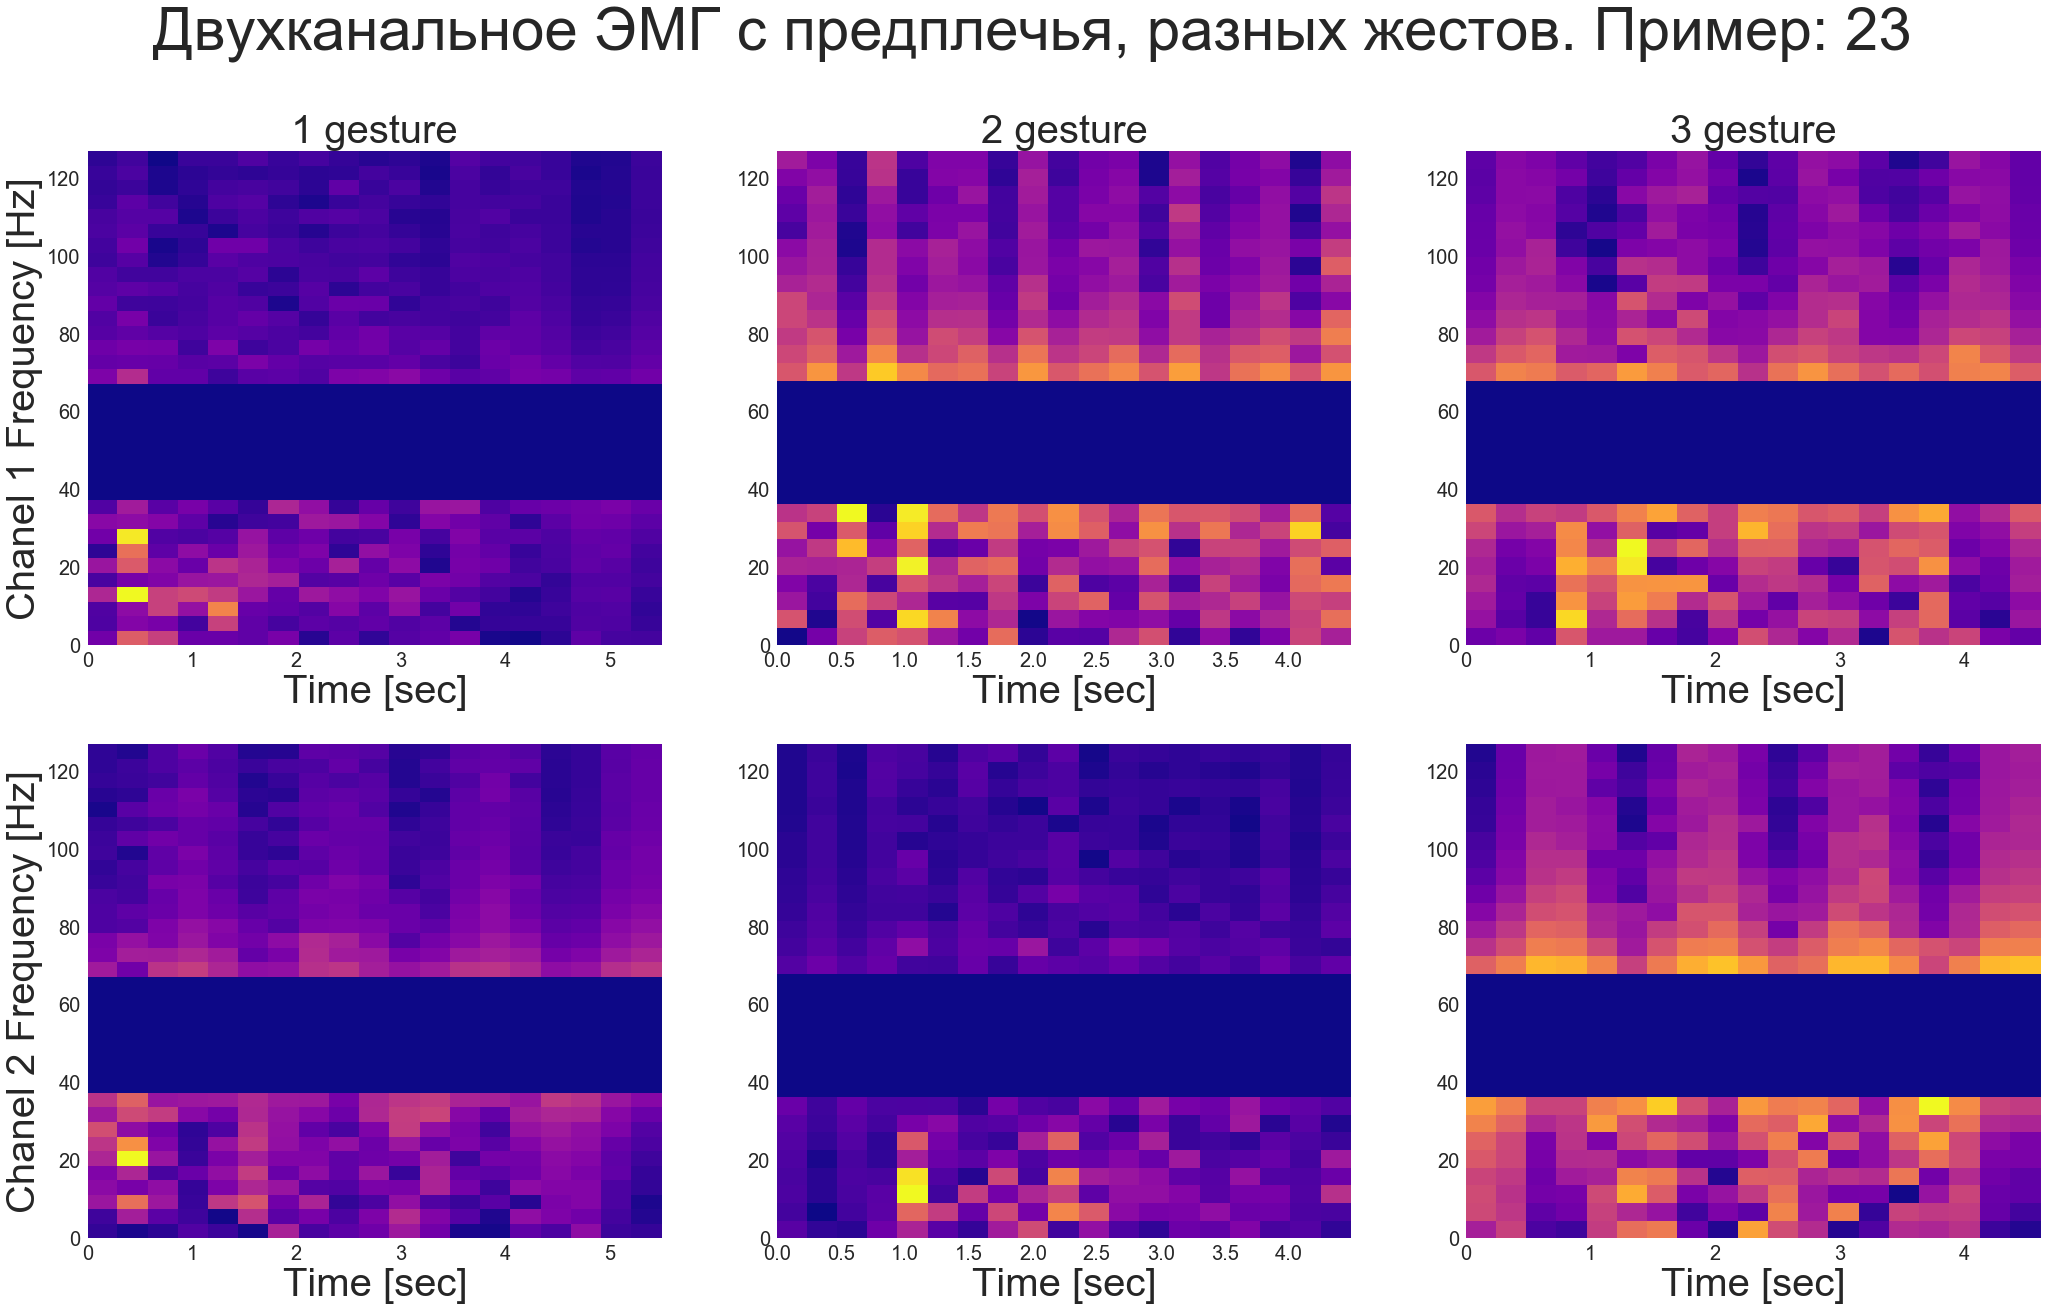

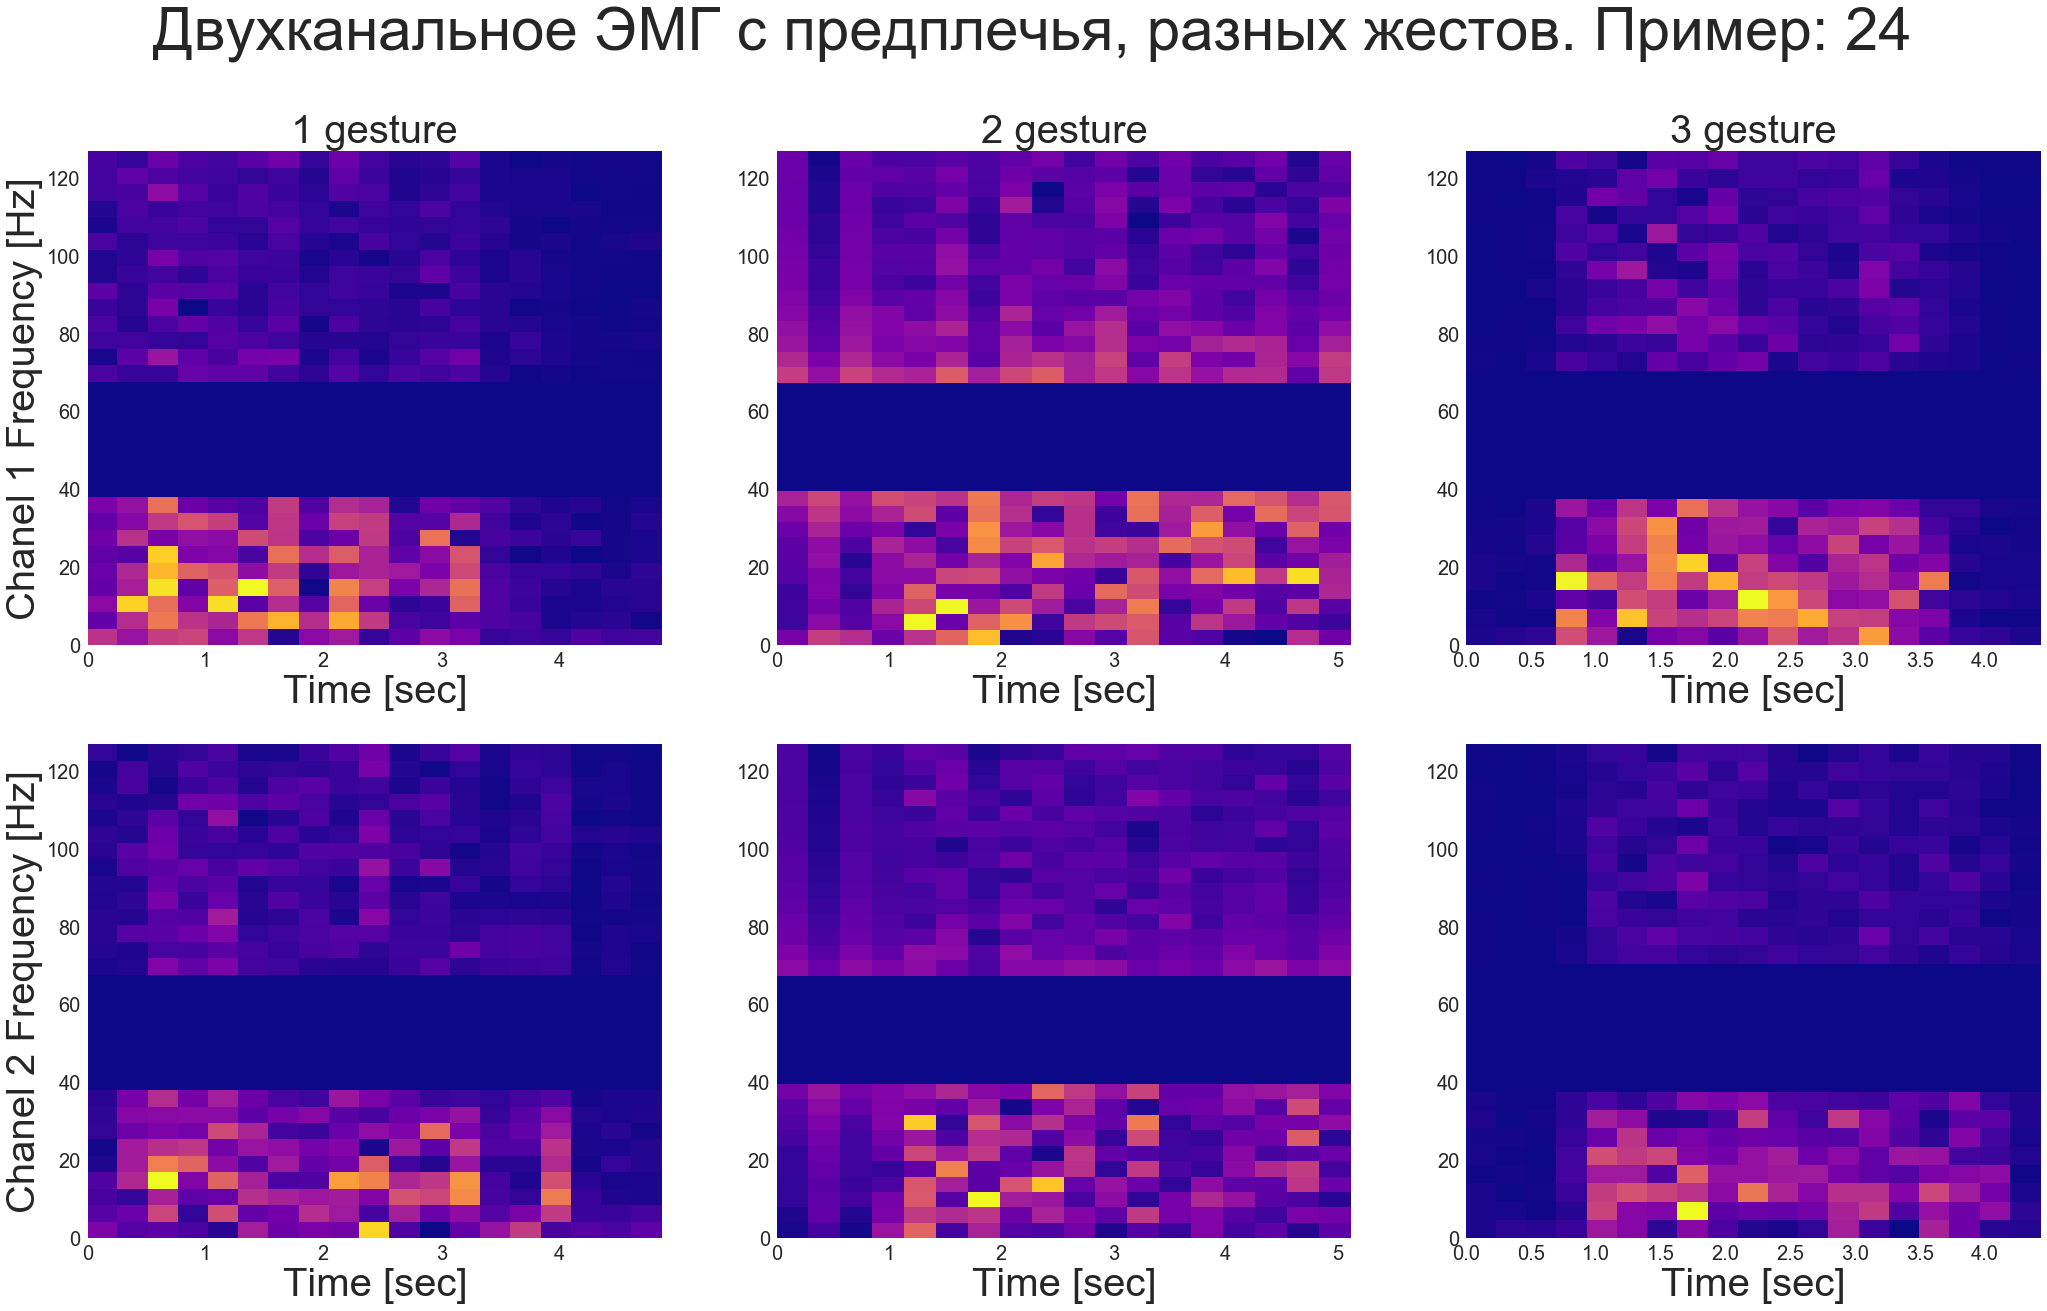

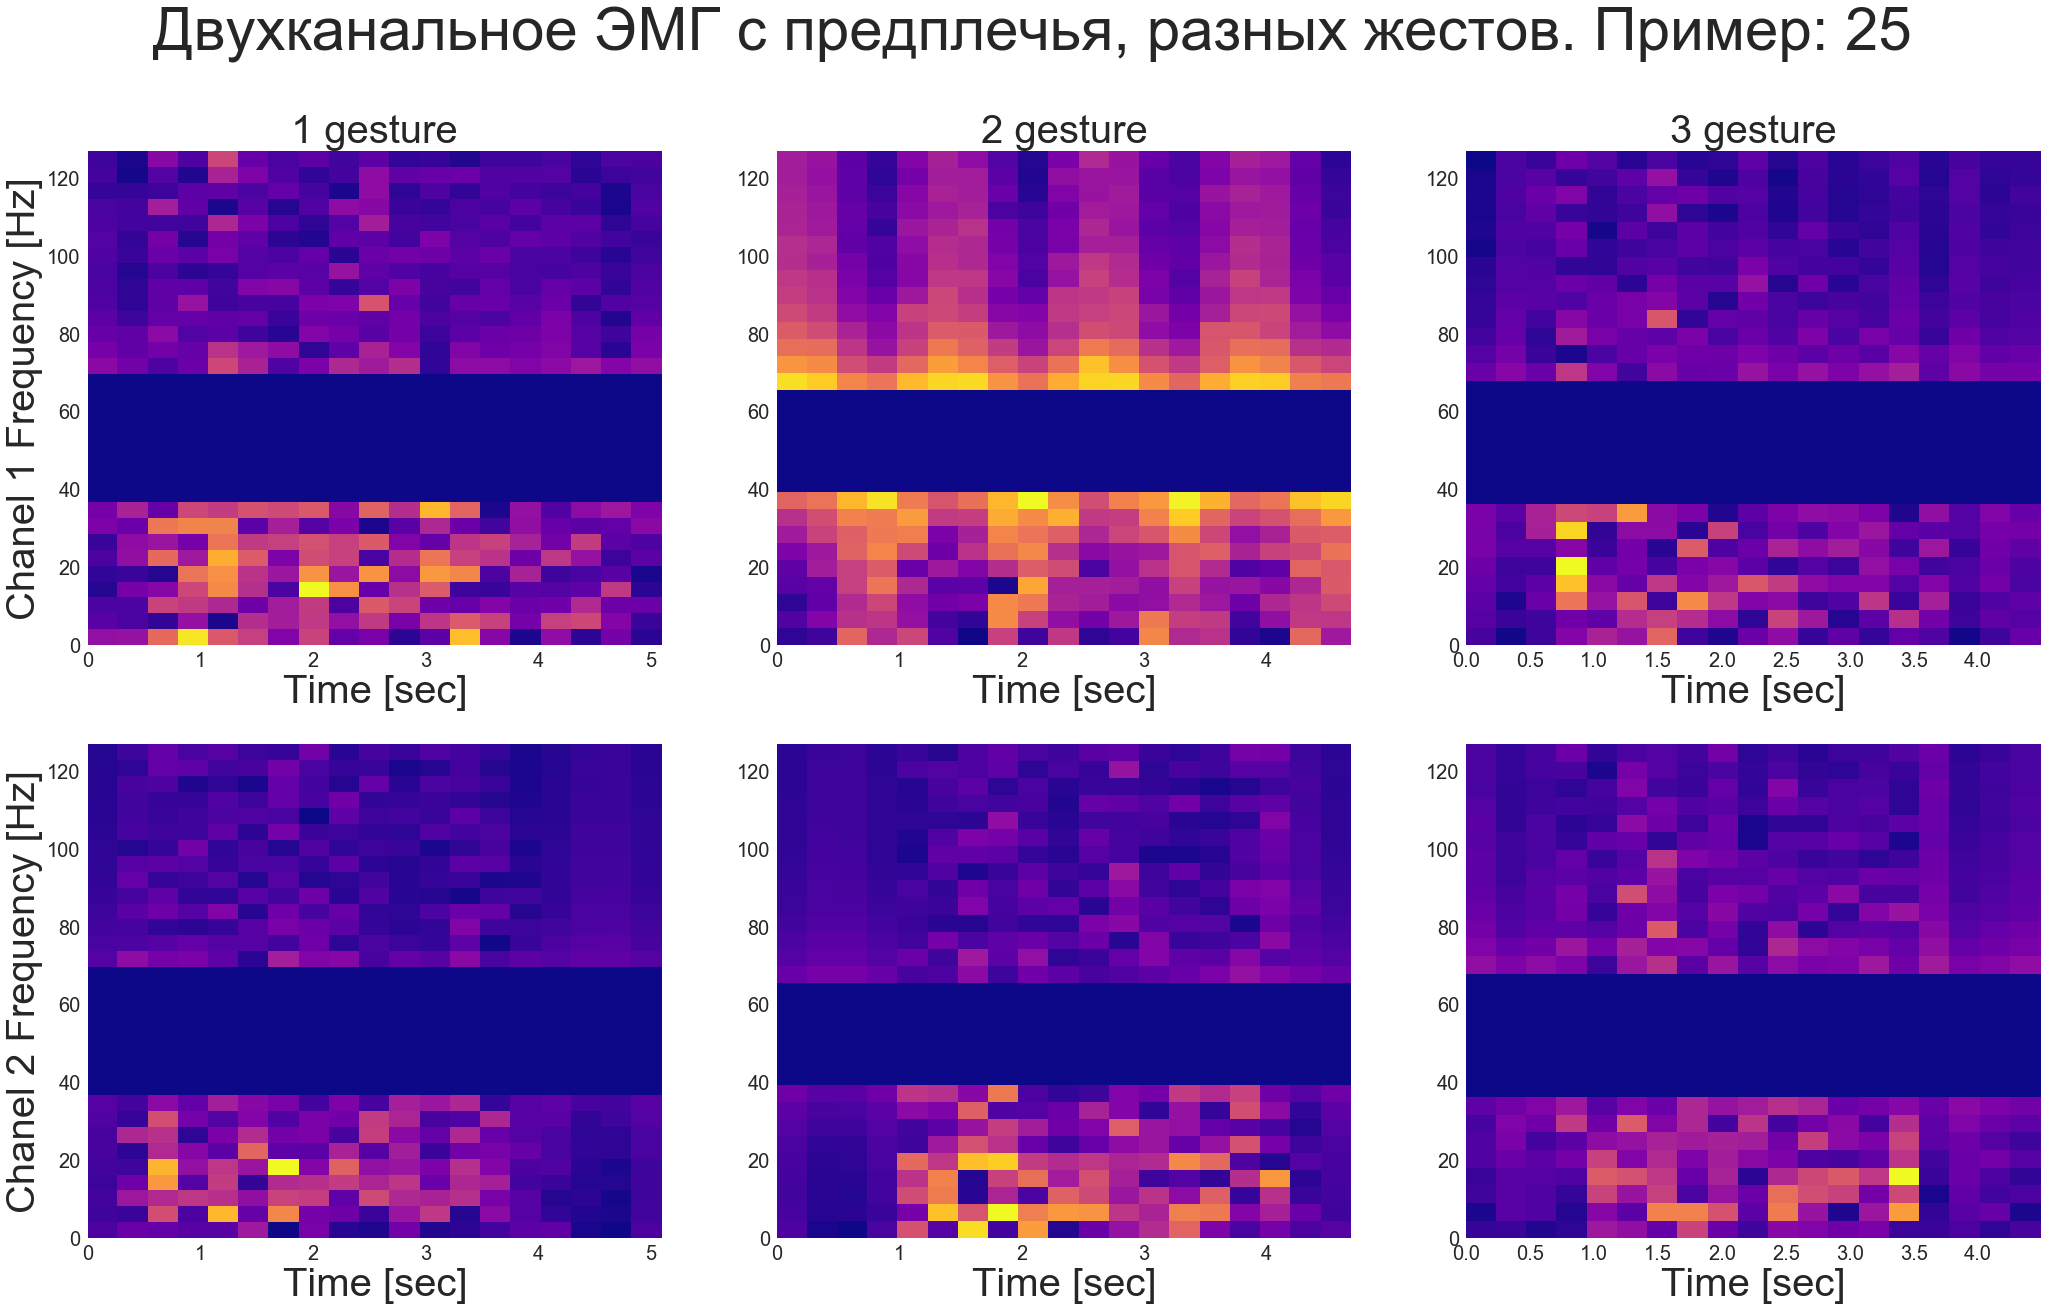

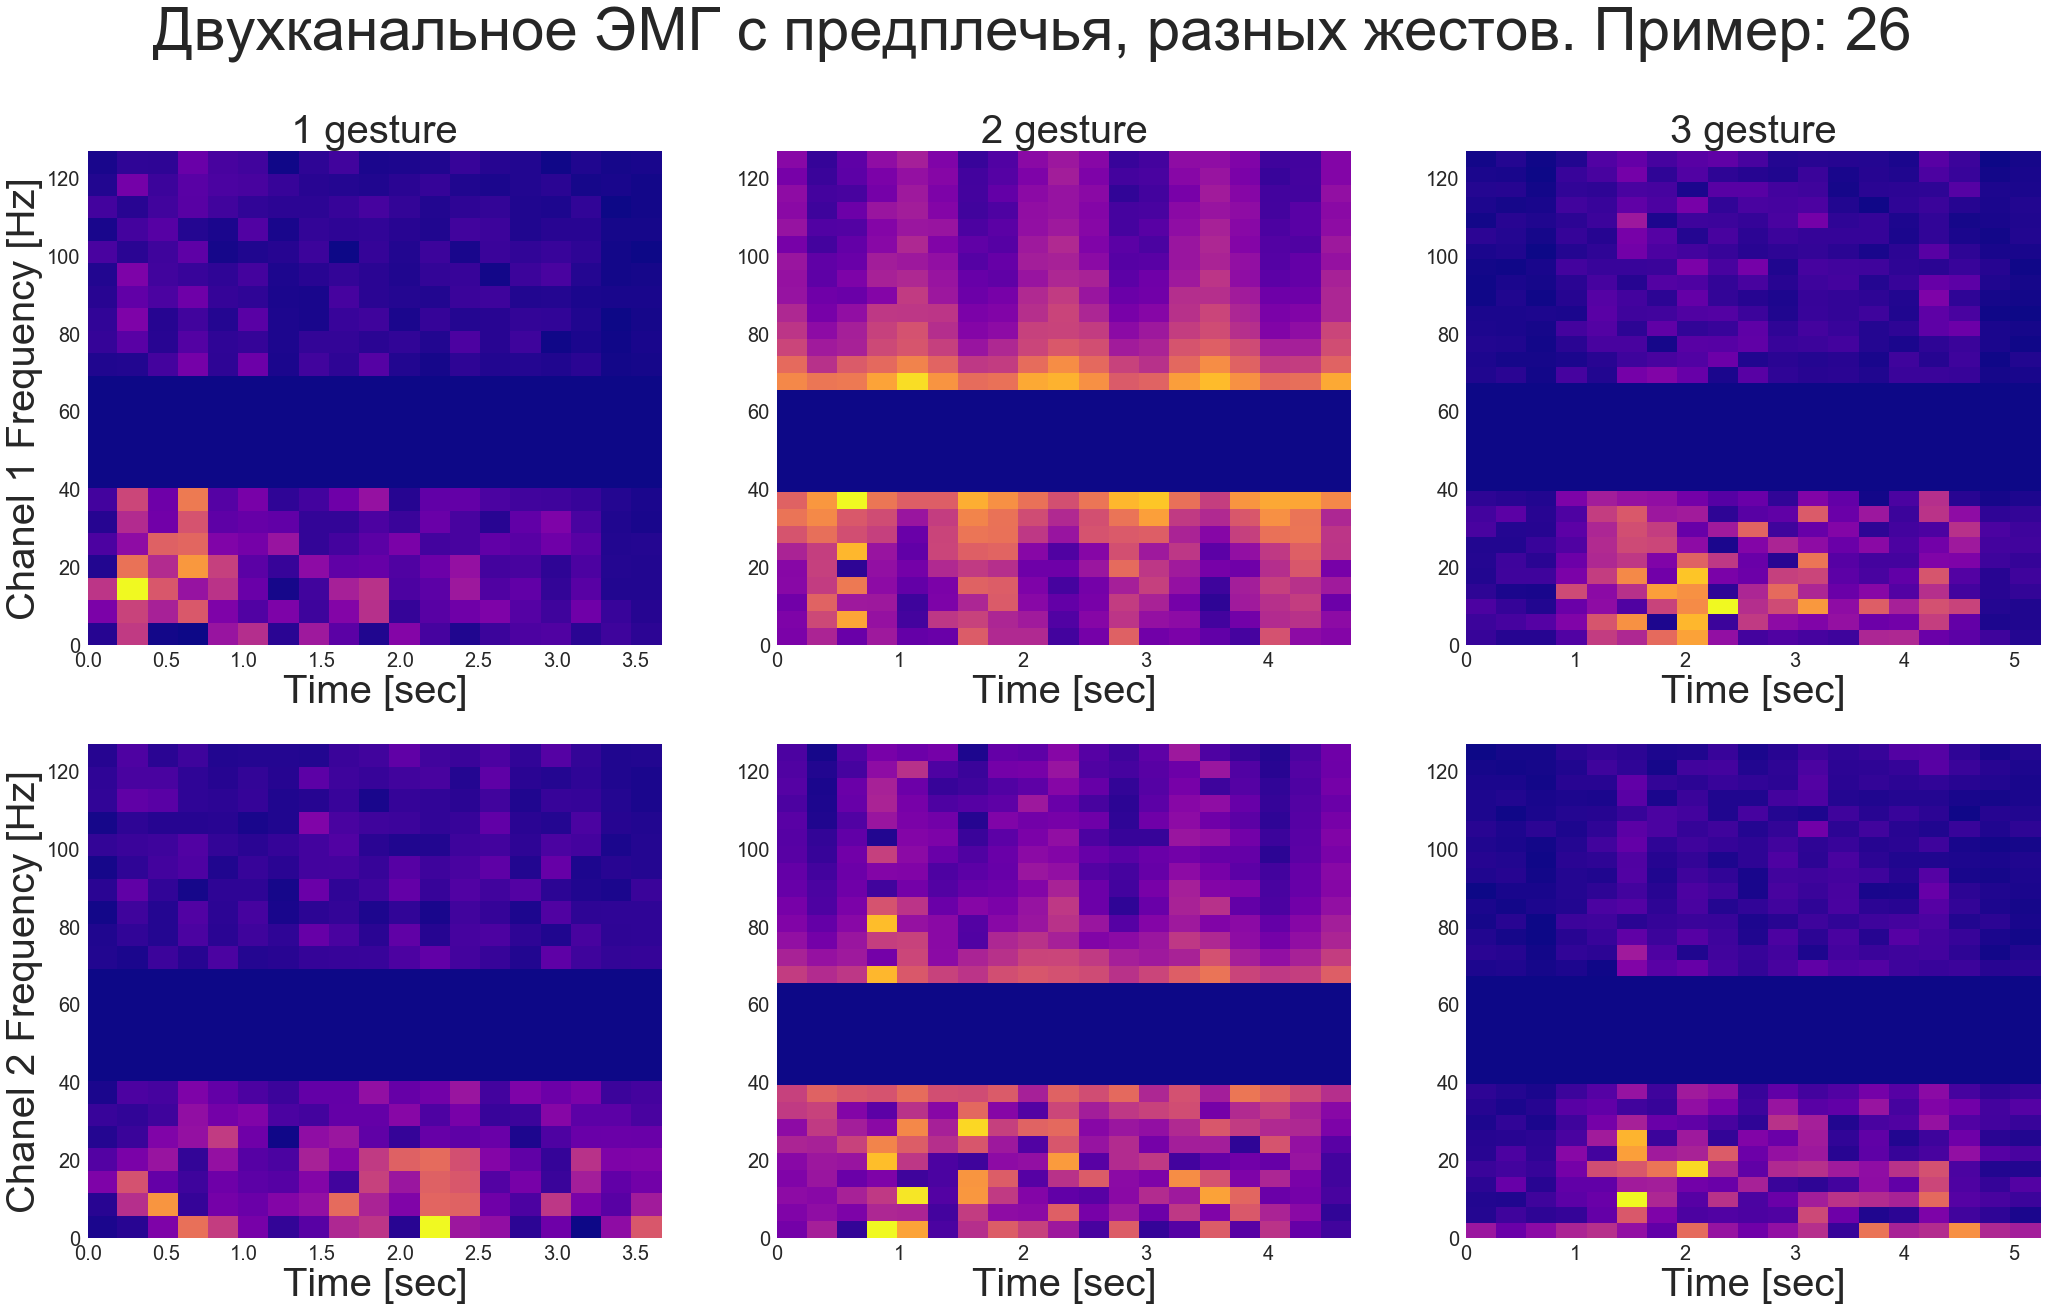

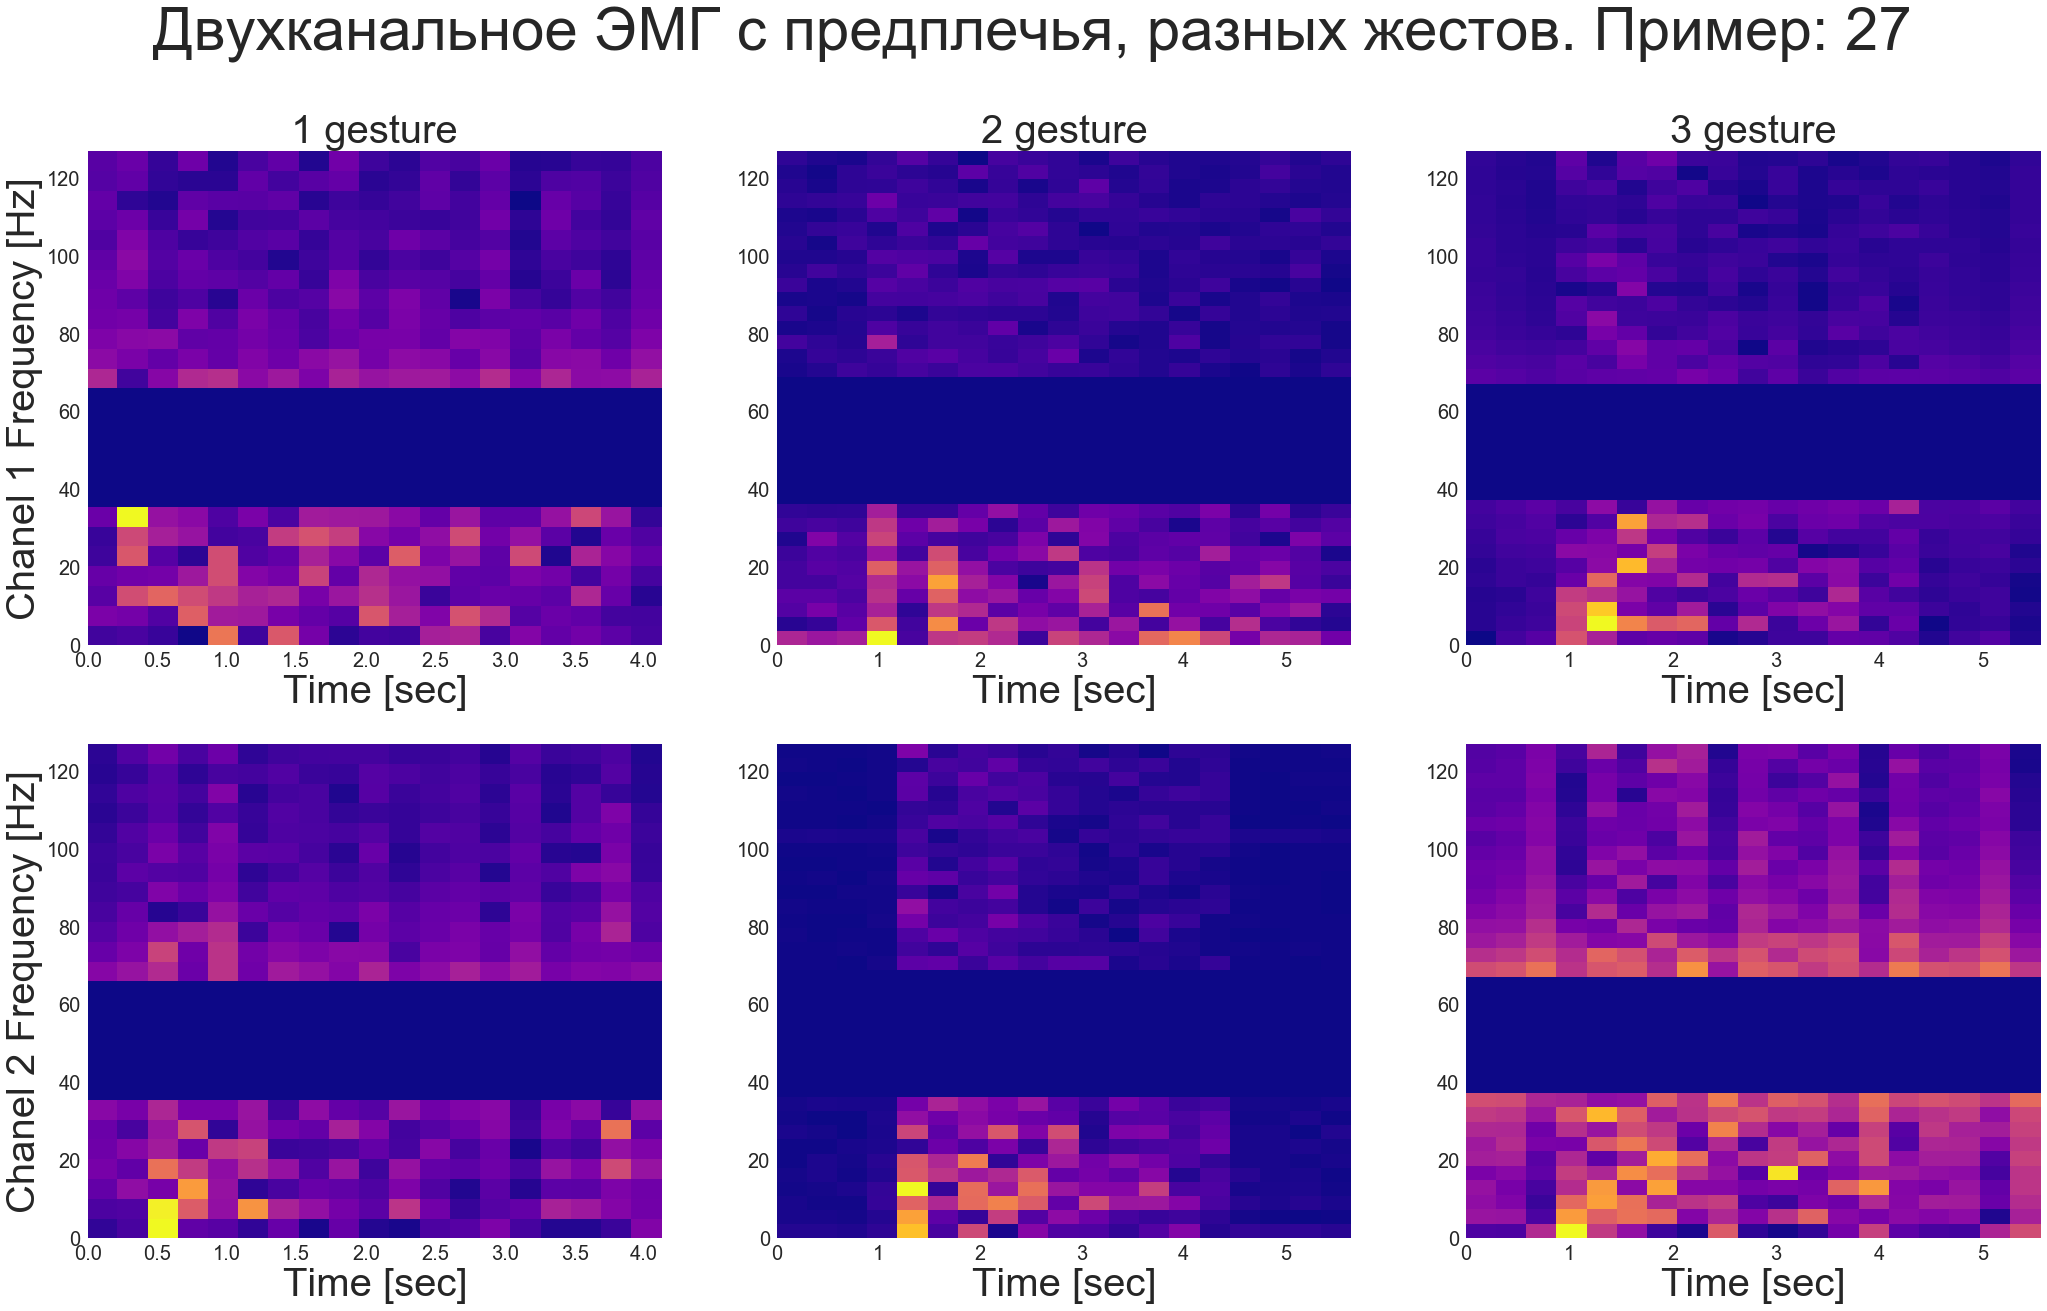

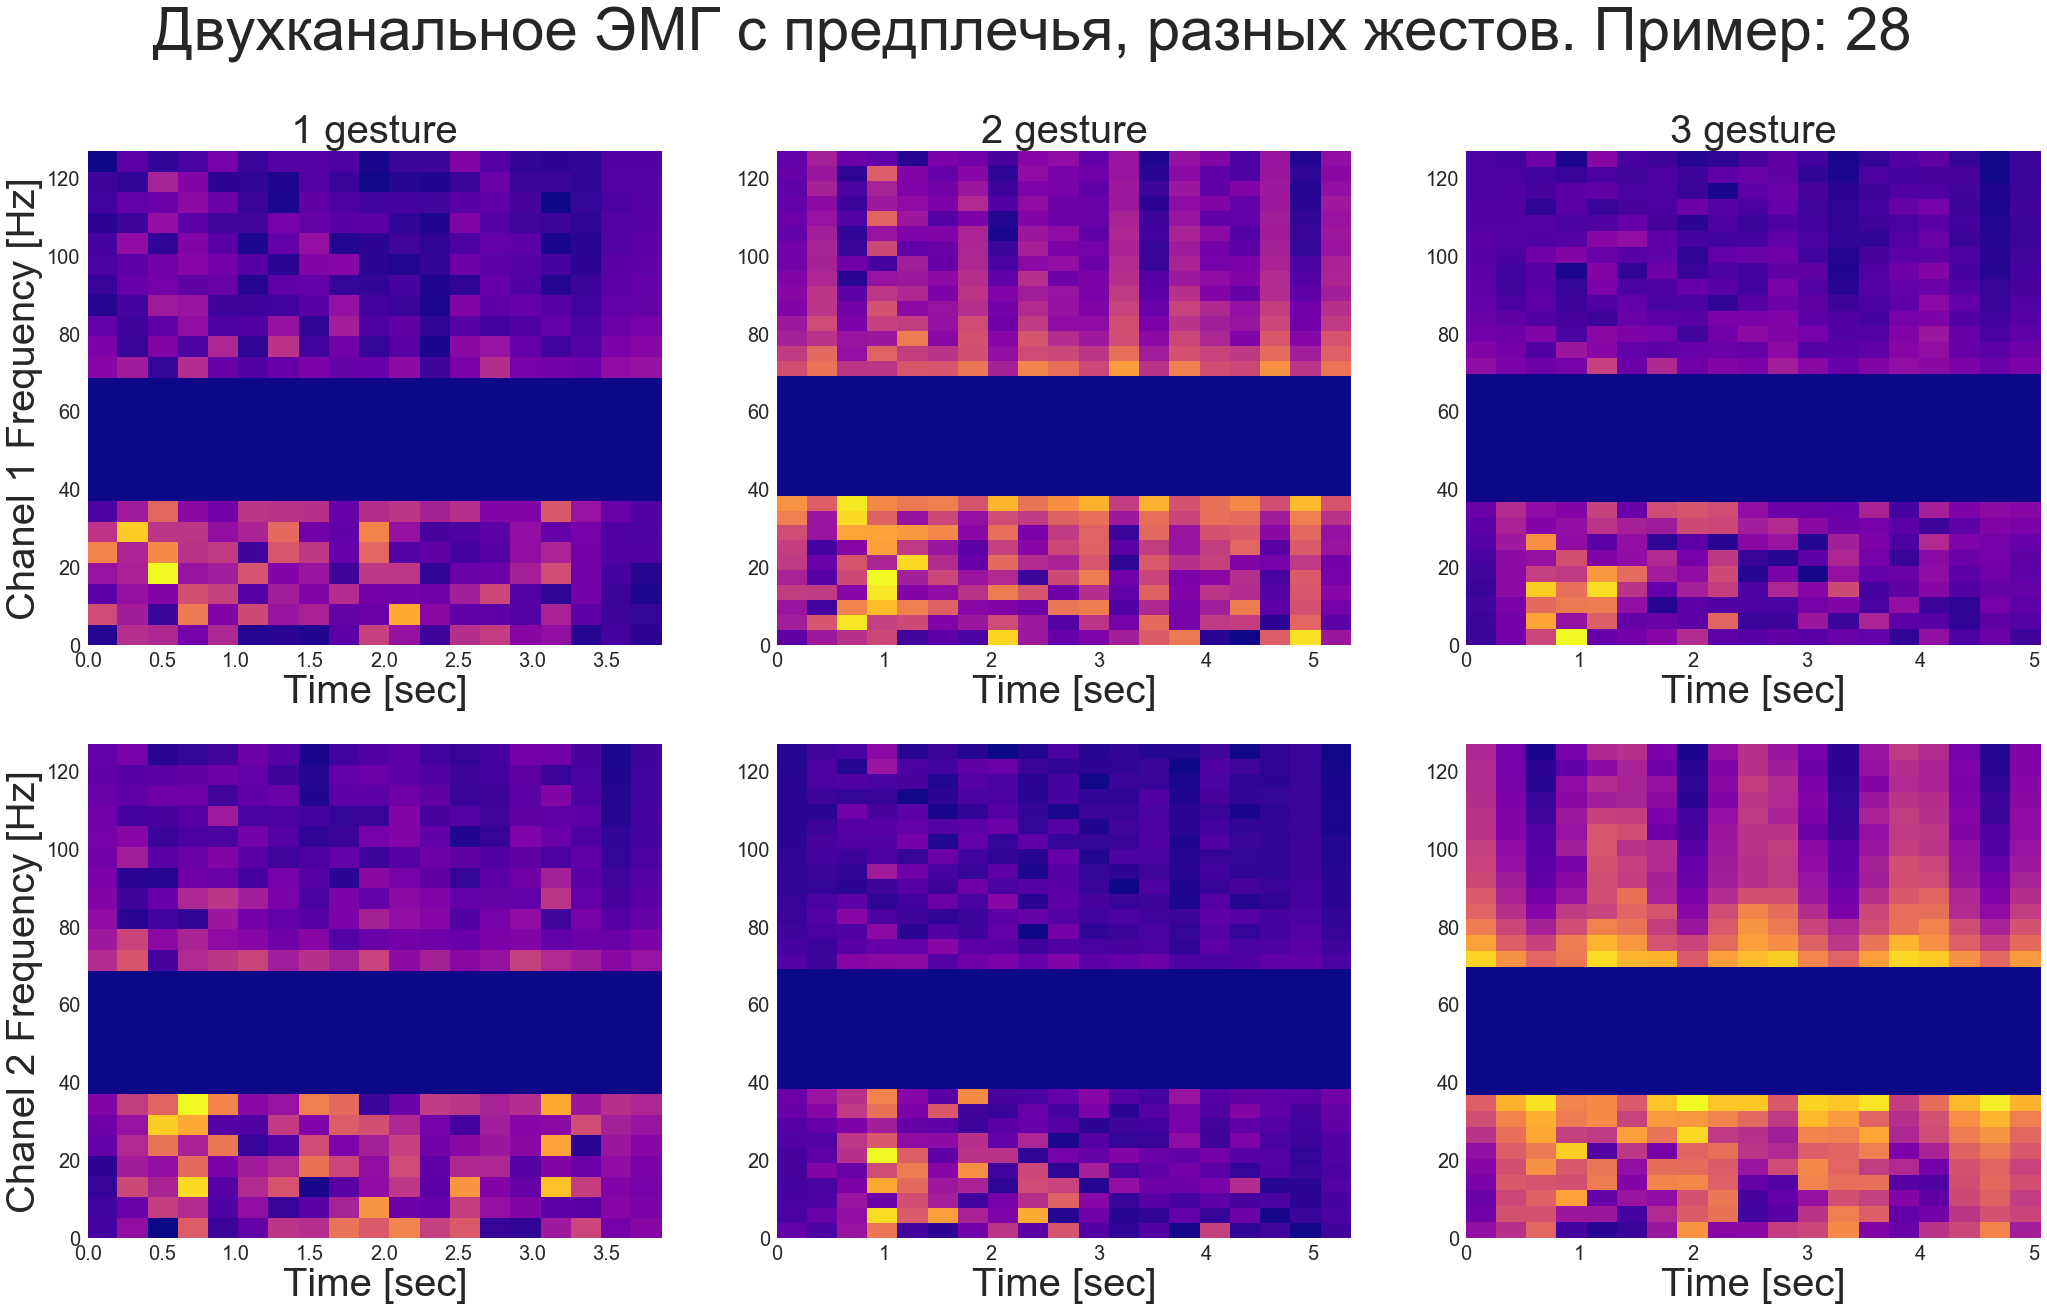

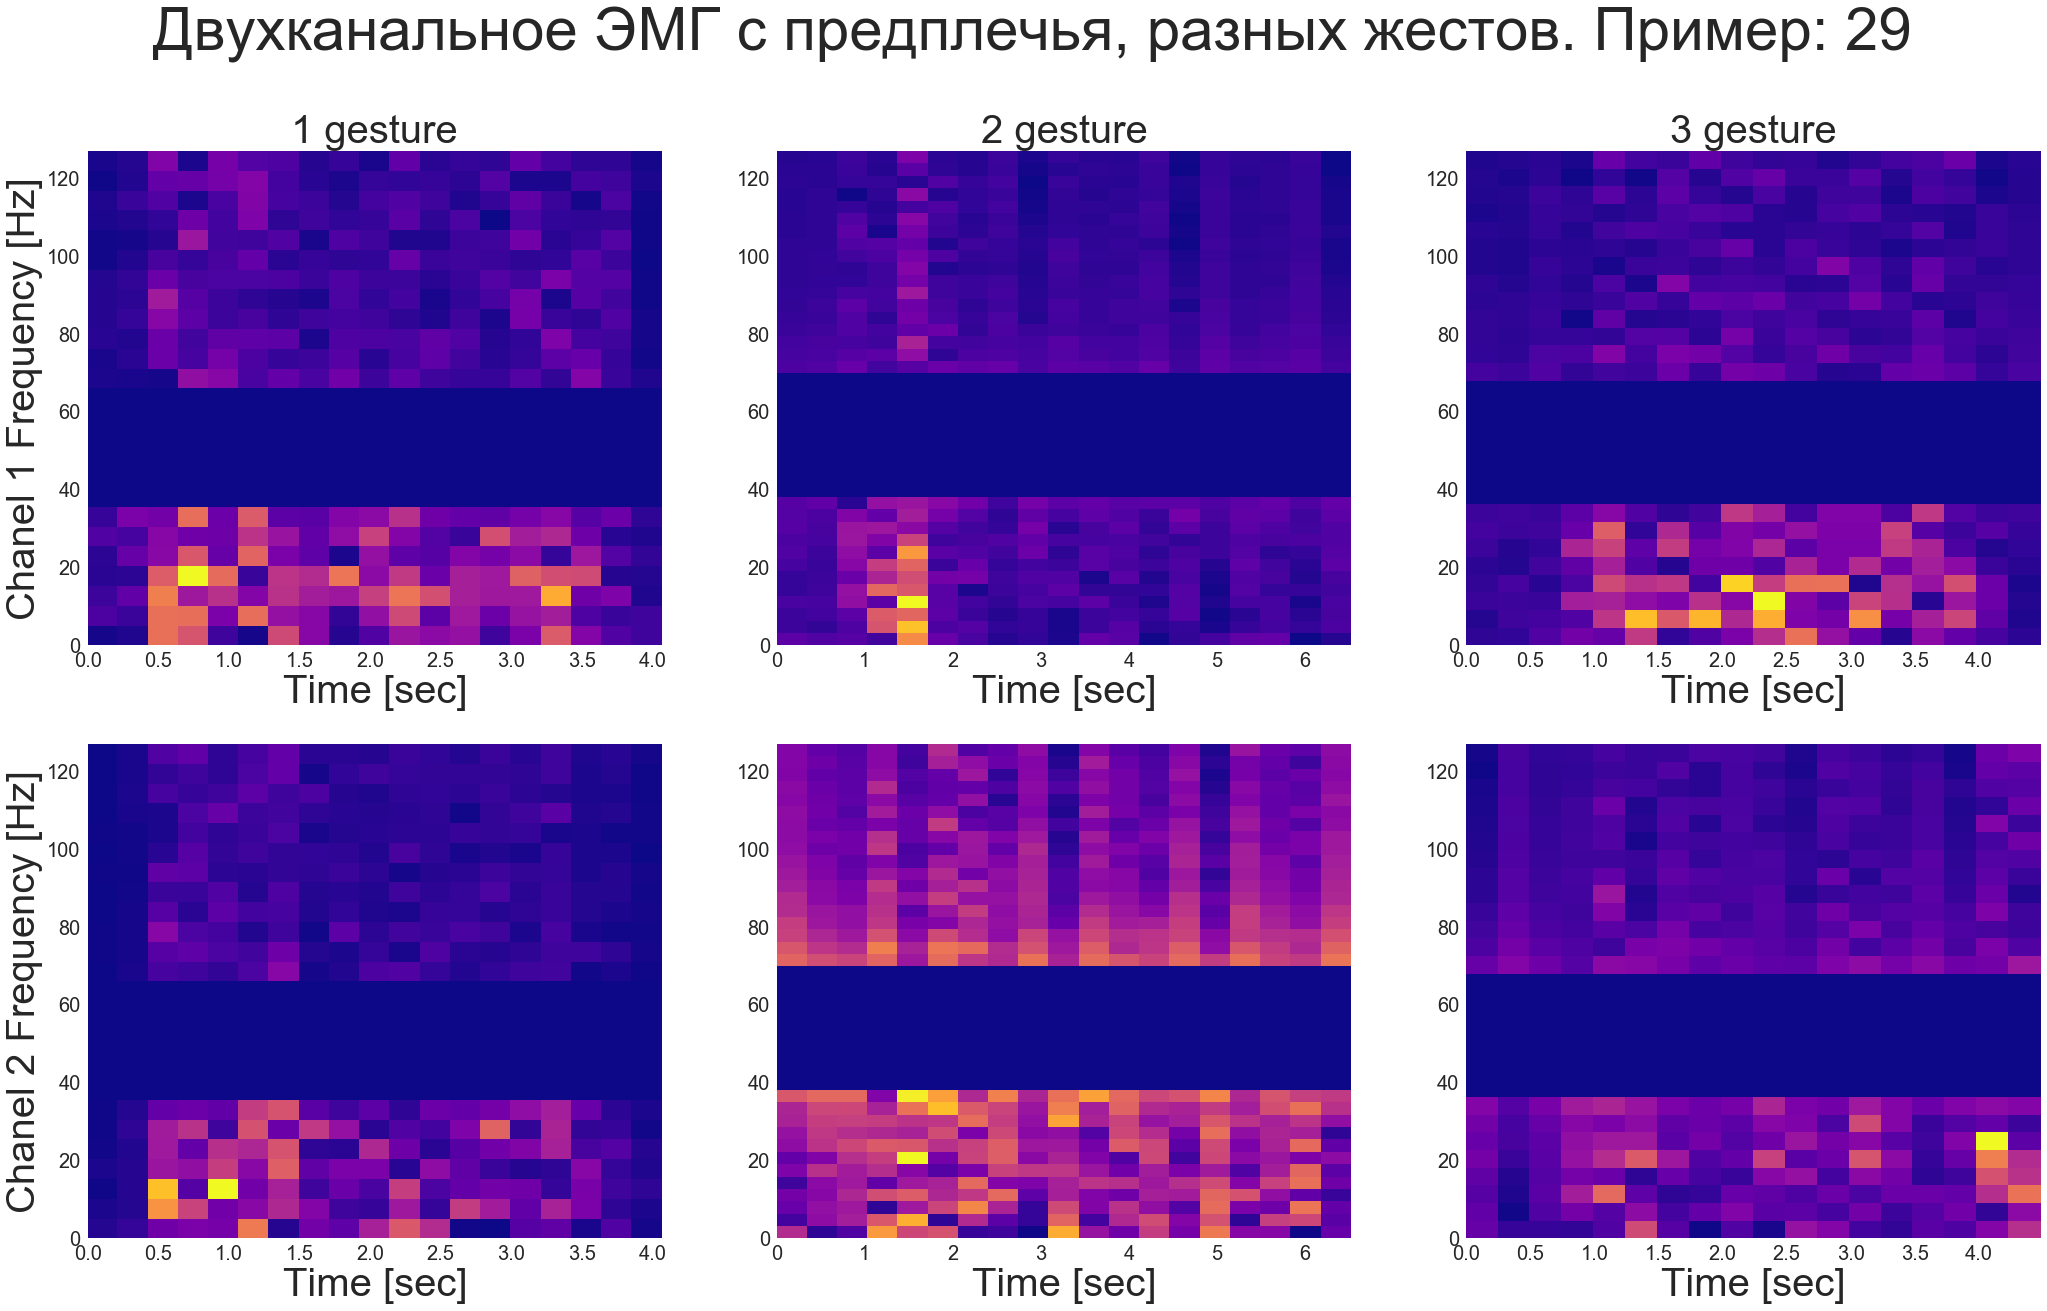

In [4]:
n = 20
cmap = 'plasma'

for examp_num in range(0, 29):
    
    fig, axes = plt.subplots(2, 3, figsize=(35, 20))
    
    for ax in axes.flatten():
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel('Time [sec]', fontsize=40)
    
    fig.suptitle("Двухканальное ЭМГ с предплечья, разных жестов. Пример: " + str(examp_num+1), fontsize=60)
        
    axes[0, 0].set_title('1 gesture', fontsize=40)
    axes[0, 1].set_title('2 gesture', fontsize=40)
    axes[0, 2].set_title('3 gesture', fontsize=40)
    axes[0, 0].set_ylabel('Chanel 1 Frequency [Hz]', fontsize=40)
    axes[1, 0].set_ylabel('Chanel 2 Frequency [Hz]', fontsize=40)
    
    # 1
    ch1 = signals_1[examp_num][0]
    ch2 = signals_1[examp_num][1]
    
    axes[0, 0].pcolormesh(*getSpector(ch1, n), cmap=cmap)
    axes[1, 0].pcolormesh(*getSpector(ch2, n), cmap=cmap)
    
    # 2
    ch1 = signals_2[examp_num][0]
    ch2 = signals_2[examp_num][1]
    
    axes[0, 1].pcolormesh(*getSpector(ch1, n), cmap=cmap)
    axes[1, 1].pcolormesh(*getSpector(ch2, n), cmap=cmap)
    
    # 3
    ch1 = signals_3[examp_num][0]
    ch2 = signals_3[examp_num][1]
    
    axes[0, 2].pcolormesh(*getSpector(ch1, n), cmap=cmap)
    axes[1, 2].pcolormesh(*getSpector(ch2, n), cmap=cmap)

In [5]:
def getFeatures(signals):
    s = 500
    n = 10
    handler = lambda sig: list(cv2.resize(getSpector(sig, n)[2], (15, n)).flatten())

    ch1 = handler(signals[0])
    ch2 = handler(signals[1])
    
    features = ch1 + ch2

    return features

x = list(map(getFeatures, signals_1)) + list(map(getFeatures, signals_2)) + list(map(getFeatures, signals_3))

y = [1]*29+[2]*29+[3]*29

In [32]:
test_size = 0.01

df = pd.DataFrame(x)
df['y'] = y

cl0 = df[df.y==1]
cl1 = df[df.y==2]
cl2 = df[df.y==3]

train_x_0, test_x_0, train_y_0, test_y_0 = train_test_split(cl0.drop('y', axis=1), cl0.y, test_size=test_size)
train_x_1, test_x_1, train_y_1, test_y_1 = train_test_split(cl1.drop('y', axis=1), cl1.y, test_size=test_size)
train_x_2, test_x_2, train_y_2, test_y_2 = train_test_split(cl2.drop('y', axis=1), cl2.y, test_size=test_size)

train_x, test_x, train_y, test_y = pd.concat([train_x_0, train_x_1, train_x_2]), pd.concat([test_x_0, test_x_1, test_x_2]), pd.concat([train_y_0, train_y_1, train_y_2]), pd.concat([test_y_0, test_y_1, test_y_2])

train = shuffle(pd.concat([train_x, train_y], axis=1))
test = shuffle(pd.concat([test_x, test_y], axis=1))

train_x, test_x, train_y, test_y = train.drop('y', axis=1), test.drop('y', axis=1), train.y, test.y

In [33]:
from catboost import CatBoostClassifier, Pool

train_pool = Pool(train_x, train_y)
test_pool = Pool(test_x, test_y)
model = CatBoostClassifier(eval_metric='Accuracy', custom_metric='F1', 
                           iterations=200, learning_rate=0.1)

model.fit(train_pool, eval_set=test_pool, plot=True, verbose=False)

model.save_model('model_best')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [35]:
model = CatBoostClassifier()

model.load_model('model_best')

data = []
file = open("val_set.txt")

for sig in file.read().split('\n\n'):
    sig = sig.split('\n')
    chanels = [np.array(sig[0].split(), dtype='int16'), np.array(sig[1].split(), dtype='int16')]
    data.append(chanels)
file.close()
    
data = np.array(list(map(getFeatures, data)))

pred = model.predict(data)
# pred = np.array(list(map(lambda p: 1 if p[0] > p[1] else 2, pred)))

print(' '.join(list(map(lambda asd: str(asd[0]), pred))))

1 3 1 3 3 3 3 2 2 1 3 2 3 2 3 1 3 3 3 2 2 3 2 3 3 2 3 2 2 1 2 3 1 3 3 2 2 3 3 2 1 2 2 3 1 1 3 1 3 3 3 1 2 3 2 3 3 3 1 3 1 1 2 2 1 2 2 3 1 1 2 3 2 2 2 1 1 3 2 2 3 2 2 1 2 1 2
